<a href="https://colab.research.google.com/github/Baragouine/SentimentAnalysisReviewAmazone/blob/main/ML2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet ML2: Création de modèle de prédiction de note et de l'utilité de commentaire sur des produits de boutique en ligne
Télécharger le dataset et le modèle de google pour pouvoir exécuter le notebook:
 * Dataset: http://jmcauley.ucsd.edu/data/amazon/index_2014.html  
 * Modèle de google (word2vec: GoogleNews-vectors-negative300.bin): https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g

Le dataset est très volumineux, nous vous conseillons donc de créer un sample à l'aide du notebook suivant: https://colab.research.google.com/drive/121vpmUad_6NTvcKytY64znGbckNeB443?usp=sharing


## 1. Pré-traitement des données

### A. Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import gensim
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.porter import PorterStemmer
import gensim.models.keyedvectors as word2vec

# Ignorer les warnings
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

from textblob import TextBlob
from random import sample

### B. Chargement des données

In [ ]:
# Chargement des données
df = pd.read_csv('./dataset/sample.csv',sep=';')

# Suppression des na
df = df.dropna()

# Apercu du dataset
df.head(3)

,title,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,Adult Ballet Tutu Yellow,0000032034,"[11, 12]",5.0,Purchased and wore these tutus for the Portlan...,"09 10, 2013",A2MPIVS0KSY8O0,Sonja,Tutus,1378771200
1,Along Came a Spider,0006476155,"[0, 0]",5.0,"Great development of characters, you begin to ...","01 14, 2013",A37QDGQ90TLQQX,Albert Wimberly,Great character development / compelling case ...,1358121600
2,Along Came a Spider,0006476155,"[0, 0]",4.0,Always a true fan of James Patterson. He knows...,"01 5, 2014",A3S8MFLN2HZ7RI,footsie517,Love it!!!,1388880000


In [ ]:
# shape
df.shape

(543646, 10)

Les titres et les commentaires sont en anglais.

### C. Transformation de l'utilité en nombre
L'utilité (colonne helpful) est une liste de deux éléments qui représente une fraction, le premier élément est le dividende et le deuxième le diviseur.

In [ ]:
# Fonction qui convertie l'utilité en nombre
def parse_helpful(s):
  tmp = s.split(",")
  tmp = [int(i) for i in tmp]
  return 0 if tmp[1] == 0 else round(tmp[0] / tmp[1], 1)

In [ ]:
df['helpful'] = df['helpful'].str.replace(' ', '', regex=False).str.replace('[', '', regex=False).str.replace(']', '', regex=False)
df['helpful'] = df['helpful'].apply(lambda line : parse_helpful(line))
df['helpful'].head(3)

0    0.9
1    0.0
2    0.0
Name: helpful, dtype: float64

### D. Statistiques

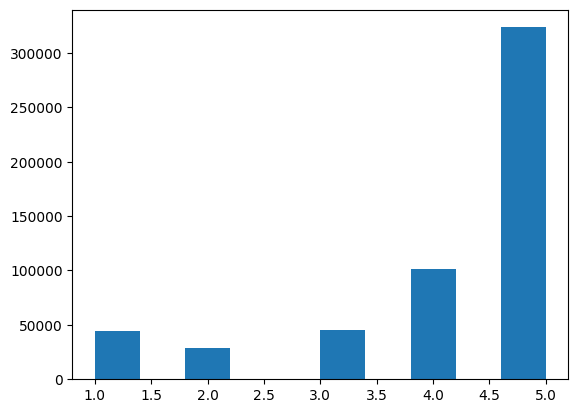

In [ ]:
# Distributions des notes
plt.hist(df['overall'])
plt.show()

In [ ]:
# Nombre de note égal à 2
(df['overall'] == 2.0).sum()

28525

In [ ]:
# Différentes valeurs possibles pour l'utilité
df['helpful'].unique()

array([0.9, 0. , 1. , 0.5, 0.8, 0.1, 0.7, 0.6, 0.4, 0.2, 0.3, 1.5])

In [ ]:
# Ramener à 1 les valeurs qui dépassent 1
df['helpful'] = df['helpful'].apply(lambda n : int((n if n <= 1 else 1) * 10))
df['helpful'].unique()

array([ 9,  0, 10,  5,  8,  1,  7,  6,  4,  2,  3])

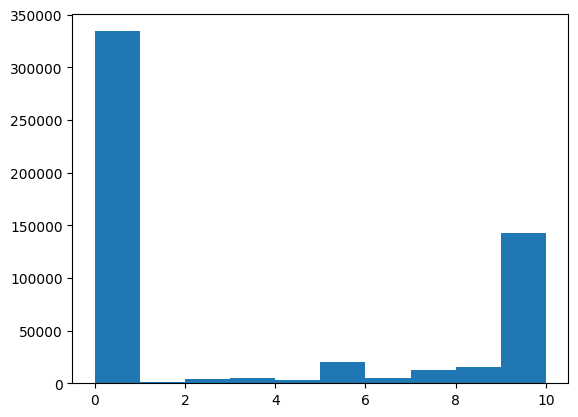

In [ ]:
# Distribution de l'utilité
plt.hist(df['helpful'])
plt.show()

### Fonction de preprocessing d'un text (passage d'un texte à une liste de token)

In [ ]:
porter_stemmer = PorterStemmer()
def preprocess_text(sentence):
    sentence = remove_stopwords(sentence)
    tokenized_sentence = gensim.utils.simple_preprocess(sentence, deacc=True) # Tokenize the sentence and delete accent
    tokenized_sentence = [porter_stemmer.stem(word) for word in tokenized_sentence] #stemmatization (garde seulement la racine des mots)
    # tokenized_sentence = tokenized_sentence[:300]
    return tokenized_sentence

## 2. Modèle qui ne prédit que la note

### A. Préparation du corpus et des labels

#### I. Sélection de 28525 lignes pour chaque note pour avoir un dataset équilibré

In [ ]:
# Renvoie n lignes du dataset avec une note égal à note
def data_sample_by_note(data, n, note):
  tmp_data = data[data["overall"] == note]
  idx = list(tmp_data.index)
  idx = sample(range(len(idx)), min(n, len(idx)))
  return tmp_data.iloc[idx]

In [ ]:
# Nombre de lignes à prendre par catégorie
nb_line_per_category = df['overall'].value_counts().min()

# TODO: Ligne a supprimer dans la version finale, si nécessaire
nb_line_per_category = 10000

# Affichage
nb_line_per_category

10000

In [ ]:
# dataset utilisé pour la prédiction de la note
note_df = pd.concat([data_sample_by_note(df, nb_line_per_category, i) for i in df['overall'].unique()])
# Vérification de la taille
note_df.shape

(50000, 10)

#### II. Split du dataset

In [ ]:
# Affectation et transformation
Y = note_df['overall']
X = note_df[['title', 'reviewText']]

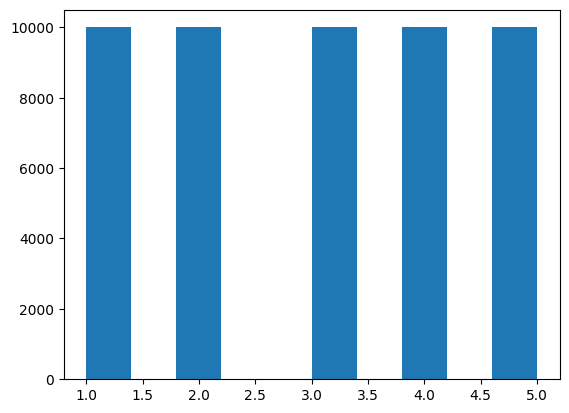

In [ ]:
# Distribution des note
plt.hist(Y)
plt.show()

In [ ]:
# split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,shuffle=True,random_state=1)

In [ ]:
reviews_train_tokens = X_train['reviewText'].apply(lambda line : preprocess_text(line))
reviews_test_tokens = X_test['reviewText'].apply(lambda line : preprocess_text(line))

In [ ]:
title_train_tokens = X_train['title'].apply(lambda line : preprocess_text(line))
title_test_tokens = X_test['title'].apply(lambda line : preprocess_text(line))

### B. Utilisation que du commentaire

#### I. Moyenne des embeddings

In [ ]:
# Calcul de l'embedding d'une phrase
def word2vec_generator(texts,model,vector_size):
    dict_word2vec = {}
    for index, word_list in enumerate(texts):
        arr = np.array([0.0 for i in range(0, vector_size)])
        nb_word=0
        for word in word_list:
            try:
                arr += model[word]
                nb_word=nb_word+1
            except KeyError:
                continue
        if(len(word_list) == 0):
            dict_word2vec[index] = arr
        else:
            try:
                dict_word2vec[index] = arr / (nb_word if nb_word != 0 else 1)
            except RuntimeWarning:
                print(index)
                print(arr)
                print(nb_word)
    df_word2vec = pd.DataFrame(dict_word2vec).T
    return df_word2vec

In [ ]:
model_google_vec_neg_300 = word2vec.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
print(model_google_vec_neg_300.vector_size)

300


In [ ]:
vector_size=model_google_vec_neg_300.vector_size
corpus_train_wv_google=word2vec_generator(reviews_train_tokens,model_google_vec_neg_300,vector_size)
corpus_test_wv_google=word2vec_generator(reviews_test_tokens,model_google_vec_neg_300,vector_size)

In [ ]:
from statistics import mean

# Notre accuracy personaliser accepte les distances de 1 entre les y
def customized_accuracy(y_true, y_pred, d = 1):
  return mean([(1 if abs(y_true[i] - y_pred[i]) <= d else 0) for i in range(len(y_true))])

In [ ]:
from sklearn.metrics import mean_absolute_error,accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

algos = {
  'RF' : RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1),
  'KNN' : KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine'),
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=800,random_state=1,alpha=0.001)
}

def run_models (X_train,Y_train,X_test,Y_test,algos):
    for algo_name in algos:
        model=algos[algo_name]
        model.fit(X_train,Y_train)
        prediction=model.predict(X_test)
        prediction[prediction<1]=1
        prediction[prediction>5]=5
        MAE=mean_absolute_error(Y_test,prediction)
        ACC=accuracy_score(Y_test,np.round(prediction))
        CACC=customized_accuracy(Y_test,np.round(prediction))
        
        print('################## {0} #############'.format(algo_name))
        print('MAE = {0:.3f}, Accuracy = {1:.3f}, Customized Accuracy = {2:.3f}'.format(MAE,ACC, CACC))
        display(confusion_matrix(Y_test,np.round(prediction)))
        print()

In [ ]:
run_models(corpus_train_wv_google, y_train, corpus_test_wv_google, y_test.to_numpy(), algos)

################## RF #############
MAE = 1.070, Accuracy = 0.246, Customized Accuracy = 0.717


array([[   6,  728, 1176,   69,    0],
       [   2,  480, 1372,  129,    0],
       [   1,  269, 1451,  230,    0],
       [   0,  141, 1354,  496,   10],
       [   0,  104, 1207,  752,   23]])


################## KNN #############
MAE = 1.127, Accuracy = 0.249, Customized Accuracy = 0.695


array([[ 123,  756,  891,  200,    9],
       [  54,  639,  984,  300,    6],
       [  26,  472, 1086,  353,   14],
       [   8,  335, 1085,  533,   40],
       [   2,  286,  977,  713,  108]])


################## MLP #############
MAE = 0.976, Accuracy = 0.325, Customized Accuracy = 0.790


array([[ 360, 1019,  305,  272,   23],
       [ 145,  947,  426,  432,   33],
       [  57,  614,  494,  743,   43],
       [  27,  351,  424, 1045,  154],
       [  34,  259,  260, 1133,  400]])

##### Courbe d'apprentissage du meilleur modèle

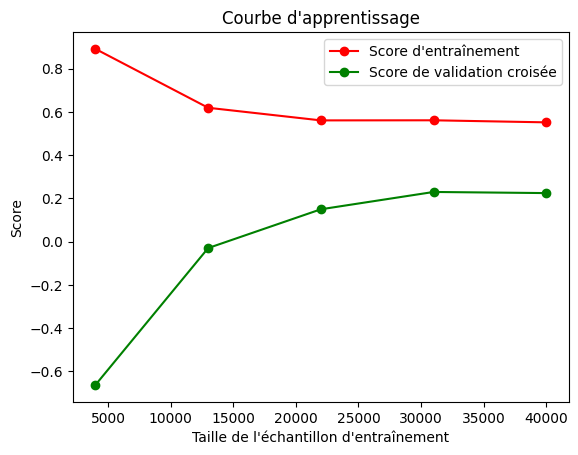

In [ ]:
from sklearn.model_selection import learning_curve

# utiliser la fonction learning_curve
train_sizes, train_scores, test_scores = learning_curve(\
  algos["MLP"], pd.concat([corpus_train_wv_google, corpus_test_wv_google]),\
  pd.concat([y_train, y_test]))

# tracer les courbes d'apprentissage
plt.figure()
plt.title("Courbe d'apprentissage")
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Score")
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', color="g", label="Score de validation croisée")
plt.legend(loc="best")
plt.show()

Nous voyons qu'il n'y a pas besoin de plus de données pour l'entraînement.

##### Amélioration du meilleur modèle

In [ ]:
# Plus de neurones
algos = {
  'MLP' : MLPRegressor(hidden_layer_sizes=(40, 20),max_iter=800,random_state=1,alpha=0.001)
}

run_models(corpus_train_wv_google, y_train, corpus_test_wv_google, y_test.to_numpy(), algos)

################## MLP #############
MAE = 1.007, Accuracy = 0.329, Customized Accuracy = 0.768


array([[442, 801, 397, 253,  86],
       [217, 715, 590, 367,  94],
       [ 91, 477, 651, 581, 151],
       [ 46, 251, 523, 815, 366],
       [ 55, 161, 366, 842, 662]])

On perd en MAE, on gagne un peu en Accuracy mais on perd en Customized Accuracy: Ça n'améliore pas les performances.

In [ ]:
# Moins de neurones
algos = {
  'MLP' : MLPRegressor(hidden_layer_sizes=(10, 5),max_iter=800,random_state=1,alpha=0.001)
}

run_models(corpus_train_wv_google, y_train, corpus_test_wv_google, y_test.to_numpy(), algos)

################## MLP #############
MAE = 0.941, Accuracy = 0.323, Customized Accuracy = 0.805


array([[ 400, 1015,  399,  153,   12],
       [ 158,  930,  640,  242,   13],
       [  55,  590,  796,  492,   18],
       [  28,  297,  747,  833,   96],
       [  24,  199,  512, 1078,  273]])

On gagne au niveau du MAE, on perd en Accuracy et on gagne en Customized Accuracy: Ça améliore un peu les performances mais c'est négligeable.

#### II. Prise en compte de la longueur, de la spécificité et de la subjectivité du texte

In [ ]:
# Renvoie la polarité d'un texte
def polarity_txt(text):
    return TextBlob(text).sentiment[0] 

# Renvoie la subjectivité d'un texte
def subj_txt(text):
    return  TextBlob(text).sentiment[1]

In [ ]:
# Calcul de la longueur, la spécificité et la subjectivité
df_meta_train=pd.DataFrame([])
df_meta_train['length_text'] = [len(reviews_train_tokens.iloc[i]) for i in range(len(reviews_train_tokens))]
df_meta_train['polarity'] = [polarity_txt(X_train["reviewText"].iloc[i]) for i in range(len(X_train))]
df_meta_train['subjectivity'] = [subj_txt(X_train["reviewText"].iloc[i]) for i in range(len(X_train))]

df_meta_test=pd.DataFrame([])
df_meta_test['length_text'] = [len(reviews_test_tokens.iloc[i]) for i in range(len(reviews_test_tokens))]
df_meta_test['polarity'] = [polarity_txt(X_test["reviewText"].iloc[i]) for i in range(len(X_test))]
df_meta_test['subjectivity'] = [subj_txt(X_test["reviewText"].iloc[i]) for i in range(len(X_test))]

In [ ]:
# Shape des données du train transformer
corpus_train_wv_google.shape

(40000, 300)

In [ ]:
# Concaténation
corpus_train_wv_google_meta=pd.concat([corpus_train_wv_google,df_meta_train],axis=1)
corpus_test_wv_google_meta=pd.concat([corpus_test_wv_google,df_meta_test],axis=1)

In [ ]:
# Shape des données du train après concaténation
corpus_train_wv_google_meta.shape

(40000, 303)

In [ ]:
corpus_train_wv_google_meta.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,length_text,polarity,subjectivity
0,0.029349,0.039355,-0.043146,0.137334,-0.050119,0.011490,0.037109,-0.058620,0.036689,0.074262,-0.052490,-0.120954,-0.065456,-0.007420,-0.107020,0.025611,0.082581,0.117641,-0.080366,-0.057848,0.007472,0.040187,0.015901,0.026445,0.038720,0.048357,-0.055760,0.038609,0.034306,-0.152562,-0.105931,0.095141,-0.011897,-0.013230,-0.065061,-0.130545,0.016349,0.089068,0.017705,-0.019113,0.050886,-0.137695,0.223364,0.012050,0.026917,0.019598,-0.057053,0.055734,-0.056854,0.022518,-0.058526,0.042130,0.006001,0.010803,0.009626,-0.032889,-0.019396,-0.083147,0.046321,-0.046790,-0.085031,0.119106,-0.171291,-0.068813,0.117058,-0.02260,-0.038156,0.048811,-0.078201,0.080414,0.110713,0.029674,0.084643,0.007516,-0.212769,0.045794,0.056074,0.072498,0.071429,0.045323,0.006836,0.010429,0.001552,0.008327,-0.044635,0.028966,0.043653,0.115702,0.058755,-0.003577,-0.022288,-0.006223,-0.064606,-0.084874,-0.045925,-0.010803,0.144930,0.027706,0.036451,-0.136647,-0.066066,0.026742,0.036355,-0.021649,-0.071716,-0.020543,0.048941,-0.049635,0.007207,-0.107270,-0.095982,-0.026106,0.036152,-0.081857,0.124246,-0.044870,0.009783,-0.002145,-0.028431,-0.000589,-0.108172,-0.059658,-0.093497,0.034520,0.025427,-0.050507,-0.073363,-0.030029,0.006771,0.006856,-0.106724,-0.012695,0.020935,0.178149,-0.012427,-0.010827,-0.006696,0.043917,0.002947,0.122637,0.098938,-0.079065,0.032924,-0.004040,-0.079830,0.036145,-0.063729,-0.036996,-0.019060,-0.004517,0.161743,0.030021,-0.092826,0.113676,-0.090441,-0.054308,-0.043638,-0.074184,-0.077776,-0.064273,-0.104289,0.091649,0.018354,0.064697,0.025271,-0.161298,-0.001225,-0.029922,-0.003283,-0.043265,-0.137870,0.009999,0.023056,0.051784,0.010817,0.058472,0.121730,-0.068704,-0.083221,0.079237,-0.071141,-0.091073,0.047538,0.063494,-0.018337,-0.025423,-0.020890,-0.072911,0.053816,-0.024026,0.019584,0.008074,0.011818,-0.053589,0.000462,0.176505,-0.008375,-0.136230,-0.138829,-0.090470,0.018563,0.064261,-0.087738,-0.071213,0.036503,-0.151509,-0.030448,-0.031996,-0.064571,0.040584,-0.081959,0.092773,-0.139744,0.042459,-0.032533,-0.027989,0.098371,0.043300,-0.135919,-0.003034,-0.030036,0.065979,0.013876,-0.017308,0.077567,-0.013354,0.001551,0.046534,-0.043215,0.047590,-0.033900,-0.018250,0.006884,-0.033901,0.062081,0.028909,-0.053926,-0.154968,0.101880,0.072985,0.126535,-0.017020,-0.046378,-0.105586,-0.020673,0.043405,0.009373,0.068233,-0.097857,-0.207807,-0.008571,0.104527,0.096941,0.115147,-0.008942,-0.110573,-0.040229,-0.051553,0.031355,-0.105504,0.010230,-0.020512,-0.078979,0.013674,-0.064750,0.162955,-0.077624,-0.150068,-0.085999,-0.046899,-0.023124,0.054796,0.170694,0.074289,0.063477,-0.080540,-0.018136,-0.030698,0.003611,0.047468,0.082973,-0.017027,0.099034,0.100255,0.036614,-0.064976,-0.057118,-0.088784,-0.036063,0.114485,-0.024549,0.183432,-0.109658,0.030273,-0.043125,-0.049957,-0.017133,-0.090628,-0.043672,0.064272,19,0.242857,0.500

In [ ]:
# Entraînement
algos = {
  'RF' : RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1),
  'KNN' : KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine'),
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=800,random_state=1,alpha=0.001)
}

run_models(corpus_train_wv_google_meta,y_train,corpus_test_wv_google_meta,y_test.to_numpy(),algos)

################## RF #############
MAE = 0.977, Accuracy = 0.285, Customized Accuracy = 0.786


array([[ 101, 1017,  736,  125,    0],
       [  25,  738, 1043,  177,    0],
       [  11,  416, 1152,  368,    4],
       [   2,  174, 1043,  758,   24],
       [   2,  112,  792, 1078,  102]])


################## KNN #############
MAE = 1.012, Accuracy = 0.295, Customized Accuracy = 0.759


array([[265, 789, 688, 216,  21],
       [102, 644, 853, 354,  30],
       [ 49, 445, 860, 534,  63],
       [ 16, 212, 807, 818, 148],
       [ 10, 160, 594, 963, 359]])


################## MLP #############
MAE = 0.890, Accuracy = 0.348, Customized Accuracy = 0.823


array([[ 431,  985,  439,  110,   14],
       [ 139,  906,  732,  196,   10],
       [  55,  549,  940,  383,   24],
       [  12,  229,  817,  819,  124],
       [   8,  144,  529, 1021,  384]])

Tous les modèles ont nettement été améliorer.

#### III. Prise en compte de l'ordre des mots (LSTM)

In [ ]:
# Sequences
def to_sequence(index, text):
    indexes = [index[word] for word in text if word in index]
    return indexes

In [ ]:
word2idx = {word: idx for idx, word in enumerate(model_google_vec_neg_300.index_to_key)}
X_train_sequences = [to_sequence(word2idx, x) for x in reviews_train_tokens]
X_test_sequences = [to_sequence(word2idx, x) for x in  reviews_test_tokens]

print(reviews_train_tokens.values[0])
print(X_train_sequences[0])

['good', 'crib', 'live', 'room', 'temp', 'portabl', 'sleep', 'solut', 'rock', 'nice', 'stabl', 'chang', 'tabl', 'useless', 'sound', 'rough', 'otherwis', 'cute', 'us']
[127, 27331, 588, 835, 38986, 3629, 2453, 1535, 158051, 13788, 1867, 4876, 10659, 164]


In [ ]:
from keras.utils import pad_sequences

2023-01-23 15:05:56.055491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 15:05:57.306869: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-23 15:05:57.306930: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-23 15:05:57.306934: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [ ]:
MAX_SEQ_LENGHT=50
N_FEATURES = len(model_google_vec_neg_300.index_to_key)
X_train_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
X_test_sequences = pad_sequences(X_test_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
print(X_train_sequences[0])

[3000000 3000000 3000000 3000000 3000000 3000000 3000000 3000000 3000000
 3000000 3000000 3000000 3000000 3000000 3000000 3000000 3000000 3000000
 3000000 3000000 3000000 3000000 3000000 3000000 3000000 3000000 3000000
 3000000 3000000 3000000 3000000 3000000 3000000 3000000 3000000 3000000
     127   27331     588     835   38986    3629    2453    1535  158051
   13788    1867    4876   10659     164]


In [ ]:
EMBEDDINGS_LEN = model_google_vec_neg_300.vector_size
embeddings_index = np.zeros((len(model_google_vec_neg_300.index_to_key)+1, EMBEDDINGS_LEN))
embeddings_index.shape

(3000001, 300)

In [ ]:
for word, idx in word2idx.items():
    try:
        embedding = model_google_vec_neg_300[word]
        embeddings_index[idx] = embedding
    except:
        pass
      
print("EMBEDDINGS_LEN=", EMBEDDINGS_LEN)

EMBEDDINGS_LEN= 300


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Dense,LSTM


model_lstm = Sequential()
model_lstm.add(Embedding(len(model_google_vec_neg_300.key_to_index)+1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    trainable=False))

model_lstm.add(LSTM(300, dropout=0.2))

model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model_lstm.summary()

2023-01-23 15:26:28.525356: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3600001200 exceeds 10% of free system memory.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         900000300 
                                                                 
 lstm_1 (LSTM)               (None, 300)               721200    
                                                                 
 dense_1 (Dense)             (None, 1)                 301       
                                                                 
Total params: 900,721,801
Trainable params: 721,501
Non-trainable params: 900,000,300
_________________________________________________________________


In [ ]:
history = model_lstm.fit(X_train_sequences, y_train, epochs=10, batch_size=128, verbose=1,validation_split=0.1)

Epoch 1/10
282/282 [==============================] - 41s 142ms/step - loss: 1.0649 - mean_absolute_error: 1.0649 - val_loss: 0.9888 - val_mean_absolute_error: 0.9888
Epoch 2/10
282/282 [==============================] - 39s 138ms/step - loss: 0.9595 - mean_absolute_error: 0.9595 - val_loss: 0.9354 - val_mean_absolute_error: 0.9354
Epoch 3/10
282/282 [==============================] - 39s 138ms/step - loss: 0.9198 - mean_absolute_error: 0.9198 - val_loss: 0.8968 - val_mean_absolute_error: 0.8968
Epoch 4/10
282/282 [==============================] - 39s 138ms/step - loss: 0.8930 - mean_absolute_error: 0.8930 - val_loss: 0.8825 - val_mean_absolute_error: 0.8825
Epoch 5/10
282/282 [==============================] - 39s 137ms/step - loss: 0.8660 - mean_absolute_error: 0.8660 - val_loss: 0.9285 - val_mean_absolute_error: 0.9285
Epoch 6/10
282/282 [==============================] - 39s 138ms/step - loss: 0.8469 - mean_absolute_error: 0.8469 - val_loss: 0.8541 - val_mean_absolute_error: 0.854

In [ ]:
scores_lstm = model_lstm.evaluate(X_test_sequences, y_test, verbose=1)

313/313 [==============================] - 8s 24ms/step - loss: 0.8675 - mean_absolute_error: 0.8675


In [ ]:
prediction=model_lstm.predict(X_test_sequences)
prediction[prediction<1]=1
prediction[prediction>5]=5
ACC=accuracy_score(y_test,np.round(prediction))
MAE=mean_absolute_error(y_test,prediction)
CACC=customized_accuracy(y_test.to_numpy(), np.round(prediction))
print('For LSTM MAE = {0:.3f}, Accuracy = {1:.3f}, Customized Accuracy = {2:.3f}'.format(MAE,ACC,CACC))
display(confusion_matrix(y_test,np.round(prediction)))

313/313 [==============================] - 8s 24ms/step
For LSTM MAE = 0.862, Accuracy = 0.389, Customized Accuracy = 0.828


array([[876, 701, 275, 115,  12],
       [379, 885, 540, 170,   9],
       [123, 629, 794, 377,  28],
       [ 27, 273, 691, 835, 175],
       [ 35, 207, 451, 889, 504]])

Meilleur modèle que le précédent.

#### IV. Utilisation de la sortie du LSTM dans d'autres modèles seupervisés

In [ ]:
from keras.models import Model
Model_rf = Model(inputs=model_lstm.inputs, outputs=model_lstm.layers[1].output)
#Model_rf.save('../models/model_lstm_features.h5')
corpus_train_lstm = Model_rf.predict(X_train_sequences)
corpus_test_lstm = Model_rf.predict(X_test_sequences)

313/313 [==============================] - 8s 24ms/step


In [ ]:
algos = {
  'RF' : RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1),
  'KNN' : KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine'),
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=800,random_state=1,alpha=0.001)
}

run_models(corpus_train_lstm,y_train,corpus_test_lstm,y_test.to_numpy(),algos)

################## RF #############
MAE = 0.869, Accuracy = 0.362, Customized Accuracy = 0.837


array([[ 478,  952,  399,  134,   16],
       [ 173,  869,  713,  220,    8],
       [  38,  497,  910,  483,   23],
       [  10,  173,  716,  954,  148],
       [   9,  137,  465, 1061,  414]])


################## KNN #############
MAE = 0.901, Accuracy = 0.369, Customized Accuracy = 0.811


array([[620, 785, 366, 173,  35],
       [253, 784, 613, 294,  39],
       [ 79, 486, 766, 537,  83],
       [ 25, 205, 584, 896, 291],
       [ 24, 159, 404, 870, 629]])


################## MLP #############
MAE = 0.899, Accuracy = 0.380, Customized Accuracy = 0.809


array([[797, 604, 371, 170,  37],
       [352, 707, 599, 299,  26],
       [129, 458, 767, 531,  66],
       [ 49, 189, 591, 915, 257],
       [ 63, 155, 351, 907, 610]])

Il y a amélioration du Random Forest, du KNN mais le MLP n'a gagné qu'en Accuracy, les deux autres métriques ont baissé.

### C. Utilisation du commentaire et du titre du produit

#### I. Moyenne des embeddings

In [ ]:
vector_size=model_google_vec_neg_300.vector_size

reviews_train_wv_google=word2vec_generator(reviews_train_tokens,model_google_vec_neg_300,vector_size)
reviews_test_wv_google=word2vec_generator(reviews_test_tokens,model_google_vec_neg_300,vector_size)

title_train_wv_google=word2vec_generator(title_train_tokens,model_google_vec_neg_300,vector_size)
title_test_wv_google=word2vec_generator(title_test_tokens,model_google_vec_neg_300,vector_size)

# renommage des colonnes de titles...
title_train_wv_google.columns = ["t" + str(c) for c in title_train_wv_google.columns]
title_test_wv_google.columns = ["t" + str(c) for c in title_test_wv_google.columns]

In [ ]:
rev_a_title_train_wv_google = pd.concat([reviews_train_wv_google, title_train_wv_google], axis=1)
rev_a_title_test_wv_google = pd.concat([reviews_test_wv_google, title_test_wv_google], axis=1)

rev_a_title_train_wv_google.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23,t24,t25,t26,t27,t28,t29,t30,t31,t32,t33,t34,t35,t36,t37,t38,t39,t40,t41,t42,t43,t44,t45,t46,t47,t48,t49,t50,t51,t52,t53,t54,t55,t56,t57,t58,t59,t60,t61,t62,t63,t64,t65,t66,t67,t68,t69,t70,t71,t72,t73,t74,t75,t76,t77,t78,t79,t80,t81,t82,t83,t84,t85,t86,t87,t88,t89,t90,t91,t92,t93,t94,t95,t96,t97,t98,t99,t100,t101,t102,t103,t104,t105,t106,t107,t108,t109,t110,t111,t112,t113,t114,t115,t116,t117,t118,t119,t120,t121,t122,t123,t124,t125,t126,t127,t128,t129,t130,t131,t132,t133,t134,t135,t136,t137,t138,t139,t140,t141,t142,t143,t144,t145,t146,t147,t148,t149,t150,t151,t152,t153,t154,t155,t156,t157,t158,t159,t160,t161,t162,t163,t164,t165,t166,t167,t168,t169,t170,t171,t172,t173,t174,t175,t176,t177,t178,t179,t180,t181,t182,t183,t184,t185,t186,t187,t188,t189,t190,t191,t192,t193,t194,t195,t196,t197,t198,t199,t200,t201,t202,t203,t204,t205,t206,t207,t208,t209,t210,t211,t212,t213,t214,t215,t216,t217,t218,t219,t220,t221,t222,t223,t224,t225,t226,t227,t228,t229,t230,t231,t232,t233,t234,t235,t236,t237,t238,t239,t240,t241,t242,t243,t244,t245,t246,t247,t248,t249,t250,t251,t252,t253,t254,t255,t256,t257,t258,t259,t260,t261,t262,t263,t264,t265,t266,t267,t268,t269,t270,t271,t272,t273,t274,t275,t276,t277,t278,t279,t280,t281,t282,t283,t284,t285,t286,t287,t288,t289,t290,t291,t292,t293,t294,t295,t296,t297,t298,t299
0,0.029349,0.039355,-0.043146,0.137334,-0.050119,0.011490,0.037109,-0.058620,0.036689,0.074262,-0.052490,-0.120954,-0.065456,-0.007420,-0.107020,0.025611,0.082581,0.117641,-0.080366,-0.057848,0.007472,0.040187,0.015901,0.026445,0.038720,0.048357,-0.055760,0.038609,0.034306,-0.152562,-0.105931,0.095141,-0.011897,-0.013230,-0.065061,-0.130545,0.016349,0.089068,0.017705,-0.019113,0.050886,-0.137695,0.223364,0.012050,0.026917,0.019598,-0.057053,0.055734,-0.056854,0.022518,-0.058526,0.042130,0.006001,0.010803,0.009626,-0.032889,-0.019396,-0.083147,0.046321,-0.046790,-0.085031,0.119106,-0.171291,-0.068813,0.117058,-0.02260,-0.038156,0.048811,-0.078201,0.080414,0.110713,0.029674,0.084643,0.007516,-0.212769,0.045794,0.056074,0.072498,0.071429,0.045323,0.006836,0.010429,0.001552,0.008327,-0.044635,0.028966,0.043653,0.115702,0.058755,-0.003577,-0.022288,-0.006223,-0.064606,-0.084874,-0.045925,-0.010803,0.144930,0.027706,0.036451,-0.136647,-0.066066,0.026742,0.036355,-0.021649,-0.071716,-0.020543,0.048941,-0.049635,0.007207,-0.107270,-0.095982,-0.026106,0.036152,-0.081857,0.124246,-0.044870,0.009783,-0.002145,-0.028431,-0.000589,-0.108172,-0.059658,-0.093497,0.034520,0.025427,-0.050507,-0.073363,-0.030029,0.006771,0.006856,-0.106724,-0.012695,0.020935,0.178149,-0.012427,-0.010827,-0.006696,0.043917,0.002947,0.122637,0.098938,-0.079065,0.032924,-0.004040,-0.079830,0.036145,-0.063729,-0.036996,-0.019060,-0.004517,0.161743,0.030021,-0.092826,0.113676,-0.090441,-0.054308,-0.043638,-0.074184,-0.077776,-0.06427

In [ ]:
algos = {
  'RF' : RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1),
  'KNN' : KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine'),
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=800,random_state=1,alpha=0.001)
}

run_models(rev_a_title_train_wv_google, y_train, rev_a_title_test_wv_google, y_test.to_numpy(), algos)

################## RF #############
MAE = 1.086, Accuracy = 0.242, Customized Accuracy = 0.711


array([[   6,  690, 1205,   77,    1],
       [   0,  442, 1421,  120,    0],
       [   0,  243, 1497,  211,    0],
       [   0,  124, 1417,  453,    7],
       [   0,   87, 1274,  701,   24]])


################## KNN #############
MAE = 1.245, Accuracy = 0.218, Customized Accuracy = 0.629


array([[  43,  613, 1004,  312,    7],
       [  18,  558,  995,  400,   12],
       [  17,  468, 1081,  373,   12],
       [  29,  398, 1081,  469,   24],
       [   9,  377, 1128,  545,   27]])


################## MLP #############
MAE = 1.044, Accuracy = 0.317, Customized Accuracy = 0.748


array([[467, 825, 373, 229,  85],
       [228, 754, 531, 348, 122],
       [119, 534, 642, 504, 152],
       [ 56, 319, 588, 679, 359],
       [ 50, 243, 428, 736, 629]])

Les performances sont inférieurs a son équivalent dans la partie précédente.

##### Courbe d'apprentissage du meilleur modèle

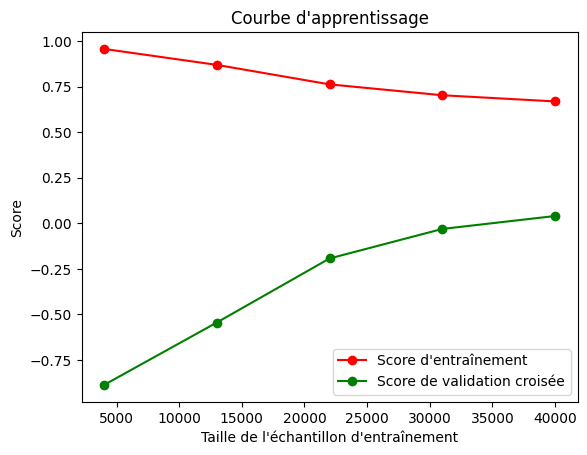

In [ ]:
# utiliser la fonction learning_curve
train_sizes, train_scores, test_scores = learning_curve(\
  algos["MLP"], pd.concat([rev_a_title_train_wv_google, rev_a_title_test_wv_google]),\
  pd.concat([y_train, y_test]))

# tracer les courbes d'apprentissage
plt.figure()
plt.title("Courbe d'apprentissage")
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Score")
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', color="g", label="Score de validation croisée")
plt.legend(loc="best")
plt.show()

Nous voyons qu'il n'y a presque pas besoin de plus de données pour l'entraînement.

##### Amélioration du meilleur modèle

In [ ]:
# Plus de neurones
algos = {
  'MLP' : MLPRegressor(hidden_layer_sizes=(40, 20),max_iter=800,random_state=1,alpha=0.001)
}

run_models(rev_a_title_train_wv_google, y_train, rev_a_title_test_wv_google, y_test.to_numpy(), algos)

################## MLP #############
MAE = 1.174, Accuracy = 0.293, Customized Accuracy = 0.689


array([[722, 558, 336, 223, 140],
       [467, 535, 437, 357, 187],
       [299, 460, 463, 486, 243],
       [202, 335, 463, 565, 436],
       [162, 255, 376, 649, 644]])

C'est pas mieux.

In [ ]:
# Moins de neurones
algos = {
  'MLP' : MLPRegressor(hidden_layer_sizes=(10, 5),max_iter=800,random_state=1,alpha=0.001)
}

run_models(rev_a_title_train_wv_google, y_train, rev_a_title_test_wv_google, y_test.to_numpy(), algos)

################## MLP #############
MAE = 0.981, Accuracy = 0.310, Customized Accuracy = 0.787


array([[ 365,  934,  477,  182,   21],
       [ 177,  731,  704,  346,   25],
       [  61,  531,  772,  546,   41],
       [  33,  253,  685,  881,  149],
       [  38,  200,  448, 1047,  353]])

Petite amélioration.

#### II. Prise en compte de la longueur, de la spécificité et de la subjectivité du texte

In [ ]:
# Calcul de la longueur, la spécificité et la subjectivité
df_meta_train=pd.DataFrame([])
df_meta_train['length_text'] = [len(reviews_train_tokens.iloc[i]) for i in range(len(reviews_train_tokens))]
df_meta_train['polarity'] = [polarity_txt(X_train["reviewText"].iloc[i]) for i in range(len(X_train))]
df_meta_train['subjectivity'] = [subj_txt(X_train["reviewText"].iloc[i]) for i in range(len(X_train))]

df_meta_test=pd.DataFrame([])
df_meta_test['length_text'] = [len(reviews_test_tokens.iloc[i]) for i in range(len(reviews_test_tokens))]
df_meta_test['polarity'] = [polarity_txt(X_test["reviewText"].iloc[i]) for i in range(len(X_test))]
df_meta_test['subjectivity'] = [subj_txt(X_test["reviewText"].iloc[i]) for i in range(len(X_test))]

In [ ]:
# Concaténation
corpus_train_wv_google_meta=pd.concat([reviews_train_wv_google,title_train_wv_google,df_meta_train],axis=1)
corpus_test_wv_google_meta=pd.concat([reviews_test_wv_google,title_test_wv_google,df_meta_test],axis=1)

In [ ]:
# Entraînement et évaluation
algos = {
  'RF' : RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1),
  'KNN' : KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine'),
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=800,random_state=1,alpha=0.001)
}

run_models(corpus_train_wv_google_meta,y_train,corpus_test_wv_google_meta,y_test.to_numpy(),algos)

################## RF #############
MAE = 0.985, Accuracy = 0.279, Customized Accuracy = 0.781


array([[  87, 1016,  752,  123,    1],
       [  25,  736, 1028,  194,    0],
       [  10,  421, 1149,  367,    4],
       [   0,  192, 1060,  731,   18],
       [   3,  113,  798, 1082,   90]])


################## KNN #############
MAE = 1.157, Accuracy = 0.243, Customized Accuracy = 0.684


array([[  64,  671,  944,  287,   13],
       [  42,  554, 1013,  359,   15],
       [  20,  397, 1058,  450,   26],
       [  11,  318,  991,  617,   64],
       [   5,  256,  901,  788,  136]])


################## MLP #############
MAE = 0.944, Accuracy = 0.338, Customized Accuracy = 0.793


array([[484, 869, 443, 147,  36],
       [210, 787, 678, 273,  35],
       [ 87, 537, 819, 446,  62],
       [ 40, 256, 691, 812, 202],
       [ 33, 158, 500, 917, 478]])

Les modèles donnent des meilleurs performance que'avec juste les embeddings sans les méta-données, le Random Forest donne des meilleurs résultats que sans l'utilisation du titre, le KNN est pire que sans les titres et le MLP est meilleurs avec les titres.

Amélioration par rapports au précédent.

#### III. Prise en compte de l'ordre des mots (LSTM)

In [ ]:
# Concaténation des reviews et des titres
title_reviews_train_tokens = pd.Series([title_train_tokens[i] + reviews_train_tokens[i] for i in reviews_train_tokens.index])
title_reviews_test_tokens = pd.Series([title_test_tokens[i] + reviews_test_tokens[i] for i in reviews_test_tokens.index])

In [ ]:
reviews_train_tokens.head(3)

595364    [good, crib, live, room, temp, portabl, sleep,...
533385    [the, screen, fit, perfect, slightli, difficul...
500429    [like, prize, husband, happi, sai, confterbl, ...
Name: reviewText, dtype: object

In [ ]:
X_train_sequences = [to_sequence(word2idx, x) for x in title_reviews_train_tokens]
X_test_sequences = [to_sequence(word2idx, x) for x in  title_reviews_test_tokens]

In [ ]:
MAX_SEQ_LENGHT=75
N_FEATURES = len(model_google_vec_neg_300.index_to_key)
X_train_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
X_test_sequences = pad_sequences(X_test_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)

In [ ]:
EMBEDDINGS_LEN = model_google_vec_neg_300.vector_size
embeddings_index = np.zeros((len(model_google_vec_neg_300.index_to_key)+1, EMBEDDINGS_LEN))
embeddings_index.shape

(3000001, 300)

In [ ]:
for word, idx in word2idx.items():
    try:
        embedding = model_google_vec_neg_300[word]
        embeddings_index[idx] = embedding
    except:
        pass
      
print("EMBEDDINGS_LEN=", EMBEDDINGS_LEN)

EMBEDDINGS_LEN= 300


In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(len(model_google_vec_neg_300.key_to_index)+1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    trainable=False))

model_lstm.add(LSTM(300, dropout=0.2))

model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         900000300 
                                                                 
 lstm_2 (LSTM)               (None, 300)               721200    
                                                                 
 dense_2 (Dense)             (None, 1)                 301       
                                                                 
Total params: 900,721,801
Trainable params: 721,501
Non-trainable params: 900,000,300
_________________________________________________________________


In [ ]:
history = model_lstm.fit(X_train_sequences, y_train, epochs=10, batch_size=128, verbose=1,validation_split=0.1)

Epoch 1/10
282/282 [==============================] - 60s 207ms/step - loss: 1.0919 - mean_absolute_error: 1.0919 - val_loss: 0.9751 - val_mean_absolute_error: 0.9751
Epoch 2/10
282/282 [==============================] - 56s 199ms/step - loss: 0.9774 - mean_absolute_error: 0.9774 - val_loss: 0.9405 - val_mean_absolute_error: 0.9405
Epoch 3/10
282/282 [==============================] - 56s 200ms/step - loss: 0.9317 - mean_absolute_error: 0.9317 - val_loss: 0.9104 - val_mean_absolute_error: 0.9104
Epoch 4/10
282/282 [==============================] - 56s 200ms/step - loss: 0.8956 - mean_absolute_error: 0.8956 - val_loss: 0.8791 - val_mean_absolute_error: 0.8791
Epoch 5/10
282/282 [==============================] - 56s 199ms/step - loss: 0.8713 - mean_absolute_error: 0.8713 - val_loss: 0.8650 - val_mean_absolute_error: 0.8650
Epoch 6/10
282/282 [==============================] - 56s 198ms/step - loss: 0.8537 - mean_absolute_error: 0.8537 - val_loss: 0.8545 - val_mean_absolute_error: 0.854

In [ ]:
scores_lstm = model_lstm.evaluate(X_test_sequences, y_test, verbose=1)

313/313 [==============================] - 11s 35ms/step - loss: 0.8544 - mean_absolute_error: 0.8544


In [ ]:
prediction=model_lstm.predict(X_test_sequences)
prediction[prediction<1]=1
prediction[prediction>5]=5
ACC=accuracy_score(y_test,np.round(prediction))
MAE=mean_absolute_error(y_test,prediction)
CACC=customized_accuracy(y_test.to_numpy(), np.round(prediction))
print('For LSTM MAE = {0:.3f}, Accuracy = {1:.3f}, Customized Accuracy = {2:.3f}'.format(MAE,ACC,CACC))
display(confusion_matrix(y_test,np.round(prediction)))

313/313 [==============================] - 11s 35ms/step
For LSTM MAE = 0.847, Accuracy = 0.399, Customized Accuracy = 0.830


array([[730, 682, 342, 186,  39],
       [285, 747, 605, 304,  42],
       [ 76, 470, 749, 561,  95],
       [ 18, 156, 536, 905, 386],
       [ 21, 124, 300, 781, 860]])

Modèle meilleur que son équivalent dans la partie précédente.

#### IV. Utilisation de la sortie du LSTM dans d'autres modèles seupervisés

In [ ]:
from keras.models import Model
Model_rf = Model(inputs=model_lstm.inputs, outputs=model_lstm.layers[1].output)
#Model_rf.save('../models/model_lstm_features.h5')
corpus_train_lstm = Model_rf.predict(X_train_sequences)
corpus_test_lstm = Model_rf.predict(X_test_sequences)

313/313 [==============================] - 11s 35ms/step


In [ ]:
algos = {
  'RF' : RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1),
  'KNN' : KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine'),
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=800,random_state=1,alpha=0.001)
}

run_models(corpus_train_lstm,y_train,corpus_test_lstm,y_test.to_numpy(),algos)

################## RF #############
MAE = 0.867, Accuracy = 0.365, Customized Accuracy = 0.835


array([[ 492,  936,  394,  138,   19],
       [ 156,  902,  687,  227,   11],
       [  40,  514,  925,  447,   25],
       [   5,  192,  736,  935,  133],
       [   9,  144,  448, 1092,  393]])


################## KNN #############
MAE = 0.898, Accuracy = 0.362, Customized Accuracy = 0.813


array([[572, 790, 391, 192,  34],
       [243, 743, 651, 305,  41],
       [ 78, 482, 779, 527,  85],
       [ 27, 177, 608, 895, 294],
       [ 19, 136, 383, 919, 629]])


################## MLP #############
MAE = 0.904, Accuracy = 0.365, Customized Accuracy = 0.813


array([[ 665,  696,  402,  192,   24],
       [ 291,  713,  684,  269,   26],
       [ 108,  445,  837,  516,   45],
       [  45,  184,  583, 1009,  180],
       [  40,  142,  393, 1084,  427]])

Aucune amélioration.

## 3. Modèle qui ne prédit que l'utilité

### A. Préparation du corpus et des labels

#### I. Sélection d'un certain nombre de 0 et de 1 et de tous les autres

In [ ]:
# Renvoie n lignes du dataset avec une utilité égal à helpful
def data_sample_by_helpful(data, n, helpful):
  tmp_data = data[data['helpful'] == helpful]
  idx = list(tmp_data.index)
  idx = sample(range(len(idx)), min(n, len(idx)))
  return tmp_data.iloc[idx]

In [ ]:
# TODO: Mettre 20000 dans la version finale si pas suffisamment de données
nb_line_per_category = 15000

In [ ]:
# dataset utilisé pour la prédiction de l'utilité
helpful_df = pd.concat([data_sample_by_helpful(df, nb_line_per_category, i) for i in df['helpful'].unique()])
# Vérification de la taille
helpful_df.shape

(102737, 10)

#### II. Split du dataset

In [ ]:
# Affectation et transformation
Y = helpful_df['helpful']
X = helpful_df[['title', 'reviewText']]

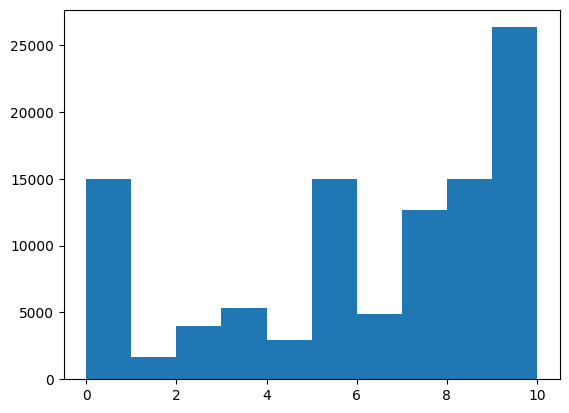

In [ ]:
# Distribution des valeurs de l'utilité
plt.hist(Y)
plt.show()

In [ ]:
Y.value_counts()

0     15000
10    15000
5     15000
8     15000
7     12636
9     11328
3      5323
6      4891
2      3976
4      2907
1      1676
Name: helpful, dtype: int64

In [ ]:
# split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,shuffle=True,random_state=1)

In [ ]:
reviews_train_tokens = X_train['reviewText'].apply(lambda line : preprocess_text(line))
reviews_test_tokens = X_test['reviewText'].apply(lambda line : preprocess_text(line))

In [ ]:
title_train_tokens = X_train['title'].apply(lambda line : preprocess_text(line))
title_test_tokens = X_test['title'].apply(lambda line : preprocess_text(line))

### B. Utilisation que du commentaire

#### I. Moyenne des embeddings

In [ ]:
# Calcul de score basé sur le seuillage binaire de l'utilité
def binary_tresholding_score(y_true, y_pred, t = 6):
  return mean([(1 if (y_true[i] < t and y_pred[i] < t) or (y_true[i] >= t and y_pred[i] >= t) else 0) for i in range(len(y_true))])

In [ ]:
# Exécuter les algos en paramètre sur les données en utilisant en plus le score basé sur le seuillage binaire
def run_models_with_binary_tresholding_score(X_train,Y_train,X_test,Y_test,algos):
    for algo_name in algos:
        model=algos[algo_name]
        model.fit(X_train,Y_train)
        prediction=model.predict(X_test)
        prediction[prediction<1]=1
        prediction[prediction>10]=10
        MAE=mean_absolute_error(Y_test,prediction)
        ACC=accuracy_score(Y_test,np.round(prediction))
        CACC=customized_accuracy(Y_test,np.round(prediction),2)
        BTS=binary_tresholding_score(Y_test,np.round(prediction))
        
        print('################## {0} #############'.format(algo_name))
        print('MAE = {0:.3f}, Accuracy = {1:.3f}, Customized Accuracy = {2:.3f}, Binary Thresholding Score = {3:.3f}'.format(MAE,ACC, CACC, BTS))
        display(confusion_matrix(Y_test,np.round(prediction)))
        print()

In [ ]:
# Calcul de de l'embedding des phrases
vector_size=model_google_vec_neg_300.vector_size
corpus_train_wv_google=word2vec_generator(reviews_train_tokens,model_google_vec_neg_300,vector_size)
corpus_test_wv_google=word2vec_generator(reviews_test_tokens,model_google_vec_neg_300,vector_size)

In [ ]:
# Modèles
algos = {
  'RF' : RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1),
  'KNN' : KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine'),
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=800,random_state=1,alpha=0.001)
}

In [ ]:
run_models_with_binary_tresholding_score(corpus_train_wv_google, y_train, corpus_test_wv_google, y_test.to_numpy(), algos)

################## RF #############
MAE = 2.705, Accuracy = 0.106, Customized Accuracy = 0.507, Binary Thresholding Score = 0.613


array([[   0,    4,    2,   59,  613, 1245,  854,  310,   25,    0,    0],
       [   0,    1,    0,    2,   56,  142,  128,   36,    2,    0,    0],
       [   0,    1,    0,    8,  110,  248,  297,  125,   14,    0,    0],
       [   0,    0,    0,    4,  113,  349,  367,  177,   17,    0,    0],
       [   0,    0,    0,    4,   50,  147,  228,  117,   13,    0,    0],
       [   0,    0,    1,   24,  351,  933, 1009,  557,   85,    0,    0],
       [   0,    0,    0,    3,   54,  222,  367,  251,   41,    1,    0],
       [   0,    0,    0,   12,  227,  621,  896,  656,   85,    0,    0],
       [   0,    0,    0,   12,  191,  652, 1106,  902,  169,    0,    0],
       [   0,    0,    0,    5,   70,  358,  790,  792,  233,    3,    0],
       [   0,    0,    1,   24,  296,  851, 1024,  676,  129,    0,    0]])


################## KNN #############
MAE = 2.831, Accuracy = 0.118, Customized Accuracy = 0.541, Binary Thresholding Score = 0.583


array([[  0,  19,  48, 113, 202, 391, 657, 779, 660, 235,   8],
       [  0,   0,   1,  10,  26,  56,  98,  84,  70,  22,   0],
       [  0,   2,   7,  19,  46, 132, 167, 207, 161,  61,   1],
       [  0,   5,   1,  17,  51, 124, 241, 291, 220,  75,   2],
       [  0,   0,   2,  10,  24,  65, 124, 172, 121,  40,   1],
       [  0,   6,  23,  59, 146, 348, 618, 816, 703, 235,   6],
       [  0,   1,   2,   7,  32, 103, 186, 256, 269,  81,   2],
       [  0,   1,  12,  32,  99, 246, 516, 692, 675, 220,   4],
       [  0,   0,   8,  26,  97, 248, 550, 930, 854, 315,   4],
       [  0,   3,   1,  15,  48, 160, 390, 646, 698, 282,   8],
       [  0,   8,  15,  54, 153, 324, 545, 829, 779, 284,  10]])


################## MLP #############
MAE = 2.688, Accuracy = 0.106, Customized Accuracy = 0.536, Binary Thresholding Score = 0.621


array([[   0,   50,   88,  210,  501,  733,  848,  572,  108,    2,    0],
       [   0,    9,    5,   20,   54,   91,  122,   55,   11,    0,    0],
       [   0,   10,   20,   42,   93,  185,  236,  194,   23,    0,    0],
       [   0,    9,   12,   46,  105,  222,  327,  258,   48,    0,    0],
       [   0,    4,    4,   16,   33,  120,  198,  156,   25,    3,    0],
       [   0,   24,   50,  117,  275,  604,  907,  828,  153,    2,    0],
       [   0,    4,    6,   18,   56,  133,  312,  342,   66,    2,    0],
       [   0,   10,   24,   63,  155,  413,  835,  812,  178,    7,    0],
       [   0,   11,   23,   61,  152,  402,  923, 1130,  321,    9,    0],
       [   0,    6,    6,   17,   62,  189,  604, 1024,  329,   14,    0],
       [   0,   15,   29,  113,  216,  531,  894,  927,  274,    2,    0]])

##### Courbe d'apprentissage du meilleur modèle

[learning_curve] Training set sizes: [ 8218 26711 45203 63696 82189]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 38.6min finished


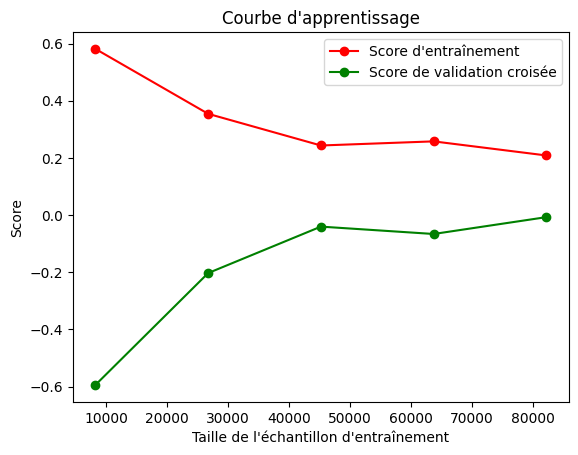

In [ ]:
from sklearn.model_selection import learning_curve

# utiliser la fonction learning_curve
train_sizes, train_scores, test_scores = learning_curve(\
  algos["MLP"], pd.concat([corpus_train_wv_google, corpus_test_wv_google]),\
  pd.concat([y_train, y_test]), verbose=1)

# tracer les courbes d'apprentissage
plt.figure()
plt.title("Courbe d'apprentissage")
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Score")
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', color="g", label="Score de validation croisée")
plt.legend(loc="best")
plt.show()

Il y a suffisament de données.

##### Amélioration du meilleur modèle

In [ ]:
# Plus de neurones
algos = {
  'MLP' : MLPRegressor(hidden_layer_sizes=(40, 20),max_iter=800,random_state=1,alpha=0.001)
}

run_models_with_binary_tresholding_score(corpus_train_wv_google, y_train, corpus_test_wv_google, y_test.to_numpy(), algos)

################## MLP #############
MAE = 2.840, Accuracy = 0.109, Customized Accuracy = 0.532, Binary Thresholding Score = 0.593


array([[  0, 251, 151, 213, 324, 427, 573, 636, 347, 134,  56],
       [  0,  24,   9,  20,  41,  71, 100,  68,  25,   6,   3],
       [  0,  42,  27,  37,  69, 118, 207, 206,  74,  15,   8],
       [  0,  48,  30,  46,  89, 137, 249, 273, 118,  30,   7],
       [  0,  21,  13,  13,  30,  94, 136, 169,  69,  12,   2],
       [  0, 129,  76, 144, 232, 367, 689, 783, 395, 107,  38],
       [  0,  25,  17,  31,  55, 101, 227, 298, 139,  34,  12],
       [  0,  80,  44,  94, 142, 290, 579, 766, 390,  84,  28],
       [  0,  91,  45,  83, 143, 341, 631, 973, 583, 118,  24],
       [  0,  38,  30,  39,  88, 178, 414, 759, 549, 125,  31],
       [  0, 142,  71, 136, 202, 317, 568, 829, 532, 158,  46]])

Pas d'amélioration.

In [ ]:
# Moins de neurones
algos = {
  'MLP' : MLPRegressor(hidden_layer_sizes=(10, 5),max_iter=800,random_state=1,alpha=0.001)
}

run_models_with_binary_tresholding_score(corpus_train_wv_google, y_train, corpus_test_wv_google, y_test.to_numpy(), algos)

################## MLP #############
MAE = 2.715, Accuracy = 0.102, Customized Accuracy = 0.519, Binary Thresholding Score = 0.609


array([[  0,  39,  72, 221, 571, 824, 815, 459, 100,  10,   1],
       [  0,   6,  10,  22,  52, 103, 114,  47,  13,   0,   0],
       [  0,   5,  12,  32, 110, 225, 246, 153,  20,   0,   0],
       [  0,   7,  14,  32, 134, 258, 310, 227,  44,   1,   0],
       [  0,   1,   7,  21,  39, 130, 193, 142,  22,   4,   0],
       [  0,  13,  31, 110, 357, 694, 949, 668, 132,   5,   1],
       [  0,   0,   7,  21,  75, 189, 329, 260,  52,   5,   1],
       [  0,   4,  17,  72, 223, 497, 832, 700, 146,   6,   0],
       [  0,   3,  15,  67, 184, 527, 991, 967, 263,  14,   1],
       [  0,   3,   6,  28,  81, 278, 685, 865, 286,  19,   0],
       [  0,   9,  27,  96, 317, 614, 888, 794, 247,   8,   1]])

Pas d'amélioration.

#### II. Prise en compte de la longueur, de la spécificité et de la subjectivité du texte

In [ ]:
# Calcul de la longueur, la spécificité et la subjectivité
df_meta_train=pd.DataFrame([])
df_meta_train['length_text'] = [len(reviews_train_tokens.iloc[i]) for i in range(len(reviews_train_tokens))]
df_meta_train['polarity'] = [polarity_txt(X_train["reviewText"].iloc[i]) for i in range(len(X_train))]
df_meta_train['subjectivity'] = [subj_txt(X_train["reviewText"].iloc[i]) for i in range(len(X_train))]

df_meta_test=pd.DataFrame([])
df_meta_test['length_text'] = [len(reviews_test_tokens.iloc[i]) for i in range(len(reviews_test_tokens))]
df_meta_test['polarity'] = [polarity_txt(X_test["reviewText"].iloc[i]) for i in range(len(X_test))]
df_meta_test['subjectivity'] = [subj_txt(X_test["reviewText"].iloc[i]) for i in range(len(X_test))]

In [ ]:
# Concaténation
corpus_train_wv_google_meta=pd.concat([corpus_train_wv_google,df_meta_train],axis=1)
corpus_test_wv_google_meta=pd.concat([corpus_test_wv_google,df_meta_test],axis=1)

In [ ]:
# Entraînement
algos = {
  'RF' : RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1),
  'KNN' : KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine'),
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=800,random_state=1,alpha=0.001)
}

run_models_with_binary_tresholding_score(corpus_train_wv_google_meta,y_train,corpus_test_wv_google_meta,y_test.to_numpy(),algos)

################## RF #############
MAE = 2.691, Accuracy = 0.103, Customized Accuracy = 0.513, Binary Thresholding Score = 0.619


array([[   0,   16,   10,  105,  705, 1071,  834,  337,   34,    0,    0],
       [   0,    2,    3,    7,   57,  132,  125,   39,    2,    0,    0],
       [   0,    0,    2,   11,  122,  256,  266,  130,   16,    0,    0],
       [   0,    0,    0,   16,  128,  303,  374,  185,   21,    0,    0],
       [   0,    1,    0,    6,   58,  142,  207,  124,   21,    0,    0],
       [   0,    2,    4,   54,  367,  830, 1078,  535,   90,    0,    0],
       [   0,    0,    0,    8,   55,  184,  381,  267,   44,    0,    0],
       [   0,    1,    0,   14,  204,  601,  921,  648,  108,    0,    0],
       [   0,    0,    0,   21,  187,  611, 1114,  914,  183,    2,    0],
       [   0,    0,    0,    3,   62,  311,  805,  814,  253,    3,    0],
       [   0,    2,    2,   31,  362,  761,  986,  700,  157,    0,    0]])


################## KNN #############
MAE = 2.805, Accuracy = 0.108, Customized Accuracy = 0.516, Binary Thresholding Score = 0.586


array([[  0,  59, 146, 273, 493, 610, 630, 554, 260,  81,   6],
       [  0,   4,  11,  33,  57,  73,  72,  71,  38,   8,   0],
       [  0,   5,  24,  54, 108, 155, 219, 141,  84,  12,   1],
       [  0,   5,  31,  55, 107, 185, 249, 238, 125,  29,   3],
       [  0,   3,   8,  19,  70,  99, 146, 128,  68,  18,   0],
       [  0,  23,  61, 166, 345, 526, 681, 667, 380, 106,   5],
       [  0,   2,  10,  29,  87, 168, 202, 238, 161,  40,   2],
       [  0,  19,  34, 115, 233, 436, 585, 579, 384, 109,   3],
       [  0,  16,  47,  99, 235, 449, 713, 764, 547, 155,   7],
       [  0,   2,  11,  58, 135, 274, 491, 593, 488, 193,   6],
       [  0,  26,  63, 166, 309, 468, 677, 663, 443, 175,  11]])


################## MLP #############
MAE = 2.710, Accuracy = 0.102, Customized Accuracy = 0.536, Binary Thresholding Score = 0.618


array([[   0,  151,  139,  267,  445,  552,  786,  640,  106,   17,    9],
       [   0,    9,   12,   25,   50,   94,  119,   48,    9,    1,    0],
       [   0,   19,   17,   55,   90,  180,  275,  146,   18,    2,    1],
       [   0,   26,   15,   55,  101,  206,  336,  262,   23,    3,    0],
       [   0,    7,   14,   15,   36,  118,  187,  161,   17,    4,    0],
       [   0,   56,   56,  143,  260,  571,  937,  813,  109,   13,    2],
       [   0,   11,   11,   19,   55,  124,  319,  349,   49,    1,    1],
       [   0,   28,   36,   79,  157,  402,  820,  864,  107,    3,    1],
       [   0,   33,   31,   59,  142,  397,  944, 1212,  204,    8,    2],
       [   0,   16,   16,   29,   59,  175,  645, 1091,  209,   10,    1],
       [   0,   55,   67,  141,  242,  419,  813, 1039,  208,   12,    5]])

Il y a amélioration du Random Forest et du KNN mais pas du MLP.

#### III. Prise en compte de l'ordre des mots (LSTM)

In [ ]:
word2idx = {word: idx for idx, word in enumerate(model_google_vec_neg_300.index_to_key)}
X_train_sequences = [to_sequence(word2idx, x) for x in reviews_train_tokens]
X_test_sequences = [to_sequence(word2idx, x) for x in  reviews_test_tokens]

print(reviews_train_tokens.values[0])
print(X_train_sequences[0])

['normal', 'bag', 'star', 'kirbi', 'lot', 'associ', 'rip', 'off', 'scam', 'kirbi', 'rep', 'come', 'hous', 'beat', 'old', 'ladi', 'fork', 'thousand', 'dollar', 'prei', 'hard', 'work', 'innoc', 'peopl', 'bui', 'junk', 'don', 'start', 'stai', 'awai', 'kirbi', 'trust', 'me']
[1845, 3621, 948, 235, 2540857, 14175, 104, 8712, 15008, 216, 737810, 747, 154, 1957165, 18318, 4583, 1075, 387, 141, 496260, 972514, 10106, 19599, 284, 2071, 170]


In [ ]:
from keras.utils import pad_sequences

MAX_SEQ_LENGHT=50
N_FEATURES = len(model_google_vec_neg_300.index_to_key)
X_train_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
X_test_sequences = pad_sequences(X_test_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
print(X_train_sequences[0])

[3000000 3000000 3000000 3000000 3000000 3000000 3000000 3000000 3000000
 3000000 3000000 3000000 3000000 3000000 3000000 3000000 3000000 3000000
 3000000 3000000 3000000 3000000 3000000 3000000    1845    3621     948
     235 2540857   14175     104    8712   15008     216  737810     747
     154 1957165   18318    4583    1075     387     141  496260  972514
   10106   19599     284    2071     170]


In [ ]:
EMBEDDINGS_LEN = model_google_vec_neg_300.vector_size
embeddings_index = np.zeros((len(model_google_vec_neg_300.index_to_key)+1, EMBEDDINGS_LEN))
embeddings_index.shape

(3000001, 300)

In [ ]:
for word, idx in word2idx.items():
    try:
        embedding = model_google_vec_neg_300[word]
        embeddings_index[idx] = embedding
    except:
        pass
      
print("EMBEDDINGS_LEN=", EMBEDDINGS_LEN)

EMBEDDINGS_LEN= 300


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Dense,LSTM


model_lstm = Sequential()
model_lstm.add(Embedding(len(model_google_vec_neg_300.key_to_index)+1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    trainable=False))

model_lstm.add(LSTM(300, dropout=0.2))

model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 300)         900000300 
                                                                 
 lstm_4 (LSTM)               (None, 300)               721200    
                                                                 
 dense_4 (Dense)             (None, 1)                 301       
                                                                 
Total params: 900,721,801
Trainable params: 721,501
Non-trainable params: 900,000,300
_________________________________________________________________


In [ ]:
history = model_lstm.fit(X_train_sequences, y_train, epochs=10, batch_size=128, verbose=1,validation_split=0.1)

Epoch 1/10
578/578 [==============================] - 82s 139ms/step - loss: 2.6444 - mean_absolute_error: 2.6444 - val_loss: 2.5889 - val_mean_absolute_error: 2.5889
Epoch 2/10
578/578 [==============================] - 80s 138ms/step - loss: 2.5884 - mean_absolute_error: 2.5884 - val_loss: 2.5774 - val_mean_absolute_error: 2.5774
Epoch 3/10
578/578 [==============================] - 80s 138ms/step - loss: 2.5792 - mean_absolute_error: 2.5792 - val_loss: 2.5792 - val_mean_absolute_error: 2.5792
Epoch 4/10
578/578 [==============================] - 80s 139ms/step - loss: 2.5678 - mean_absolute_error: 2.5678 - val_loss: 2.5792 - val_mean_absolute_error: 2.5792
Epoch 5/10
578/578 [==============================] - 80s 139ms/step - loss: 2.5598 - mean_absolute_error: 2.5598 - val_loss: 2.5707 - val_mean_absolute_error: 2.5707
Epoch 6/10
578/578 [==============================] - 78s 136ms/step - loss: 2.5525 - mean_absolute_error: 2.5525 - val_loss: 2.5700 - val_mean_absolute_error: 2.570

In [ ]:
scores_lstm = model_lstm.evaluate(X_test_sequences, y_test, verbose=1)

643/643 [==============================] - 16s 24ms/step - loss: 2.6339 - mean_absolute_error: 2.6339


In [ ]:
prediction=model_lstm.predict(X_test_sequences)
prediction[prediction<1]=1
prediction[prediction>10]=10
ACC=accuracy_score(y_test,np.round(prediction))
MAE=mean_absolute_error(y_test,prediction)
CACC=customized_accuracy(y_test.to_numpy(), np.round(prediction))
BTS=binary_tresholding_score(y_test.to_numpy(),np.round(prediction))
print('For LSTM MAE = {0:.3f}, Accuracy = {1:.3f}, Customized Accuracy = {2:.3f}, Binary Thresholding Score = {3:.3f}'.format(MAE,ACC,CACC,BTS))
display(confusion_matrix(y_test,np.round(prediction)))

643/643 [==============================] - 16s 24ms/step
For LSTM MAE = 2.633, Accuracy = 0.124, Customized Accuracy = 0.355, Binary Thresholding Score = 0.631


array([[   0,  156,  180,  268,  454,  589,  540,  609,  313,    3,    0],
       [   0,    7,   13,   24,   50,   92,   75,   80,   26,    0,    0],
       [   0,   16,   32,   38,   92,  173,  151,  214,   87,    0,    0],
       [   0,   11,   34,   48,  105,  208,  209,  264,  148,    0,    0],
       [   0,    8,   11,   22,   36,  105,  122,  178,   77,    0,    0],
       [   0,   59,   83,  153,  301,  471,  511,  856,  519,    7,    0],
       [   0,    3,   14,   22,   50,  123,  169,  331,  226,    1,    0],
       [   0,   21,   44,   79,  159,  346,  453,  839,  550,    6,    0],
       [   0,   20,   33,   78,  153,  308,  478, 1026,  925,   11,    0],
       [   0,    8,   13,   23,   56,  137,  273,  781,  941,   19,    0],
       [   0,   48,   57,  127,  246,  416,  479,  834,  783,   11,    0]])

Petite amélioration.

#### IV. Utilisation de la sortie du LSTM dans d'autres modèles seupervisés

In [ ]:
from keras.models import Model
Model_rf = Model(inputs=model_lstm.inputs, outputs=model_lstm.layers[1].output)
#Model_rf.save('../models/model_lstm_features.h5')
corpus_train_lstm = Model_rf.predict(X_train_sequences)
corpus_test_lstm = Model_rf.predict(X_test_sequences)

643/643 [==============================] - 16s 24ms/step


In [ ]:
algos = {
  'RF' : RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1),
  'KNN' : KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine'),
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=800,random_state=1,alpha=0.001)
}

run_models_with_binary_tresholding_score(corpus_train_lstm,y_train,corpus_test_lstm,y_test.to_numpy(),algos)

################## RF #############
MAE = 2.700, Accuracy = 0.100, Customized Accuracy = 0.524, Binary Thresholding Score = 0.617


array([[   0,   38,   89,  192,  529,  923,  845,  427,   69,    0,    0],
       [   0,    2,    0,   23,   55,  126,  109,   48,    4,    0,    0],
       [   0,    4,    7,   50,  105,  223,  261,  134,   18,    1,    0],
       [   0,    5,   11,   49,  125,  267,  343,  202,   24,    1,    0],
       [   0,    3,    5,    9,   60,  144,  177,  134,   27,    0,    0],
       [   0,   14,   32,  113,  359,  705,  977,  644,  115,    1,    0],
       [   0,    0,    4,    9,   73,  177,  321,  295,   59,    1,    0],
       [   0,    2,   17,   45,  220,  559,  846,  674,  132,    2,    0],
       [   0,    2,   15,   52,  187,  512, 1060,  968,  231,    5,    0],
       [   0,    1,    5,   19,   73,  259,  735,  889,  268,    2,    0],
       [   0,   12,   24,   90,  304,  643,  904,  793,  230,    1,    0]])


################## KNN #############
MAE = 2.833, Accuracy = 0.105, Customized Accuracy = 0.512, Binary Thresholding Score = 0.584


array([[  0, 107, 161, 300, 438, 596, 610, 530, 278,  87,   5],
       [  0,   5,  11,  25,  65,  74,  78,  62,  34,  13,   0],
       [  0,  10,  26,  67, 113, 134, 182, 155,  91,  24,   1],
       [  0,  16,  23,  71, 123, 195, 237, 208, 123,  29,   2],
       [  0,   6,  18,  30,  53,  98, 136, 129,  74,  15,   0],
       [  0,  45,  84, 202, 354, 525, 632, 615, 361, 135,   7],
       [  0,   5,  10,  43,  69, 170, 226, 220, 148,  47,   1],
       [  0,  23,  46, 121, 254, 434, 557, 544, 391, 124,   3],
       [  0,  24,  59, 115, 249, 450, 681, 724, 525, 196,   9],
       [  0,  14,  26,  51, 134, 307, 461, 591, 482, 175,  10],
       [  0,  43,  74, 170, 311, 497, 611, 667, 436, 187,   5]])


################## MLP #############
MAE = 2.703, Accuracy = 0.105, Customized Accuracy = 0.548, Binary Thresholding Score = 0.617


array([[   0,  187,  110,  190,  295,  626,  832,  698,  107,   23,   44],
       [   0,   11,   10,   11,   46,   85,  107,   87,    6,    1,    3],
       [   0,   30,   17,   40,   70,  158,  229,  221,   32,    3,    3],
       [   0,   23,   20,   34,   91,  183,  314,  309,   41,    5,    7],
       [   0,   14,    8,   13,   21,  101,  172,  195,   31,    1,    3],
       [   0,   85,   51,  111,  212,  490,  854,  961,  167,   14,   15],
       [   0,    6,   15,   20,   28,  122,  250,  433,   60,    2,    3],
       [   0,   43,   28,   62,  122,  346,  721,  997,  167,    4,    7],
       [   0,   28,   21,   60,  109,  340,  769, 1375,  316,    6,    8],
       [   0,   11,   11,   14,   58,  145,  442, 1234,  323,    9,    4],
       [   0,   75,   38,   77,  159,  446,  797, 1109,  264,   23,   13]])

Pas d'amélioration.

### C. Utilisation du commentaire et du titre du produit

#### I. Moyenne des embeddings

In [ ]:
vector_size=model_google_vec_neg_300.vector_size

reviews_train_wv_google=word2vec_generator(reviews_train_tokens,model_google_vec_neg_300,vector_size)
reviews_test_wv_google=word2vec_generator(reviews_test_tokens,model_google_vec_neg_300,vector_size)

title_train_wv_google=word2vec_generator(title_train_tokens,model_google_vec_neg_300,vector_size)
title_test_wv_google=word2vec_generator(title_test_tokens,model_google_vec_neg_300,vector_size)

# renommage des colonnes de titles...
title_train_wv_google.columns = ["t" + str(c) for c in title_train_wv_google.columns]
title_test_wv_google.columns = ["t" + str(c) for c in title_test_wv_google.columns]

In [ ]:
rev_a_title_train_wv_google = pd.concat([reviews_train_wv_google, title_train_wv_google], axis=1)
rev_a_title_test_wv_google = pd.concat([reviews_test_wv_google, title_test_wv_google], axis=1)

rev_a_title_train_wv_google.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23,t24,t25,t26,t27,t28,t29,t30,t31,t32,t33,t34,t35,t36,t37,t38,t39,t40,t41,t42,t43,t44,t45,t46,t47,t48,t49,t50,t51,t52,t53,t54,t55,t56,t57,t58,t59,t60,t61,t62,t63,t64,t65,t66,t67,t68,t69,t70,t71,t72,t73,t74,t75,t76,t77,t78,t79,t80,t81,t82,t83,t84,t85,t86,t87,t88,t89,t90,t91,t92,t93,t94,t95,t96,t97,t98,t99,t100,t101,t102,t103,t104,t105,t106,t107,t108,t109,t110,t111,t112,t113,t114,t115,t116,t117,t118,t119,t120,t121,t122,t123,t124,t125,t126,t127,t128,t129,t130,t131,t132,t133,t134,t135,t136,t137,t138,t139,t140,t141,t142,t143,t144,t145,t146,t147,t148,t149,t150,t151,t152,t153,t154,t155,t156,t157,t158,t159,t160,t161,t162,t163,t164,t165,t166,t167,t168,t169,t170,t171,t172,t173,t174,t175,t176,t177,t178,t179,t180,t181,t182,t183,t184,t185,t186,t187,t188,t189,t190,t191,t192,t193,t194,t195,t196,t197,t198,t199,t200,t201,t202,t203,t204,t205,t206,t207,t208,t209,t210,t211,t212,t213,t214,t215,t216,t217,t218,t219,t220,t221,t222,t223,t224,t225,t226,t227,t228,t229,t230,t231,t232,t233,t234,t235,t236,t237,t238,t239,t240,t241,t242,t243,t244,t245,t246,t247,t248,t249,t250,t251,t252,t253,t254,t255,t256,t257,t258,t259,t260,t261,t262,t263,t264,t265,t266,t267,t268,t269,t270,t271,t272,t273,t274,t275,t276,t277,t278,t279,t280,t281,t282,t283,t284,t285,t286,t287,t288,t289,t290,t291,t292,t293,t294,t295,t296,t297,t298,t299
0,0.051895,0.037328,-0.034177,0.101743,-0.058414,0.054615,-0.041165,-0.046734,0.038159,0.087764,0.003641,-0.067222,-0.049265,0.003996,-0.131833,0.101383,0.028708,0.075796,-0.012462,-0.011240,0.008695,0.041100,0.084000,0.001998,0.057393,-0.026329,-0.040030,0.017978,0.063161,-0.043544,-0.017762,0.047229,0.000327,-0.043785,0.012311,-0.032266,0.040161,0.030547,0.010000,0.101680,0.085920,-0.113623,0.134226,-0.021433,-0.023916,-0.075753,-0.078853,-0.009371,0.002723,0.022405,-0.005610,0.115219,0.019362,-0.019095,0.001305,-0.028062,-0.047248,-0.083741,0.019699,-0.085840,-0.016829,0.037920,-0.076820,-0.002485,0.009050,-0.073896,-0.065966,0.052086,0.028344,0.036428,0.041802,0.028025,0.055240,-0.009629,-0.161032,-0.020440,0.031243,0.071313,-0.021661,-0.021817,-0.086409,-0.039698,0.012998,0.000663,-0.056211,-0.004524,-0.060419,0.085980,0.031487,0.028893,-0.004157,0.061732,-0.068722,-0.113466,-0.067157,-0.034516,0.039504,0.064622,0.074289,-0.057171,-0.075850,-0.036300,0.065043,-0.015186,0.010391,-0.045006,0.004535,-0.006627,0.064333,-0.068010,-0.052673,-0.007005,-0.006933,-0.014125,0.090703,0.041767,0.017151,-0.055764,0.012064,0.042873,0.007832,0.009667,-0.078502,0.091327,0.053238,0.028802,-0.009848,-0.019586,0.058703,0.018897,-0.067695,-0.079420,-0.035956,-0.004591,-0.036042,0.023869,0.018929,0.004610,-0.018475,0.058678,0.056634,-0.106849,0.048059,0.013481,-0.016872,0.022587,-0.035953,-0.055542,-0.026154,-0.079539,0.086903,-0.038297,-0.048888,0.093569,-0.066556,-0.000924,-0.093473,-0.054987,-0.037182,-0.04

In [ ]:
algos = {
  'RF' : RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1),
  'KNN' : KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine'),
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=800,random_state=1,alpha=0.001)
}

run_models_with_binary_tresholding_score(rev_a_title_train_wv_google, y_train, rev_a_title_test_wv_google, y_test.to_numpy(), algos)

################## RF #############
MAE = 2.712, Accuracy = 0.104, Customized Accuracy = 0.511, Binary Thresholding Score = 0.610


array([[   0,    0,    4,   68,  558, 1213,  942,  306,   21,    0,    0],
       [   0,    0,    1,    3,   47,  151,  114,   45,    6,    0,    0],
       [   0,    0,    2,    6,  103,  269,  288,  120,   15,    0,    0],
       [   0,    0,    0,    6,   94,  345,  378,  185,   19,    0,    0],
       [   0,    0,    0,    5,   46,  157,  232,  105,   14,    0,    0],
       [   0,    0,    1,   30,  300,  944, 1085,  531,   69,    0,    0],
       [   0,    0,    0,    6,   43,  225,  395,  237,   33,    0,    0],
       [   0,    0,    0,   10,  165,  705,  935,  596,   86,    0,    0],
       [   0,    0,    0,    4,  158,  638, 1186,  906,  140,    0,    0],
       [   0,    0,    0,    2,   63,  357,  837,  796,  195,    1,    0],
       [   0,    0,    0,   13,  258,  896, 1068,  643,  123,    0,    0]])


################## KNN #############
MAE = 2.897, Accuracy = 0.103, Customized Accuracy = 0.500, Binary Thresholding Score = 0.558


array([[  0,  33,  58, 154, 362, 565, 747, 646, 410, 132,   5],
       [  0,   1,   3,   7,  34,  69,  89,  86,  65,  11,   2],
       [  0,   2,   9,  31,  67, 143, 207, 219,  89,  33,   3],
       [  0,   3,   7,  38,  85, 167, 272, 248, 166,  39,   2],
       [  0,   2,   3,  15,  45,  92, 152, 152,  76,  22,   0],
       [  0,   5,  25, 110, 269, 507, 740, 730, 453, 119,   2],
       [  0,   1,  12,  24,  85, 149, 233, 228, 162,  44,   1],
       [  0,   7,  21,  60, 187, 384, 673, 659, 396, 107,   3],
       [  0,   4,  24,  83, 212, 495, 723, 849, 486, 153,   3],
       [  0,   3,  16,  59, 140, 329, 541, 601, 427, 133,   2],
       [  0,   6,  39,  97, 244, 481, 723, 764, 491, 149,   7]])


################## MLP #############
MAE = 2.927, Accuracy = 0.097, Customized Accuracy = 0.503, Binary Thresholding Score = 0.573


array([[  0, 237, 171, 291, 386, 487, 554, 497, 308, 123,  58],
       [  0,  19,  12,  27,  32,  81,  84,  77,  21,  10,   4],
       [  0,  36,  28,  51, 103, 159, 167, 163,  68,  20,   8],
       [  0,  31,  29,  55, 123, 186, 248, 200, 123,  27,   5],
       [  0,  13,  16,  25,  68, 104, 144, 116,  47,  22,   4],
       [  0, 105, 116, 206, 309, 468, 628, 642, 353,  93,  40],
       [  0,  18,  18,  57,  73, 146, 221, 246, 113,  45,   2],
       [  0,  60,  71, 137, 236, 408, 586, 559, 309,  96,  35],
       [  0,  74,  68, 128, 266, 412, 726, 784, 422, 122,  30],
       [  0,  34,  43,  85, 149, 295, 477, 615, 425, 107,  21],
       [  0, 105,  97, 186, 318, 431, 581, 682, 423, 124,  54]])

Les performances sont inférieurs par rapport à son équivalent dans la partie précédente.

##### Courbe d'apprentissage du meilleur modèle

[learning_curve] Training set sizes: [ 8218 26711 45203 63696 82189]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 113.0min finished


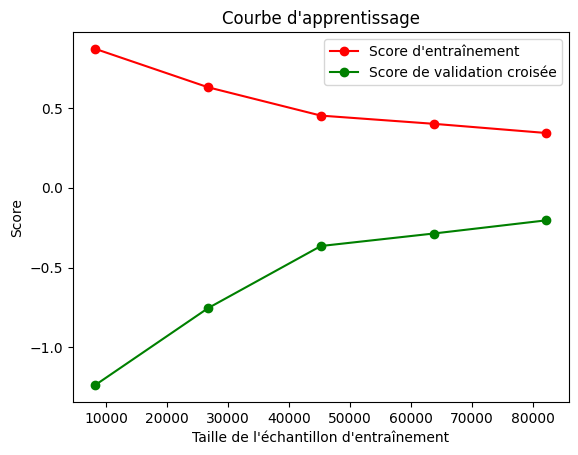

In [ ]:
# utiliser la fonction learning_curve
train_sizes, train_scores, test_scores = learning_curve(\
  algos["MLP"], pd.concat([rev_a_title_train_wv_google, rev_a_title_test_wv_google]),\
  pd.concat([y_train, y_test]), verbose=1)

# tracer les courbes d'apprentissage
plt.figure()
plt.title("Courbe d'apprentissage")
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Score")
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', color="g", label="Score de validation croisée")
plt.legend(loc="best")
plt.show()

##### Amélioration du meilleur modèle

In [ ]:
# Moins de neurones
algos = {
  'MLP' : MLPRegressor(hidden_layer_sizes=(10, 5),max_iter=800,random_state=1,alpha=0.001)
}

run_models_with_binary_tresholding_score(rev_a_title_train_wv_google, y_train, rev_a_title_test_wv_google, y_test.to_numpy(), algos)

################## MLP #############
MAE = 2.775, Accuracy = 0.102, Customized Accuracy = 0.519, Binary Thresholding Score = 0.592


array([[   0,   96,  111,  191,  380,  684,  860,  599,  174,   15,    2],
       [   0,   10,    8,   12,   43,   80,  109,   71,   30,    4,    0],
       [   0,   16,   17,   30,   79,  155,  267,  178,   52,    7,    2],
       [   0,   11,   21,   37,   81,  195,  345,  265,   65,    6,    1],
       [   0,    7,   13,   14,   43,  100,  188,  150,   37,    7,    0],
       [   0,   48,   60,  101,  272,  501,  948,  800,  205,   23,    2],
       [   0,    8,   12,   27,   51,  154,  307,  284,   84,   10,    2],
       [   0,   16,   23,   67,  188,  390,  792,  770,  225,   21,    5],
       [   0,   22,   30,   59,  175,  405,  924, 1008,  370,   37,    2],
       [   0,   11,    9,   26,   90,  277,  622,  833,  345,   37,    1],
       [   0,   36,   66,  118,  220,  488,  861,  878,  297,   37,    0]])

Petite amélioration

In [ ]:
# Plus de neurones
algos = {
  'MLP' : MLPRegressor(hidden_layer_sizes=(40, 20),max_iter=800,random_state=1,alpha=0.001)
}

run_models_with_binary_tresholding_score(rev_a_title_train_wv_google, y_train, rev_a_title_test_wv_google, y_test.to_numpy(), algos)

################## MLP #############
MAE = 3.068, Accuracy = 0.110, Customized Accuracy = 0.506, Binary Thresholding Score = 0.571


array([[  0, 418, 147, 187, 253, 322, 394, 504, 435, 257, 195],
       [  0,  27,  22,  20,  35,  52,  57,  75,  50,  19,  10],
       [  0,  68,  28,  50,  75, 114, 140, 141, 110,  47,  30],
       [  0,  84,  41,  53,  93, 126, 160, 195, 156,  77,  42],
       [  0,  28,  20,  31,  45,  71, 101, 114,  90,  36,  23],
       [  0, 245, 113, 172, 191, 309, 462, 571, 487, 266, 144],
       [  0,  52,  24,  52,  63,  88, 159, 208, 175,  87,  31],
       [  0, 148,  69, 123, 161, 271, 405, 544, 420, 230, 126],
       [  0, 152,  86, 118, 199, 285, 459, 638, 615, 331, 149],
       [  0,  85,  42,  66, 117, 190, 343, 523, 481, 281, 123],
       [  0, 264, 108, 137, 222, 295, 407, 558, 500, 318, 192]])

Petite amélioration aussi

#### II. Prise en compte de la longueur, de la spécificité et de la subjectivité du texte

In [ ]:
# Calcul de la longueur, la spécificité et la subjectivité
df_meta_train=pd.DataFrame([])
df_meta_train['length_text'] = [len(reviews_train_tokens.iloc[i]) for i in range(len(reviews_train_tokens))]
df_meta_train['polarity'] = [polarity_txt(X_train["reviewText"].iloc[i]) for i in range(len(X_train))]
df_meta_train['subjectivity'] = [subj_txt(X_train["reviewText"].iloc[i]) for i in range(len(X_train))]

df_meta_test=pd.DataFrame([])
df_meta_test['length_text'] = [len(reviews_test_tokens.iloc[i]) for i in range(len(reviews_test_tokens))]
df_meta_test['polarity'] = [polarity_txt(X_test["reviewText"].iloc[i]) for i in range(len(X_test))]
df_meta_test['subjectivity'] = [subj_txt(X_test["reviewText"].iloc[i]) for i in range(len(X_test))]

In [ ]:
# Concaténation
corpus_train_wv_google_meta=pd.concat([reviews_train_wv_google,title_train_wv_google,df_meta_train],axis=1)
corpus_test_wv_google_meta=pd.concat([reviews_test_wv_google,title_test_wv_google,df_meta_test],axis=1)

In [ ]:
# Entraînement et évaluation
algos = {
  'RF' : RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1),
  'KNN' : KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine'),
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=800,random_state=1,alpha=0.001)
}

run_models_with_binary_tresholding_score(corpus_train_wv_google_meta,y_train,corpus_test_wv_google_meta,y_test.to_numpy(),algos)

################## RF #############
MAE = 2.686, Accuracy = 0.100, Customized Accuracy = 0.514, Binary Thresholding Score = 0.623


array([[   0,   20,    9,  110,  698, 1050,  840,  340,   45,    0,    0],
       [   0,    3,    1,    5,   59,  133,  128,   34,    4,    0,    0],
       [   0,    1,    1,    9,  111,  264,  282,  128,    7,    0,    0],
       [   0,    0,    1,   14,  117,  331,  367,  176,   21,    0,    0],
       [   0,    0,    1,    5,   53,  167,  198,  126,    9,    0,    0],
       [   0,    3,    1,   44,  388,  839, 1049,  542,   94,    0,    0],
       [   0,    0,    0,    8,   63,  201,  367,  263,   37,    0,    0],
       [   0,    0,    2,   14,  218,  590,  976,  599,   98,    0,    0],
       [   0,    0,    0,   23,  191,  572, 1094,  968,  181,    3,    0],
       [   0,    0,    0,    5,   59,  283,  829,  834,  240,    1,    0],
       [   0,    1,    0,   36,  328,  753, 1043,  707,  133,    0,    0]])


################## KNN #############
MAE = 2.805, Accuracy = 0.112, Customized Accuracy = 0.520, Binary Thresholding Score = 0.587


array([[  0,  68, 131, 236, 417, 586, 640, 591, 326, 112,   5],
       [  0,   7,   7,  23,  37,  58,  86,  84,  50,  14,   1],
       [  0,   2,  15,  38, 102, 163, 171, 186, 102,  23,   1],
       [  0,   4,  14,  37, 104, 187, 241, 227, 169,  44,   0],
       [  0,   0,   8,  15,  50, 103, 137, 147,  73,  24,   2],
       [  0,  22,  54, 129, 264, 524, 694, 660, 479, 127,   7],
       [  0,   4,  15,  26,  77, 151, 217, 231, 171,  45,   2],
       [  0,   6,  41,  74, 188, 384, 575, 635, 483, 109,   2],
       [  0,  12,  25,  87, 201, 409, 687, 803, 626, 178,   4],
       [  0,   3,  10,  35, 115, 251, 493, 634, 531, 173,   6],
       [  0,  22,  53, 128, 277, 476, 641, 711, 526, 158,   9]])


################## MLP #############
MAE = 2.808, Accuracy = 0.102, Customized Accuracy = 0.525, Binary Thresholding Score = 0.605


array([[  0, 320, 201, 246, 359, 580, 607, 477, 200,  73,  49],
       [  0,  19,  13,  31,  48,  81,  86,  64,  13,   7,   5],
       [  0,  33,  36,  61,  94, 164, 196, 161,  41,   9,   8],
       [  0,  56,  32,  67, 115, 187, 248, 223,  73,  14,  12],
       [  0,  17,  14,  21,  55, 124, 151, 134,  32,   7,   4],
       [  0, 141, 127, 174, 314, 541, 736, 644, 208,  42,  33],
       [  0,  29,  15,  39,  75, 156, 272, 270,  70,  11,   2],
       [  0,  71,  59, 113, 215, 403, 674, 685, 214,  40,  23],
       [  0,  62,  52,  97, 219, 428, 788, 995, 322,  42,  27],
       [  0,  30,  23,  41, 113, 252, 529, 850, 344,  52,  17],
       [  0, 142,  84, 127, 282, 427, 708, 778, 338,  64,  51]])

Petite amélioration du random forest et du KNN par rapport à leurs équivalent dans la partie précédente.

#### III. Prise en compte de l'ordre des mots (LSTM)

In [ ]:
# Concaténation des reviews et des titres
title_reviews_train_tokens = pd.Series([title_train_tokens[i] + reviews_train_tokens[i] for i in reviews_train_tokens.index])
title_reviews_test_tokens = pd.Series([title_test_tokens[i] + reviews_test_tokens[i] for i in reviews_test_tokens.index])

In [ ]:
X_train_sequences = [to_sequence(word2idx, x) for x in title_reviews_train_tokens]
X_test_sequences = [to_sequence(word2idx, x) for x in  title_reviews_test_tokens]

In [ ]:
MAX_SEQ_LENGHT=75
N_FEATURES = len(model_google_vec_neg_300.index_to_key)
X_train_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
X_test_sequences = pad_sequences(X_test_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)

In [ ]:
EMBEDDINGS_LEN = model_google_vec_neg_300.vector_size
embeddings_index = np.zeros((len(model_google_vec_neg_300.index_to_key)+1, EMBEDDINGS_LEN))
embeddings_index.shape

(3000001, 300)

In [ ]:
for word, idx in word2idx.items():
    try:
        embedding = model_google_vec_neg_300[word]
        embeddings_index[idx] = embedding
    except:
        pass
      
print("EMBEDDINGS_LEN=", EMBEDDINGS_LEN)

EMBEDDINGS_LEN= 300


In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(len(model_google_vec_neg_300.key_to_index)+1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    trainable=False))

model_lstm.add(LSTM(300, dropout=0.2))

model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 300)         900000300 
                                                                 
 lstm_5 (LSTM)               (None, 300)               721200    
                                                                 
 dense_5 (Dense)             (None, 1)                 301       
                                                                 
Total params: 900,721,801
Trainable params: 721,501
Non-trainable params: 900,000,300
_________________________________________________________________


In [ ]:
history = model_lstm.fit(X_train_sequences, y_train, epochs=10, batch_size=128, verbose=1,validation_split=0.1)

Epoch 1/10
578/578 [==============================] - 125s 210ms/step - loss: 2.7818 - mean_absolute_error: 2.7818 - val_loss: 2.7625 - val_mean_absolute_error: 2.7625
Epoch 2/10
578/578 [==============================] - 117s 203ms/step - loss: 2.6755 - mean_absolute_error: 2.6755 - val_loss: 2.6016 - val_mean_absolute_error: 2.6016
Epoch 3/10
578/578 [==============================] - 115s 199ms/step - loss: 2.6006 - mean_absolute_error: 2.6006 - val_loss: 2.5851 - val_mean_absolute_error: 2.5851
Epoch 4/10
578/578 [==============================] - 116s 200ms/step - loss: 2.5862 - mean_absolute_error: 2.5862 - val_loss: 2.5968 - val_mean_absolute_error: 2.5968
Epoch 5/10
578/578 [==============================] - 116s 200ms/step - loss: 2.5769 - mean_absolute_error: 2.5769 - val_loss: 2.5898 - val_mean_absolute_error: 2.5898
Epoch 6/10
578/578 [==============================] - 113s 196ms/step - loss: 2.5700 - mean_absolute_error: 2.5700 - val_loss: 2.5715 - val_mean_absolute_error:

In [ ]:
scores_lstm = model_lstm.evaluate(X_test_sequences, y_test, verbose=1)

643/643 [==============================] - 23s 36ms/step - loss: 2.6201 - mean_absolute_error: 2.6201


In [ ]:
prediction=model_lstm.predict(X_test_sequences)
prediction[prediction<1]=1
prediction[prediction>10]=10
ACC=accuracy_score(y_test,np.round(prediction))
MAE=mean_absolute_error(y_test,prediction)
CACC=customized_accuracy(y_test.to_numpy(), np.round(prediction))
BTS=binary_tresholding_score(y_test.to_numpy(),np.round(prediction))
print('For LSTM MAE = {0:.3f}, Accuracy = {1:.3f}, Customized Accuracy = {2:.3f}, Binary Thresholding Score = {3:.3f}'.format(MAE,ACC,CACC,BTS))
display(confusion_matrix(y_test,np.round(prediction)))

643/643 [==============================] - 23s 36ms/step
For LSTM MAE = 2.620, Accuracy = 0.122, Customized Accuracy = 0.348, Binary Thresholding Score = 0.629


array([[   0,   21,   72,  184,  478,  840,  693,  609,  215,    0,    0],
       [   0,    0,    5,   10,   48,  110,  114,   62,   18,    0,    0],
       [   0,    2,    9,   29,   89,  202,  206,  192,   74,    0,    0],
       [   0,    1,    7,   29,   94,  252,  292,  247,  105,    0,    0],
       [   0,    3,    1,   10,   42,  116,  164,  162,   61,    0,    0],
       [   0,   11,   32,   85,  276,  642,  672,  862,  377,    3,    0],
       [   0,    1,    5,    8,   45,  140,  229,  340,  170,    1,    0],
       [   0,    4,    9,   39,  160,  449,  570,  820,  442,    4,    0],
       [   0,    2,    9,   42,  130,  389,  616, 1113,  726,    5,    0],
       [   0,    1,    4,   12,   56,  149,  374,  852,  786,   17,    0],
       [   0,    5,   20,   59,  231,  532,  645,  872,  623,   14,    0]])

Pas d'amélioration par rapport à son équivalent dans la partie précédente.

#### IV. Utilisation de la sortie du LSTM dans d'autres modèles seupervisés

In [ ]:
from keras.models import Model
Model_rf = Model(inputs=model_lstm.inputs, outputs=model_lstm.layers[1].output)
#Model_rf.save('../models/model_lstm_features.h5')
corpus_train_lstm = Model_rf.predict(X_train_sequences)
corpus_test_lstm = Model_rf.predict(X_test_sequences)

643/643 [==============================] - 23s 36ms/step


In [ ]:
algos = {
  'RF' : RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1),
  'KNN' : KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine'),
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=800,random_state=1,alpha=0.001)
}

run_models_with_binary_tresholding_score(corpus_train_lstm,y_train,corpus_test_lstm,y_test.to_numpy(),algos)

################## RF #############
MAE = 2.704, Accuracy = 0.101, Customized Accuracy = 0.517, Binary Thresholding Score = 0.614


array([[   0,    7,   50,  212,  607,  917,  870,  377,   71,    1,    0],
       [   0,    0,    2,   14,   63,  121,  120,   40,    7,    0,    0],
       [   0,    0,    3,   28,  128,  224,  262,  140,   17,    1,    0],
       [   0,    1,    6,   40,  125,  297,  365,  160,   33,    0,    0],
       [   0,    3,    2,    8,   58,  148,  216,  104,   20,    0,    0],
       [   0,    6,   23,  103,  393,  762,  965,  584,  121,    3,    0],
       [   0,    1,    3,   16,   75,  195,  331,  267,   51,    0,    0],
       [   0,    1,    8,   62,  218,  566,  887,  598,  154,    3,    0],
       [   0,    1,    6,   42,  198,  593, 1055,  862,  268,    7,    0],
       [   0,    1,    3,    9,  104,  291,  762,  759,  316,    6,    0],
       [   0,    2,   18,   89,  309,  640,  987,  682,  270,    4,    0]])


################## KNN #############
MAE = 2.841, Accuracy = 0.106, Customized Accuracy = 0.507, Binary Thresholding Score = 0.580


array([[  0,  91, 180, 294, 466, 561, 633, 520, 286,  74,   7],
       [  0,   5,  16,  31,  56,  81,  74,  59,  35,  10,   0],
       [  0,  16,  28,  64,  97, 165, 181, 147,  84,  20,   1],
       [  0,   9,  33,  70, 136, 188, 227, 196, 138,  28,   2],
       [  0,   4,  10,  31,  68, 109, 129, 121,  67,  20,   0],
       [  0,  39,  98, 218, 386, 542, 634, 570, 345, 125,   3],
       [  0,   3,  20,  41,  97, 177, 207, 207, 127,  58,   2],
       [  0,  19,  61, 122, 282, 419, 530, 548, 409, 103,   4],
       [  0,  22,  54, 140, 242, 492, 635, 717, 520, 206,   4],
       [  0,   4,  27,  66, 159, 315, 482, 553, 453, 182,  10],
       [  0,  32,  87, 198, 293, 519, 613, 603, 468, 178,  10]])


################## MLP #############
MAE = 2.659, Accuracy = 0.106, Customized Accuracy = 0.541, Binary Thresholding Score = 0.626


array([[   0,   25,   85,  132,  424,  924,  962,  499,   56,    5,    0],
       [   0,    5,    2,    7,   47,  122,  130,   49,    5,    0,    0],
       [   0,    2,    9,   18,   92,  223,  268,  169,   21,    1,    0],
       [   0,    1,    5,   27,   88,  272,  362,  237,   34,    0,    1],
       [   0,    1,    5,   15,   32,  130,  195,  162,   19,    0,    0],
       [   0,   13,   37,   64,  239,  692, 1018,  784,  111,    2,    0],
       [   0,    0,    4,    8,   42,  162,  324,  344,   55,    0,    0],
       [   0,   11,   10,   29,  137,  466,  867,  834,  140,    2,    1],
       [   0,    4,   11,   37,  115,  425,  981, 1207,  251,    1,    0],
       [   0,    3,    7,    5,   53,  180,  612, 1071,  320,    0,    0],
       [   0,    3,   26,   53,  203,  605,  942,  938,  228,    3,    0]])

Pas d'amélioration par rapport à leurs équivalents de la partie précédente.

## 4. Modèle qui prédit et la note et l'utilité

### A. Préparation du corpus et des labels

#### I. Sélection d'un sous ensemble des données mieux équilibrer pour les deux labels

In [ ]:
def data_sample_by_helpful_and_balanced_note(data, n, helpful):
  tmp_data = data[data["helpful"] == helpful]
  nb_note = df['overall'].unique().shape[0]
  tmp_data = pd.concat([data_sample_by_note(tmp_data, n // nb_note, i) for i in df['overall'].unique()])
  return tmp_data

In [ ]:
nb_line_per_category = 20000

In [ ]:
# dataset utilisé pour la prédiction de l'utilité
ho_df = pd.concat([data_sample_by_helpful_and_balanced_note(df, nb_line_per_category, i) for i in df['helpful'].unique()])
# Vérification de la taille
ho_df.shape

(104576, 10)

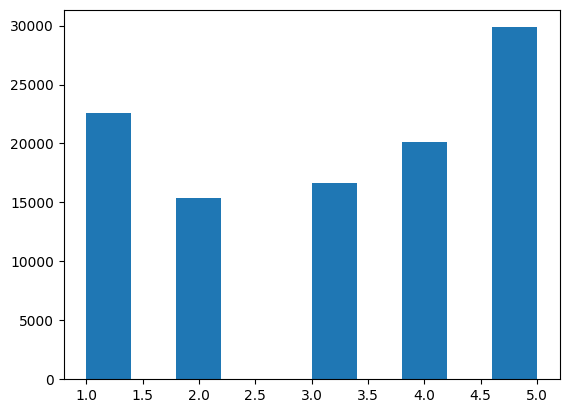

In [ ]:
# Visualisation de la distribution des notes
plt.hist(ho_df['overall'])
plt.show()

In [ ]:
ho_df['overall'].value_counts()

5.0    29853
1.0    22598
4.0    20111
3.0    16631
2.0    15383
Name: overall, dtype: int64

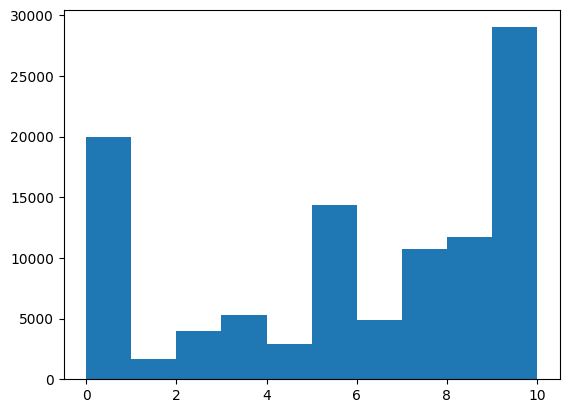

In [ ]:
# Visualisation de la distribution de l'utilité
plt.hist(ho_df['helpful'])
plt.show()

In [ ]:
ho_df['helpful'].value_counts()

0     20000
10    20000
5     14384
8     11719
7     10701
9      8999
3      5323
6      4891
2      3976
4      2907
1      1676
Name: helpful, dtype: int64

#### II. Split du dataset

In [ ]:
# Affectation et transformation
Y = ho_df[['overall', 'helpful']]
X = ho_df[['title', 'reviewText']]

In [ ]:
# split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,shuffle=True,random_state=1)

In [ ]:
reviews_train_tokens = X_train['reviewText'].apply(lambda line : preprocess_text(line))
reviews_test_tokens = X_test['reviewText'].apply(lambda line : preprocess_text(line))

In [ ]:
title_train_tokens = X_train['title'].apply(lambda line : preprocess_text(line))
title_test_tokens = X_test['title'].apply(lambda line : preprocess_text(line))

### B. Utilisation que du commentaire

#### I. Moyenne des embeddings

In [ ]:
def customized_accuracy_score_double(y1_true, y1_pred, y2_true, y2_pred, d1=0, d2=0):
  return mean([(1 if abs(y1_true[i] - y1_pred[i]) <= d1 and abs(y2_true[i] - y2_pred[i]) <= d2 else 0) for i in range(len(y1_true))])

In [ ]:
# Exécuter les algos en paramètre sur les données en utilisant en plus le score basé sur le seuillage binaire
def run_models_multioutput(X_train,Y_train,X_test,Y_test,algos):
    for algo_name in algos:
        model=algos[algo_name]
        model.fit(X_train,Y_train)
        prediction=model.predict(X_test)

        ytest_overall = Y_test[:,0]
        pred_overall = prediction[:,0]
        pred_overall[pred_overall < 1] = 1
        pred_overall[pred_overall > 5] = 5
        
        ytest_helpful = Y_test[:,1]
        pred_helpful = prediction[:,1]
        pred_helpful[pred_helpful < 1] = 1
        pred_helpful[pred_helpful > 10] = 10
        
        OMAE=mean_absolute_error(ytest_overall,pred_overall)
        OACC=accuracy_score(ytest_overall,np.round(pred_overall))
        OCACC=customized_accuracy(ytest_overall,np.round(pred_overall),1)

        HMAE=mean_absolute_error(ytest_helpful,pred_helpful)
        HACC=accuracy_score(ytest_helpful,np.round(pred_helpful))
        HCACC=customized_accuracy(ytest_helpful,np.round(pred_helpful),2)
        HBTS=binary_tresholding_score(ytest_helpful,np.round(pred_helpful))

        ACC=customized_accuracy_score_double(ytest_overall,np.round(pred_overall),ytest_helpful,np.round(pred_helpful))
        CACC=customized_accuracy_score_double(ytest_overall,np.round(pred_overall),ytest_helpful,np.round(pred_helpful),1,2)

        print('################## {0} #############'.format(algo_name))
        print('Note: MAE = {0:.3f}, Accuracy = {1:.3f}, Customized Accuracy = {2:.3f}'.format(OMAE,OACC,OCACC))
        print('Utilité: MAE = {0:.3f}, Accuracy = {1:.3f}, Customized Accuracy = {2:.3f}, Binary Thresholding Score = {3:.3f}'.format(HMAE,HACC,HCACC,HBTS))
        print('Les deux: Accuracy = {0:.3f}, Customized Accuracy = {1:.3f}'.format(ACC,CACC))
        display(confusion_matrix(ytest_overall,np.round(pred_overall)))
        display(confusion_matrix(ytest_helpful,np.round(pred_helpful)))
        print()

In [ ]:
# Calcul de de l'embedding des phrases
vector_size=model_google_vec_neg_300.vector_size
corpus_train_wv_google=word2vec_generator(reviews_train_tokens,model_google_vec_neg_300,vector_size)
corpus_test_wv_google=word2vec_generator(reviews_test_tokens,model_google_vec_neg_300,vector_size)

In [ ]:
# Modèles
algos = {
  'RF' : RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1),
  'KNN' : KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine'),
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=800,random_state=1,alpha=0.001)
}

In [ ]:
run_models_multioutput(corpus_train_wv_google, y_train, corpus_test_wv_google, y_test.to_numpy(), algos)

################## RF #############
Note: MAE = 1.228, Accuracy = 0.192, Customized Accuracy = 0.615
Utilité: MAE = 2.961, Accuracy = 0.096, Customized Accuracy = 0.440, Binary Thresholding Score = 0.602
Les deux: Accuracy = 0.016, Customized Accuracy = 0.261


array([[   1,  714, 3539,  331,    1],
       [   0,  263, 2439,  356,    0],
       [   0,  134, 2541,  631,    0],
       [   0,   86, 2699, 1217,    1],
       [   0,   77, 3664, 2222,    0]])

array([[   0,    4,    2,  120, 1017, 1682,  964,  325,   32,    0,    0],
       [   0,    0,    0,    2,   73,  125,   89,   32,    3,    0,    0],
       [   0,    0,    1,    8,  123,  309,  251,   67,    9,    0,    0],
       [   0,    1,    0,   12,  156,  365,  350,  152,   20,    0,    0],
       [   0,    0,    0,    6,   58,  178,  191,   74,   13,    0,    0],
       [   0,    0,    0,   31,  410, 1001, 1014,  427,   66,    0,    0],
       [   0,    1,    0,    4,   73,  262,  378,  222,   32,    0,    0],
       [   0,    0,    0,   15,  216,  615,  768,  431,   56,    2,    0],
       [   0,    0,    0,   11,  192,  616,  862,  580,  123,    2,    0],
       [   0,    0,    0,   10,  105,  335,  637,  544,  138,    0,    0],
       [   0,    0,    2,   42,  489, 1266, 1258,  737,  128,    1,    0]])


################## KNN #############
Note: MAE = 1.192, Accuracy = 0.236, Customized Accuracy = 0.670
Utilité: MAE = 3.112, Accuracy = 0.103, Customized Accuracy = 0.480, Binary Thresholding Score = 0.563
Les deux: Accuracy = 0.025, Customized Accuracy = 0.316


array([[ 298, 1311, 1971,  938,   68],
       [  60,  670, 1448,  819,   61],
       [  45,  473, 1537, 1146,  105],
       [  19,  353, 1563, 1803,  265],
       [  28,  439, 2058, 2817,  621]])

array([[   0,   30,   75,  171,  376,  635,  875,  964,  683,  316,   21],
       [   0,    1,    9,   17,   27,   50,   72,   72,   55,   20,    1],
       [   0,    2,    9,   28,   71,  112,  168,  193,  131,   51,    3],
       [   0,    5,    8,   28,   70,  142,  233,  268,  221,   77,    4],
       [   0,    2,    2,    6,   34,   69,  121,  146,  103,   35,    2],
       [   0,    9,   30,   77,  189,  399,  664,  726,  599,  242,   14],
       [   0,    2,    4,   18,   46,  110,  230,  258,  222,   79,    3],
       [   0,    6,    7,   36,  111,  254,  413,  640,  465,  161,   10],
       [   0,    3,    7,   26,  100,  239,  490,  697,  599,  209,   16],
       [   0,    2,    4,   12,   54,  178,  345,  522,  457,  181,   14],
       [   0,    7,   40,   84,  240,  462,  819, 1000,  846,  384,   41]])


################## MLP #############
Note: MAE = 1.013, Accuracy = 0.283, Customized Accuracy = 0.763
Utilité: MAE = 2.981, Accuracy = 0.093, Customized Accuracy = 0.463, Binary Thresholding Score = 0.593
Les deux: Accuracy = 0.026, Customized Accuracy = 0.347


array([[ 662, 1956, 1514,  439,   15],
       [ 123,  981, 1370,  561,   23],
       [  40,  648, 1539, 1004,   75],
       [  13,  317, 1516, 1871,  286],
       [  11,  333, 1614, 3139,  866]])

array([[  0,  92, 158, 413, 797, 963, 912, 590, 190,  30,   1],
       [  0,   5,  11,  22,  75,  65,  91,  47,   7,   1,   0],
       [  0,  10,  18,  44, 149, 207, 181, 127,  30,   2,   0],
       [  0,   8,  25,  75, 150, 233, 288, 213,  61,   3,   0],
       [  0,   2,   9,  28,  65, 122, 156, 115,  19,   3,   1],
       [  0,  25,  55, 178, 437, 648, 760, 632, 192,  20,   2],
       [  0,   3,   9,  31,  91, 194, 292, 261,  82,   9,   0],
       [  0,  10,  28,  85, 248, 385, 579, 560, 194,  14,   0],
       [  0,  12,  17,  79, 206, 422, 670, 689, 260,  31,   0],
       [  0,   3,  12,  35, 106, 246, 453, 594, 288,  31,   1],
       [  0,  20,  93, 211, 481, 806, 947, 924, 401,  40,   0]])

##### Pseudo courbe d'apprentissage du meilleur modèle

In [ ]:
corpus_train_wv_google.shape

(83660, 300)

In [ ]:
corpus_train_wv_google.iloc[:int(y_train.shape[0] * 0.8)].shape

(66928, 300)

In [ ]:
algos = {
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=800,random_state=1,alpha=0.001)
}

run_models_multioutput(corpus_train_wv_google.iloc[:int(y_train.shape[0] * 0.8)], y_train.iloc[:int(y_train.shape[0] * 0.8)], corpus_test_wv_google, y_test.to_numpy(), algos)

################## MLP #############
Note: MAE = 1.016, Accuracy = 0.271, Customized Accuracy = 0.772
Utilité: MAE = 2.963, Accuracy = 0.093, Customized Accuracy = 0.471, Binary Thresholding Score = 0.598
Les deux: Accuracy = 0.024, Customized Accuracy = 0.360


array([[ 458, 2166, 1402,  537,   23],
       [  78, 1001, 1295,  669,   15],
       [  20,  609, 1407, 1235,   35],
       [   8,  341, 1228, 2261,  165],
       [   8,  306, 1397, 3716,  536]])

array([[   0,  145,  188,  397,  692,  874,  963,  659,  193,   27,    8],
       [   0,    6,   13,   28,   60,   90,   74,   41,   10,    2,    0],
       [   0,   16,   18,   43,  111,  201,  202,  139,   36,    2,    0],
       [   0,   13,   28,   70,  139,  194,  318,  227,   65,    2,    0],
       [   0,    5,    7,   30,   55,  109,  161,  121,   29,    3,    0],
       [   0,   41,   64,  166,  347,  594,  819,  724,  181,   12,    1],
       [   0,    3,   14,   27,   71,  169,  309,  306,   61,   11,    1],
       [   0,   11,   29,   73,  201,  363,  622,  605,  190,    9,    0],
       [   0,   12,   29,   68,  163,  363,  649,  802,  276,   24,    0],
       [   0,    7,   12,   42,   78,  210,  464,  645,  292,   19,    0],
       [   0,   47,   92,  196,  428,  672, 1045, 1020,  388,   32,    3]])

Il n'est pas nécessaire de rajouter d'autres données pour améliorer l'apprentissage: Il n'y a pas de différence entre les deux trainings pour plus ou moins plus de données.

##### Amélioration du meilleur modèle

In [ ]:
# Plus de neurones
algos = {
  'MLP' : MLPRegressor(hidden_layer_sizes=(40, 20),max_iter=800,random_state=1,alpha=0.001)
}

run_models_multioutput(corpus_train_wv_google, y_train, corpus_test_wv_google, y_test.to_numpy(), algos)

################## MLP #############
Note: MAE = 1.009, Accuracy = 0.292, Customized Accuracy = 0.766
Utilité: MAE = 3.073, Accuracy = 0.092, Customized Accuracy = 0.473, Binary Thresholding Score = 0.586
Les deux: Accuracy = 0.025, Customized Accuracy = 0.358


array([[ 469, 1838, 1597,  646,   36],
       [  76,  810, 1404,  740,   28],
       [  20,  466, 1480, 1247,   93],
       [  10,  225, 1200, 2181,  387],
       [   6,  217, 1272, 3309, 1159]])

array([[  0, 383, 235, 366, 554, 724, 723, 682, 311,  90,  78],
       [  0,  25,  16,  27,  41,  75,  80,  42,  10,   3,   5],
       [  0,  47,  34,  56,  90, 138, 190, 131,  52,  22,   8],
       [  0,  44,  39,  70, 125, 207, 244, 194, 101,  23,   9],
       [  0,  12,  17,  31,  57,  90, 123, 115,  54,  14,   7],
       [  0, 152,  94, 203, 307, 506, 675, 636, 267,  76,  33],
       [  0,  31,  27,  34,  78, 151, 270, 258,  97,  18,   8],
       [  0,  64,  52, 104, 174, 349, 542, 528, 224,  49,  17],
       [  0,  43,  43, 105, 180, 348, 597, 669, 300,  67,  34],
       [  0,  25,  28,  46,  98, 228, 411, 535, 316,  65,  17],
       [  0, 172, 133, 213, 353, 573, 857, 924, 491, 141,  66]])

Legere amélioration dans la prédiction de la note et de la prédiction global.

In [ ]:
# Moins de neurones
algos = {
  'MLP' : MLPRegressor(hidden_layer_sizes=(10, 5),max_iter=800,random_state=1,alpha=0.001)
}

run_models_multioutput(corpus_train_wv_google, y_train, corpus_test_wv_google, y_test.to_numpy(), algos)

################## MLP #############
Note: MAE = 1.019, Accuracy = 0.278, Customized Accuracy = 0.764
Utilité: MAE = 2.948, Accuracy = 0.093, Customized Accuracy = 0.459, Binary Thresholding Score = 0.603
Les deux: Accuracy = 0.025, Customized Accuracy = 0.348


array([[ 408, 1996, 1579,  580,   23],
       [  66,  883, 1402,  687,   20],
       [  21,  472, 1529, 1229,   55],
       [   3,  265, 1340, 2163,  232],
       [   9,  243, 1448, 3430,  833]])

array([[   0,   42,   74,  298,  678, 1174, 1235,  572,   70,    2,    1],
       [   0,    2,    7,   17,   63,   90,   99,   42,    3,    1,    0],
       [   0,    3,    8,   39,  107,  212,  277,  111,   11,    0,    0],
       [   0,    5,   10,   47,  121,  256,  362,  233,   22,    0,    0],
       [   0,    2,    6,   14,   50,  106,  220,  106,   16,    0,    0],
       [   0,    5,   29,   85,  339,  703, 1043,  661,   83,    1,    0],
       [   0,    1,    4,   17,   63,  177,  389,  283,   37,    1,    0],
       [   0,    1,   10,   38,  150,  431,  770,  619,   81,    3,    0],
       [   0,    2,   15,   34,  137,  404,  890,  784,  117,    3,    0],
       [   0,    1,    4,   16,   76,  226,  588,  695,  159,    4,    0],
       [   0,    8,   26,  118,  379,  797, 1407, 1049,  138,    1,    0]])

Pas d'amélioration.

#### II. Prise en compte de la longueur, de la spécificité et de la subjectivité du texte

In [ ]:
# Calcul de la longueur, la spécificité et la subjectivité
df_meta_train=pd.DataFrame([])
df_meta_train['length_text'] = [len(reviews_train_tokens.iloc[i]) for i in range(len(reviews_train_tokens))]
df_meta_train['polarity'] = [polarity_txt(X_train["reviewText"].iloc[i]) for i in range(len(X_train))]
df_meta_train['subjectivity'] = [subj_txt(X_train["reviewText"].iloc[i]) for i in range(len(X_train))]

df_meta_test=pd.DataFrame([])
df_meta_test['length_text'] = [len(reviews_test_tokens.iloc[i]) for i in range(len(reviews_test_tokens))]
df_meta_test['polarity'] = [polarity_txt(X_test["reviewText"].iloc[i]) for i in range(len(X_test))]
df_meta_test['subjectivity'] = [subj_txt(X_test["reviewText"].iloc[i]) for i in range(len(X_test))]

In [ ]:
# Concaténation
corpus_train_wv_google_meta=pd.concat([corpus_train_wv_google,df_meta_train],axis=1)
corpus_test_wv_google_meta=pd.concat([corpus_test_wv_google,df_meta_test],axis=1)

In [ ]:
# Entraînement
algos = {
  'RF' : RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1),
  'KNN' : KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine'),
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=800,random_state=1,alpha=0.001)
}

run_models_multioutput(corpus_train_wv_google_meta,y_train,corpus_test_wv_google_meta,y_test.to_numpy(),algos)

################## RF #############
Note: MAE = 1.090, Accuracy = 0.227, Customized Accuracy = 0.738
Utilité: MAE = 2.944, Accuracy = 0.092, Customized Accuracy = 0.445, Binary Thresholding Score = 0.607
Les deux: Accuracy = 0.018, Customized Accuracy = 0.322


array([[  24, 2234, 1802,  526,    0],
       [   2,  937, 1530,  589,    0],
       [   4,  559, 1659, 1083,    1],
       [   0,  327, 1590, 2071,   15],
       [   1,  350, 1876, 3680,   56]])

array([[   0,    3,   16,  262, 1043, 1442,  992,  347,   41,    0,    0],
       [   0,    0,    0,    9,   66,  128,   92,   27,    2,    0,    0],
       [   0,    0,    3,   22,  146,  268,  227,   90,   12,    0,    0],
       [   0,    1,    0,   27,  163,  348,  338,  154,   24,    1,    0],
       [   0,    0,    1,    9,   64,  159,  199,   75,   13,    0,    0],
       [   0,    0,    4,   86,  441,  851, 1023,  468,   76,    0,    0],
       [   0,    1,    0,    9,   86,  221,  384,  240,   31,    0,    0],
       [   0,    0,    1,   31,  239,  535,  762,  451,   84,    0,    0],
       [   0,    0,    0,   28,  193,  580,  817,  629,  137,    2,    0],
       [   0,    0,    0,   12,   79,  294,  635,  596,  151,    2,    0],
       [   0,    0,    4,   73,  536, 1101, 1308,  762,  135,    4,    0]])


################## KNN #############
Note: MAE = 1.068, Accuracy = 0.292, Customized Accuracy = 0.733
Utilité: MAE = 3.092, Accuracy = 0.091, Customized Accuracy = 0.459, Binary Thresholding Score = 0.571
Les deux: Accuracy = 0.024, Customized Accuracy = 0.334


array([[ 709, 1626, 1451,  693,  107],
       [ 179,  824, 1206,  752,   97],
       [  78,  566, 1289, 1146,  227],
       [  33,  327, 1218, 1839,  586],
       [  46,  385, 1381, 2709, 1442]])

array([[  0, 109, 247, 422, 648, 846, 817, 604, 325, 117,  11],
       [  0,   4,   5,  36,  43,  87,  81,  36,  24,   8,   0],
       [  0,  13,  28,  62, 127, 145, 165, 127,  76,  24,   1],
       [  0,  18,  37,  70, 126, 208, 252, 206, 109,  30,   0],
       [  0,   6,  18,  29,  66, 110, 111, 108,  50,  22,   0],
       [  0,  42,  85, 203, 387, 555, 656, 600, 309, 105,   7],
       [  0,  14,  19,  51,  94, 165, 233, 216, 131,  47,   2],
       [  0,  17,  57, 109, 221, 380, 506, 455, 269,  81,   8],
       [  0,  16,  50,  98, 234, 378, 549, 546, 360, 148,   7],
       [  0,   9,  29,  59, 154, 228, 402, 442, 333, 108,   5],
       [  0,  40, 126, 280, 465, 702, 782, 773, 522, 219,  14]])


################## MLP #############
Note: MAE = 0.974, Accuracy = 0.293, Customized Accuracy = 0.789
Utilité: MAE = 2.971, Accuracy = 0.086, Customized Accuracy = 0.444, Binary Thresholding Score = 0.609
Les deux: Accuracy = 0.023, Customized Accuracy = 0.343


array([[ 651, 2380, 1208,  331,   16],
       [ 123, 1203, 1262,  456,   14],
       [  38,  728, 1578,  923,   39],
       [  11,  374, 1546, 1828,  244],
       [   8,  349, 1561, 3172,  873]])

array([[   0,  110,  126,  303,  734, 1301, 1269,  288,   14,    1,    0],
       [   0,    5,   10,   20,   50,  132,   92,   15,    0,    0,    0],
       [   0,    8,   13,   39,  125,  284,  247,   51,    0,    1,    0],
       [   0,   12,   13,   45,  132,  346,  432,   71,    5,    0,    0],
       [   0,    4,    9,   18,   46,  176,  221,   43,    3,    0,    0],
       [   0,   38,   47,  101,  358,  884, 1246,  263,   12,    0,    0],
       [   0,    4,    5,   21,   78,  252,  481,  125,    6,    0,    0],
       [   0,    9,   13,   55,  159,  561,  990,  306,   10,    0,    0],
       [   0,   16,   17,   35,  151,  529, 1212,  404,   22,    0,    0],
       [   0,    5,    8,   22,   68,  299,  887,  453,   27,    0,    0],
       [   0,   40,   55,  115,  368, 1025, 1681,  602,   35,    2,    0]])

Petite amélioration dans la prédiction de la note

#### III. Prise en compte de l'ordre des mots (LSTM)

In [ ]:
word2idx = {word: idx for idx, word in enumerate(model_google_vec_neg_300.index_to_key)}
X_train_sequences = [to_sequence(word2idx, x) for x in reviews_train_tokens]
X_test_sequences = [to_sequence(word2idx, x) for x in  reviews_test_tokens]

print(reviews_train_tokens.values[0])
print(X_train_sequences[0])

['if', 'amazon', 'com', 'zero', 'star', 'rate', 'that', 'product', 'machin', 'month', 'enjoi', 'work', 'meticul', 'maintain', 'clean', 'us', 'recent', 'detect', 'burn', 'odor', 'machin', 'got', 'loud', 'realiz', 'go', 'close', 'examin', 'part', 'the', 'blade', 'basket', 'cheap', 'gotta', 'cut', 'cost', 'somewher', 'the', 'teeth', 'blade', 'grind', 'liquifi', 'eventu', 'start', 'bend', 'upward', 'actual', 'start', 'eat', 'plastic', 'food', 'chute', 'perhap', 'defect', 'blade', 'doubt', 'work', 'fine', 'got', 'it', 'in', 'event', 'unbeknownst', 'me', 'probabl', 'ingest', 'small', 'particl', 'plastic', 'yummi', 'fruit', 'drink', 'needless', 'sai', 'extrem', 'unhappi', 'product', 'perhap', 'want', 'bui', 'new', 'basket', 'month', 'my', 'advic', 'save', 'monei', 'heavi', 'duti', 'machin', 'ebai']
[88, 183690, 18117, 4200, 948, 511, 3, 684, 1701433, 212, 141, 1907, 1749, 164, 386, 7624, 5566, 15860, 1701433, 193, 6092, 152, 398, 1954453, 186, 11, 16693, 4490, 4240, 12944, 529, 370, 11, 6969,

In [ ]:
from keras.utils import pad_sequences

MAX_SEQ_LENGHT=50
N_FEATURES = len(model_google_vec_neg_300.index_to_key)
X_train_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
X_test_sequences = pad_sequences(X_test_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
print(X_train_sequences[0])

[1954453     186      11   16693    4490    4240   12944     529     370
      11    6969   16693   13381     284   14120   10271    2769     284
    2785    4471     560   39543   17046   16693    1962     141    1389
     193      15       1     424   68886     170   47121     428    4471
    5169    3554   25417  229984 1560228     684     189  972514      65
    4490     212     126    1114 1701433]


In [ ]:
EMBEDDINGS_LEN = model_google_vec_neg_300.vector_size
embeddings_index = np.zeros((len(model_google_vec_neg_300.index_to_key)+1, EMBEDDINGS_LEN))
embeddings_index.shape

(3000001, 300)

In [ ]:
for word, idx in word2idx.items():
    try:
        embedding = model_google_vec_neg_300[word]
        embeddings_index[idx] = embedding
    except:
        pass
      
print("EMBEDDINGS_LEN=", EMBEDDINGS_LEN)

EMBEDDINGS_LEN= 300


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Dense,LSTM


model_lstm = Sequential()
model_lstm.add(Embedding(len(model_google_vec_neg_300.key_to_index)+1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    trainable=False))

model_lstm.add(LSTM(300, dropout=0.2))

model_lstm.add(Dense(2))
model_lstm.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 300)         900000300 
                                                                 
 lstm_6 (LSTM)               (None, 300)               721200    
                                                                 
 dense_6 (Dense)             (None, 2)                 602       
                                                                 
Total params: 900,722,102
Trainable params: 721,802
Non-trainable params: 900,000,300
_________________________________________________________________


In [ ]:
history = model_lstm.fit(X_train_sequences, y_train, epochs=10, batch_size=128, verbose=1,validation_split=0.1)

Epoch 1/10
589/589 [==============================] - 84s 139ms/step - loss: 2.0405 - mean_absolute_error: 2.0405 - val_loss: 1.9452 - val_mean_absolute_error: 1.9452
Epoch 2/10
589/589 [==============================] - 82s 139ms/step - loss: 1.9348 - mean_absolute_error: 1.9348 - val_loss: 1.9450 - val_mean_absolute_error: 1.9450
Epoch 3/10
589/589 [==============================] - 82s 139ms/step - loss: 1.9011 - mean_absolute_error: 1.9011 - val_loss: 1.8902 - val_mean_absolute_error: 1.8902
Epoch 4/10
589/589 [==============================] - 82s 140ms/step - loss: 1.8798 - mean_absolute_error: 1.8798 - val_loss: 1.9125 - val_mean_absolute_error: 1.9125
Epoch 5/10
589/589 [==============================] - 80s 136ms/step - loss: 1.8636 - mean_absolute_error: 1.8636 - val_loss: 1.8823 - val_mean_absolute_error: 1.8823
Epoch 6/10
589/589 [==============================] - 80s 136ms/step - loss: 1.8446 - mean_absolute_error: 1.8446 - val_loss: 1.9011 - val_mean_absolute_error: 1.901

In [ ]:
scores_lstm = model_lstm.evaluate(X_test_sequences, y_test, verbose=1)

654/654 [==============================] - 16s 25ms/step - loss: 1.8689 - mean_absolute_error: 1.8689


In [ ]:
prediction=model_lstm.predict(X_test_sequences)

ytest_overall = y_test.iloc[:,0].to_numpy()
pred_overall = prediction[:,0]
pred_overall[pred_overall < 1] = 1
pred_overall[pred_overall > 5] = 5
        
ytest_helpful = y_test.iloc[:,1].to_numpy()
pred_helpful = prediction[:,1]
pred_helpful[pred_helpful < 1] = 1
pred_helpful[pred_helpful > 10] = 10
        
OMAE=mean_absolute_error(ytest_overall,pred_overall)
OACC=accuracy_score(ytest_overall,np.round(pred_overall))
OCACC=customized_accuracy(ytest_overall,np.round(pred_overall),1)

HMAE=mean_absolute_error(ytest_helpful,pred_helpful)
HACC=accuracy_score(ytest_helpful,np.round(pred_helpful))
HCACC=customized_accuracy(ytest_helpful,np.round(pred_helpful),2)
HBTS=binary_tresholding_score(ytest_helpful,np.round(pred_helpful))

ACC=customized_accuracy_score_double(ytest_overall,np.round(pred_overall),ytest_helpful,np.round(pred_helpful))
CACC=customized_accuracy_score_double(ytest_overall,np.round(pred_overall),ytest_helpful,np.round(pred_helpful),1,2)

print('Note: MAE = {0:.3f}, Accuracy = {1:.3f}, Customized Accuracy = {2:.3f}'.format(OMAE,OACC,OCACC))
print('Utilité: MAE = {0:.3f}, Accuracy = {1:.3f}, Customized Accuracy = {2:.3f}, Binary Thresholding Score = {3:.3f}'.format(HMAE,HACC,HCACC,HBTS))
print('Les deux: Accuracy = {0:.3f}, Customized Accuracy = {1:.3f}'.format(ACC,CACC))
display(confusion_matrix(ytest_overall,np.round(pred_overall)))
display(confusion_matrix(ytest_helpful,np.round(pred_helpful)))

654/654 [==============================] - 16s 25ms/step
Note: MAE = 0.832, Accuracy = 0.439, Customized Accuracy = 0.820
Utilité: MAE = 2.898, Accuracy = 0.102, Customized Accuracy = 0.500, Binary Thresholding Score = 0.614
Les deux: Accuracy = 0.047, Customized Accuracy = 0.410


array([[2275, 1079,  655,  439,  138],
       [ 658,  913,  813,  554,  120],
       [ 272,  617, 1073, 1051,  293],
       [  93,  244,  768, 1785, 1113],
       [  91,  240,  627, 1868, 3137]])

array([[   0,  203,  179,  352,  582,  830,  868,  773,  321,   37,    1],
       [   0,    9,   15,   34,   51,   82,   66,   53,   14,    0,    0],
       [   0,   13,   22,   68,  122,  160,  160,  156,   61,    6,    0],
       [   0,   12,   24,   65,  128,  234,  231,  258,   93,   11,    0],
       [   0,    3,   14,   23,   56,  100,  125,  136,   58,    5,    0],
       [   0,   37,   68,  135,  354,  541,  654,  764,  369,   25,    2],
       [   0,    9,   10,   20,   77,  148,  233,  322,  147,    6,    0],
       [   0,    7,   28,   69,  188,  301,  450,  677,  352,   31,    0],
       [   0,   11,   15,   56,  153,  312,  491,  810,  490,   48,    0],
       [   0,    7,   10,   25,   63,  131,  320,  665,  502,   45,    1],
       [   0,   56,   70,  137,  331,  603,  801, 1154,  686,   84,    1]])

Meilleur jusqu'à présent.

#### IV. Utilisation de la sortie du LSTM dans d'autres modèles seupervisés

In [ ]:
from keras.models import Model
Model_rf = Model(inputs=model_lstm.inputs, outputs=model_lstm.layers[1].output)
#Model_rf.save('../models/model_lstm_features.h5')
corpus_train_lstm = Model_rf.predict(X_train_sequences)
corpus_test_lstm = Model_rf.predict(X_test_sequences)

654/654 [==============================] - 16s 25ms/step


In [ ]:
algos = {
  'RF' : RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1),
  'KNN' : KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine'),
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=800,random_state=1,alpha=0.001)
}

run_models_multioutput(corpus_train_lstm,y_train,corpus_test_lstm,y_test.to_numpy(),algos)

################## RF #############
Note: MAE = 0.899, Accuracy = 0.346, Customized Accuracy = 0.828
Utilité: MAE = 2.952, Accuracy = 0.092, Customized Accuracy = 0.458, Binary Thresholding Score = 0.602
Les deux: Accuracy = 0.031, Customized Accuracy = 0.377


array([[1085, 2187,  829,  459,   26],
       [ 204, 1285,  993,  549,   27],
       [  78,  755, 1278, 1124,   71],
       [  25,  313, 1002, 2310,  353],
       [  25,  340,  853, 3476, 1269]])

array([[   0,   47,  174,  451,  764, 1067, 1015,  498,  121,    9,    0],
       [   0,    3,    5,   28,   70,  101,   75,   36,    6,    0,    0],
       [   0,    1,   15,   70,  146,  197,  208,  110,   20,    1,    0],
       [   0,    5,   13,   54,  184,  267,  296,  197,   38,    2,    0],
       [   0,    0,    6,   26,   76,  126,  156,  112,   17,    1,    0],
       [   0,   10,   43,  174,  426,  732,  872,  550,  138,    4,    0],
       [   0,    1,    6,   26,   93,  221,  345,  232,   48,    0,    0],
       [   0,    1,   15,   76,  218,  484,  630,  528,  146,    5,    0],
       [   0,    2,    8,   64,  192,  485,  781,  676,  175,    3,    0],
       [   0,    0,   16,   25,   88,  241,  586,  592,  215,    6,    0],
       [   0,   16,   64,  188,  468,  847, 1178,  914,  238,   10,    0]])


################## KNN #############
Note: MAE = 0.905, Accuracy = 0.386, Customized Accuracy = 0.803
Utilité: MAE = 3.085, Accuracy = 0.094, Customized Accuracy = 0.468, Binary Thresholding Score = 0.577
Les deux: Accuracy = 0.037, Customized Accuracy = 0.373


array([[1660, 1554,  794,  434,  144],
       [ 447, 1015,  904,  555,  137],
       [ 187,  676, 1123, 1074,  246],
       [  70,  307,  910, 1846,  870],
       [  70,  293,  893, 2277, 2430]])

array([[  0, 173, 257, 402, 620, 690, 742, 680, 389, 169,  24],
       [  0,   9,  16,  35,  60,  52,  62,  40,  36,  13,   1],
       [  0,  21,  29,  72, 115, 141, 131, 141,  78,  37,   3],
       [  0,  16,  41,  73, 153, 197, 232, 160, 130,  48,   6],
       [  0,   5,  18,  30,  60,  89, 112, 115,  61,  27,   3],
       [  0,  74,  92, 229, 354, 501, 606, 544, 376, 157,  16],
       [  0,   9,  27,  34,  98, 148, 235, 203, 159,  56,   3],
       [  0,  20,  53, 105, 240, 326, 454, 473, 310, 110,  12],
       [  0,  20,  48, 113, 218, 373, 521, 514, 396, 164,  19],
       [  0,  10,  35,  67,  99, 239, 361, 414, 379, 155,  10],
       [  0,  59, 138, 228, 392, 607, 810, 746, 604, 306,  33]])


################## MLP #############
Note: MAE = 0.876, Accuracy = 0.362, Customized Accuracy = 0.832
Utilité: MAE = 2.986, Accuracy = 0.089, Customized Accuracy = 0.487, Binary Thresholding Score = 0.598
Les deux: Accuracy = 0.032, Customized Accuracy = 0.404


array([[1526, 1818,  816,  405,   21],
       [ 340, 1217, 1004,  482,   15],
       [ 119,  773, 1316, 1045,   53],
       [  42,  288, 1102, 2219,  352],
       [  28,  298,  946, 3391, 1300]])

array([[   0,  399,  291,  359,  397,  718,  926,  791,  213,   34,   18],
       [   0,   23,   20,   28,   36,   65,   81,   58,   11,    1,    1],
       [   0,   33,   29,   59,   76,  168,  213,  146,   38,    5,    1],
       [   0,   26,   52,   62,  109,  199,  306,  244,   50,    6,    2],
       [   0,   13,   21,   24,   29,   95,  172,  133,   29,    4,    0],
       [   0,  102,  114,  167,  255,  469,  831,  805,  180,   22,    4],
       [   0,   13,   18,   33,   85,  135,  294,  310,   82,    2,    0],
       [   0,   60,   61,   87,  127,  307,  561,  694,  192,   13,    1],
       [   0,   39,   38,   87,  147,  282,  671,  876,  234,   10,    2],
       [   0,   16,   27,   42,   57,  148,  438,  761,  256,   22,    2],
       [   0,  159,  154,  209,  273,  486, 1008, 1228,  369,   29,    8]])

Amélioration du MLP par rapport au précédent.

### C. Utilisation du commentaire et du titre du produit

#### I. Moyenne des embeddings

In [ ]:
vector_size=model_google_vec_neg_300.vector_size

reviews_train_wv_google=word2vec_generator(reviews_train_tokens,model_google_vec_neg_300,vector_size)
reviews_test_wv_google=word2vec_generator(reviews_test_tokens,model_google_vec_neg_300,vector_size)

title_train_wv_google=word2vec_generator(title_train_tokens,model_google_vec_neg_300,vector_size)
title_test_wv_google=word2vec_generator(title_test_tokens,model_google_vec_neg_300,vector_size)

# renommage des colonnes de titles...
title_train_wv_google.columns = ["t" + str(c) for c in title_train_wv_google.columns]
title_test_wv_google.columns = ["t" + str(c) for c in title_test_wv_google.columns]

In [ ]:
rev_a_title_train_wv_google = pd.concat([reviews_train_wv_google, title_train_wv_google], axis=1)
rev_a_title_test_wv_google = pd.concat([reviews_test_wv_google, title_test_wv_google], axis=1)

rev_a_title_train_wv_google.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23,t24,t25,t26,t27,t28,t29,t30,t31,t32,t33,t34,t35,t36,t37,t38,t39,t40,t41,t42,t43,t44,t45,t46,t47,t48,t49,t50,t51,t52,t53,t54,t55,t56,t57,t58,t59,t60,t61,t62,t63,t64,t65,t66,t67,t68,t69,t70,t71,t72,t73,t74,t75,t76,t77,t78,t79,t80,t81,t82,t83,t84,t85,t86,t87,t88,t89,t90,t91,t92,t93,t94,t95,t96,t97,t98,t99,t100,t101,t102,t103,t104,t105,t106,t107,t108,t109,t110,t111,t112,t113,t114,t115,t116,t117,t118,t119,t120,t121,t122,t123,t124,t125,t126,t127,t128,t129,t130,t131,t132,t133,t134,t135,t136,t137,t138,t139,t140,t141,t142,t143,t144,t145,t146,t147,t148,t149,t150,t151,t152,t153,t154,t155,t156,t157,t158,t159,t160,t161,t162,t163,t164,t165,t166,t167,t168,t169,t170,t171,t172,t173,t174,t175,t176,t177,t178,t179,t180,t181,t182,t183,t184,t185,t186,t187,t188,t189,t190,t191,t192,t193,t194,t195,t196,t197,t198,t199,t200,t201,t202,t203,t204,t205,t206,t207,t208,t209,t210,t211,t212,t213,t214,t215,t216,t217,t218,t219,t220,t221,t222,t223,t224,t225,t226,t227,t228,t229,t230,t231,t232,t233,t234,t235,t236,t237,t238,t239,t240,t241,t242,t243,t244,t245,t246,t247,t248,t249,t250,t251,t252,t253,t254,t255,t256,t257,t258,t259,t260,t261,t262,t263,t264,t265,t266,t267,t268,t269,t270,t271,t272,t273,t274,t275,t276,t277,t278,t279,t280,t281,t282,t283,t284,t285,t286,t287,t288,t289,t290,t291,t292,t293,t294,t295,t296,t297,t298,t299
0,-0.002900,0.044868,0.006784,0.074842,-0.102040,0.020503,0.050016,-0.074015,0.055866,0.099108,-0.051928,-0.119348,-0.016559,0.020685,-0.092850,0.080830,0.025311,0.084151,0.000409,-0.052561,0.004491,0.021908,0.052043,0.023320,0.002230,-0.010714,-0.032790,0.056665,0.015640,-0.052884,-0.026823,0.003278,0.002231,-0.074988,0.006963,-0.052575,0.012789,-0.016799,0.009686,0.029267,0.069609,-0.065814,0.124028,-0.042836,-0.058742,-0.068833,-0.031450,0.005493,0.023426,0.019639,0.000967,-0.004218,0.007726,-0.028178,0.038489,-0.003355,-0.008886,-0.075110,0.016318,-0.051416,-0.022196,0.044364,-0.096261,-0.030301,0.026029,-0.037417,-0.031374,0.060877,-0.031473,0.085079,0.040173,0.011696,0.057092,-0.027526,-0.138667,-0.075401,0.046112,0.053008,0.020549,0.050109,0.013487,-0.042455,0.023044,-0.003710,-0.010401,-0.020149,-0.040324,0.155952,0.052127,0.030129,0.015279,0.052953,-0.046857,-0.059532,-0.039087,-0.065372,0.030723,0.017287,0.055403,-0.021920,-0.035279,-0.049337,0.020826,0.003350,-0.022710,-0.081744,-0.005923,-0.009235,0.019858,-0.083950,-0.062847,-0.085897,-0.008505,-0.015938,0.051282,0.033426,0.035956,-0.023264,0.025825,0.023855,-0.057292,-0.003651,-0.070389,0.046999,0.015469,0.007323,-0.039538,-0.058791,0.057725,0.033074,-0.055515,-0.012679,-0.080372,0.009174,-0.017444,0.025905,0.044887,0.009169,0.002169,0.073048,0.057993,-0.088614,-0.030991,-0.003501,0.008017,0.036120,-0.020569,-0.031011,-0.071039,-0.043187,0.089305,-0.029168,-0.05180,0.088863,-0.029610,-0.004764,-0.061786,-0.049806,-0.075134,-0.0190

In [ ]:
algos = {
  'RF' : RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1),
  'KNN' : KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine'),
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=800,random_state=1,alpha=0.001)
}

run_models_multioutput(rev_a_title_train_wv_google, y_train, rev_a_title_test_wv_google, y_test.to_numpy(), algos)

################## RF #############
Note: MAE = 1.245, Accuracy = 0.186, Customized Accuracy = 0.600
Utilité: MAE = 2.966, Accuracy = 0.097, Customized Accuracy = 0.440, Binary Thresholding Score = 0.602
Les deux: Accuracy = 0.016, Customized Accuracy = 0.253


array([[   0,  529, 3729,  328,    0],
       [   0,  186, 2503,  369,    0],
       [   0,  105, 2588,  613,    0],
       [   0,   84, 2813, 1106,    0],
       [   0,   57, 3803, 2102,    1]])

array([[   0,    0,    8,  113,  909, 1747, 1045,  298,   26,    0,    0],
       [   0,    0,    0,    3,   55,  141,   94,   25,    6,    0,    0],
       [   0,    0,    0,   10,  134,  311,  231,   78,    4,    0,    0],
       [   0,    0,    0,   14,  152,  368,  358,  148,   16,    0,    0],
       [   0,    0,    0,    4,   57,  171,  201,   75,   12,    0,    0],
       [   0,    0,    0,   29,  366, 1050, 1049,  416,   39,    0,    0],
       [   0,    0,    0,    8,   83,  261,  397,  201,   22,    0,    0],
       [   0,    0,    0,    8,  172,  638,  813,  420,   52,    0,    0],
       [   0,    0,    0,   12,  180,  637,  907,  563,   86,    1,    0],
       [   0,    0,    0,    4,   81,  368,  694,  524,   98,    0,    0],
       [   0,    0,    0,   28,  475, 1259, 1382,  681,   97,    1,    0]])


################## KNN #############
Note: MAE = 1.332, Accuracy = 0.195, Customized Accuracy = 0.597
Utilité: MAE = 3.177, Accuracy = 0.090, Customized Accuracy = 0.442, Binary Thresholding Score = 0.537
Les deux: Accuracy = 0.017, Customized Accuracy = 0.261


array([[ 108, 1068, 2162, 1164,   84],
       [  48,  599, 1467,  875,   69],
       [  31,  540, 1586, 1040,  109],
       [  38,  543, 1800, 1488,  134],
       [  37,  780, 2530, 2312,  304]])

array([[  0,  55, 164, 282, 518, 782, 922, 781, 449, 166,  27],
       [  0,   1,   5,  16,  37,  58,  83,  68,  41,  15,   0],
       [  0,   2,   8,  36,  91, 149, 187, 160, 110,  24,   1],
       [  0,   1,  11,  45, 112, 196, 244, 256, 155,  35,   1],
       [  0,   2,   4,  26,  57,  92, 122, 118,  70,  27,   2],
       [  0,  23,  37, 120, 319, 546, 745, 651, 397, 101,  10],
       [  0,   1,   6,  42,  93, 182, 257, 215, 123,  52,   1],
       [  0,  10,  34,  83, 210, 394, 501, 494, 274,  99,   4],
       [  0,   5,  37,  78, 222, 418, 564, 587, 350, 114,  11],
       [  0,   3,  20,  58, 139, 319, 419, 430, 273, 100,   8],
       [  0,  32,  67, 170, 411, 676, 910, 900, 538, 205,  14]])


################## MLP #############
Note: MAE = 1.028, Accuracy = 0.276, Customized Accuracy = 0.757
Utilité: MAE = 3.148, Accuracy = 0.089, Customized Accuracy = 0.461, Binary Thresholding Score = 0.568
Les deux: Accuracy = 0.024, Customized Accuracy = 0.346


array([[ 630, 1976, 1533,  432,   15],
       [ 110,  990, 1396,  542,   20],
       [  45,  635, 1542, 1013,   71],
       [  16,  343, 1491, 1948,  205],
       [  14,  322, 1725, 3231,  671]])

array([[  0, 360, 308, 411, 537, 616, 693, 686, 353, 125,  57],
       [  0,  27,  19,  32,  61,  48,  58,  47,  19,   5,   8],
       [  0,  42,  44,  61,  98, 119, 157, 142,  71,  21,  13],
       [  0,  46,  48,  95, 133, 170, 226, 192,  93,  40,  13],
       [  0,  20,  20,  38,  66,  97, 103,  99,  54,  19,   4],
       [  0, 136, 115, 220, 322, 460, 611, 608, 338, 100,  39],
       [  0,  26,  33,  62,  97, 154, 206, 226, 127,  28,  13],
       [  0,  70,  83, 115, 230, 335, 433, 457, 280,  76,  24],
       [  0,  66,  77, 127, 190, 327, 490, 615, 355, 103,  36],
       [  0,  37,  37,  66, 128, 213, 392, 502, 292,  80,  22],
       [  0, 188, 153, 242, 428, 554, 782, 856, 490, 162,  68]])

Pas d'amélioration par rapport à son équivalent dans la partie précédente.

##### Courbe d'apprentissage du meilleur modèle

In [ ]:
algos = {
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=800,random_state=1,alpha=0.001)
}

run_models_multioutput(rev_a_title_train_wv_google.iloc[:int(y_train.shape[0] * 0.8)], y_train.iloc[:int(y_train.shape[0] * 0.8)], rev_a_title_test_wv_google, y_test.to_numpy(), algos)

################## MLP #############
Note: MAE = 1.046, Accuracy = 0.266, Customized Accuracy = 0.741
Utilité: MAE = 3.204, Accuracy = 0.091, Customized Accuracy = 0.456, Binary Thresholding Score = 0.564
Les deux: Accuracy = 0.022, Customized Accuracy = 0.333


array([[ 551, 1894, 1787,  341,   13],
       [ 117,  948, 1565,  410,   18],
       [  39,  639, 1746,  813,   69],
       [  19,  314, 1842, 1569,  259],
       [  10,  288, 2107, 2809,  749]])

array([[  0, 367, 258, 390, 511, 652, 697, 599, 371, 169, 132],
       [  0,  16,  12,  27,  50,  51,  63,  51,  28,  16,  10],
       [  0,  39,  27,  53,  97, 134, 153, 130,  83,  27,  25],
       [  0,  46,  49,  80, 109, 166, 241, 205, 104,  32,  24],
       [  0,  15,  11,  45,  50,  89, 119,  94,  65,  21,  11],
       [  0, 151, 140, 190, 328, 455, 602, 539, 332, 131,  81],
       [  0,  31,  28,  50,  96, 172, 186, 227, 112,  44,  26],
       [  0,  67,  74, 136, 187, 316, 407, 476, 247, 115,  78],
       [  0,  82,  74, 127, 200, 285, 509, 527, 323, 153, 106],
       [  0,  52,  29,  71, 128, 219, 372, 424, 275, 128,  71],
       [  0, 214, 163, 262, 364, 536, 733, 747, 500, 245, 159]])

Le modèle peut probablement mieux apprendre avec un peu plus de données mais c'est assez stable.

##### Amélioration du meilleur modèle

In [ ]:
# Moins de neurones
algos = {
  'MLP' : MLPRegressor(hidden_layer_sizes=(10, 5),max_iter=800,random_state=1,alpha=0.001)
}

run_models_multioutput(rev_a_title_train_wv_google, y_train, rev_a_title_test_wv_google, y_test.to_numpy(), algos)

################## MLP #############
Note: MAE = 1.049, Accuracy = 0.264, Customized Accuracy = 0.741
Utilité: MAE = 3.043, Accuracy = 0.091, Customized Accuracy = 0.441, Binary Thresholding Score = 0.576
Les deux: Accuracy = 0.022, Customized Accuracy = 0.319


array([[ 540, 1831, 1847,  351,   17],
       [ 124,  842, 1658,  415,   19],
       [  40,  550, 1798,  861,   57],
       [  13,  308, 1798, 1679,  205],
       [   9,  245, 2088, 2956,  665]])

array([[   0,   69,  134,  376,  720, 1121, 1053,  529,  125,   19,    0],
       [   0,    3,    8,   22,   53,   90,   87,   40,   17,    3,    1],
       [   0,    7,   18,   56,  121,  205,  205,  121,   33,    1,    1],
       [   0,   10,   20,   44,  156,  263,  307,  188,   59,    9,    0],
       [   0,    2,   10,   23,   62,  134,  162,   98,   22,    7,    0],
       [   0,   19,   47,  161,  373,  775,  867,  545,  137,   23,    2],
       [   0,    5,    5,   36,   90,  243,  313,  211,   55,    8,    6],
       [   0,   20,   18,   70,  217,  472,  690,  462,  133,   17,    4],
       [   0,   11,   21,   85,  214,  501,  758,  582,  186,   23,    5],
       [   0,    1,   12,   35,  111,  350,  589,  479,  163,   28,    1],
       [   0,   27,   52,  177,  454,  978, 1223,  748,  228,   30,    6]])

Pas d'amélioration

In [ ]:
# Plus de neurones
algos = {
  'MLP' : MLPRegressor(hidden_layer_sizes=(40, 20),max_iter=800,random_state=1,alpha=0.001)
}

run_models_multioutput(rev_a_title_train_wv_google, y_train, rev_a_title_test_wv_google, y_test.to_numpy(), algos)

################## MLP #############
Note: MAE = 1.033, Accuracy = 0.275, Customized Accuracy = 0.755
Utilité: MAE = 3.322, Accuracy = 0.089, Customized Accuracy = 0.451, Binary Thresholding Score = 0.546
Les deux: Accuracy = 0.023, Customized Accuracy = 0.336


array([[ 641, 2067, 1470,  387,   21],
       [ 121, 1091, 1341,  486,   19],
       [  37,  709, 1573,  928,   59],
       [  21,  400, 1631, 1732,  219],
       [  20,  363, 1839, 3036,  705]])

array([[  0, 663, 296, 350, 431, 523, 565, 525, 364, 220, 209],
       [  0,  51,  23,  20,  32,  34,  62,  45,  31,  14,  12],
       [  0,  80,  39,  70,  78, 110, 123, 131,  62,  52,  23],
       [  0, 109,  55,  70,  91, 141, 207, 176, 118,  57,  32],
       [  0,  36,  21,  41,  53,  74,  96,  93,  65,  23,  18],
       [  0, 274, 137, 219, 293, 412, 511, 478, 316, 174, 135],
       [  0,  63,  42,  59,  92, 143, 204, 180, 100,  58,  31],
       [  0, 150, 100, 140, 181, 288, 358, 383, 271, 138,  94],
       [  0, 144, 105, 138, 201, 302, 434, 436, 311, 187, 128],
       [  0,  89,  75,  93, 145, 252, 285, 344, 255, 135,  96],
       [  0, 362, 182, 296, 386, 524, 624, 575, 446, 317, 211]])

Pas d'amélioration non plus.

#### II. Prise en compte de la longueur, de la spécificité et de la subjectivité du texte

In [ ]:
# Calcul de la longueur, la spécificité et la subjectivité
df_meta_train=pd.DataFrame([])
df_meta_train['length_text'] = [len(reviews_train_tokens.iloc[i]) for i in range(len(reviews_train_tokens))]
df_meta_train['polarity'] = [polarity_txt(X_train["reviewText"].iloc[i]) for i in range(len(X_train))]
df_meta_train['subjectivity'] = [subj_txt(X_train["reviewText"].iloc[i]) for i in range(len(X_train))]

df_meta_test=pd.DataFrame([])
df_meta_test['length_text'] = [len(reviews_test_tokens.iloc[i]) for i in range(len(reviews_test_tokens))]
df_meta_test['polarity'] = [polarity_txt(X_test["reviewText"].iloc[i]) for i in range(len(X_test))]
df_meta_test['subjectivity'] = [subj_txt(X_test["reviewText"].iloc[i]) for i in range(len(X_test))]

In [ ]:
# Concaténation
corpus_train_wv_google_meta=pd.concat([reviews_train_wv_google,title_train_wv_google,df_meta_train],axis=1)
corpus_test_wv_google_meta=pd.concat([reviews_test_wv_google,title_test_wv_google,df_meta_test],axis=1)

In [ ]:
# Entraînement et évaluation
algos = {
  'RF' : RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1),
  'KNN' : KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine'),
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=800,random_state=1,alpha=0.001)
}

run_models_multioutput(corpus_train_wv_google_meta,y_train,corpus_test_wv_google_meta,y_test.to_numpy(),algos)

################## RF #############
Note: MAE = 1.105, Accuracy = 0.226, Customized Accuracy = 0.731
Utilité: MAE = 2.941, Accuracy = 0.095, Customized Accuracy = 0.445, Binary Thresholding Score = 0.611
Les deux: Accuracy = 0.019, Customized Accuracy = 0.319


array([[  18, 2179, 1839,  550,    0],
       [   2,  957, 1509,  590,    0],
       [   2,  544, 1659, 1099,    2],
       [   0,  342, 1594, 2062,    5],
       [   1,  377, 1932, 3622,   31]])

array([[   0,    2,   33,  246, 1128, 1352,  997,  344,   44,    0,    0],
       [   0,    0,    0,    8,   70,  121,   89,   32,    4,    0,    0],
       [   0,    0,    0,   19,  152,  254,  261,   74,    8,    0,    0],
       [   0,    0,    1,   18,  165,  329,  349,  168,   26,    0,    0],
       [   0,    0,    0,   14,   70,  150,  189,   85,   12,    0,    0],
       [   0,    0,    4,   75,  447,  911,  960,  495,   57,    0,    0],
       [   0,    0,    0,   11,   79,  242,  377,  228,   35,    0,    0],
       [   0,    0,    2,   36,  221,  523,  769,  481,   71,    0,    0],
       [   0,    0,    0,   32,  184,  539,  874,  636,  121,    0,    0],
       [   0,    0,    1,    8,   89,  285,  687,  573,  125,    1,    0],
       [   0,    0,    7,   86,  479, 1128, 1331,  760,  131,    1,    0]])


################## KNN #############
Note: MAE = 1.252, Accuracy = 0.219, Customized Accuracy = 0.637
Utilité: MAE = 3.046, Accuracy = 0.097, Customized Accuracy = 0.466, Binary Thresholding Score = 0.583
Les deux: Accuracy = 0.020, Customized Accuracy = 0.294


array([[ 205, 1183, 2020, 1094,   84],
       [  66,  643, 1397,  871,   81],
       [  40,  479, 1509, 1150,  128],
       [  16,  432, 1671, 1620,  264],
       [  33,  501, 2299, 2532,  598]])

array([[  0, 120, 221, 394, 615, 823, 846, 610, 379, 122,  16],
       [  0,   5,   8,  19,  45,  64,  71,  66,  33,  11,   2],
       [  0,   6,  23,  55,  92, 171, 158, 153,  79,  29,   2],
       [  0,   9,  39,  67, 115, 183, 242, 209, 142,  48,   2],
       [  0,   2,  13,  20,  60,  94, 117, 124,  67,  20,   3],
       [  0,  31,  79, 168, 328, 592, 647, 594, 363, 136,  11],
       [  0,   5,  18,  40,  91, 158, 233, 216, 152,  55,   4],
       [  0,  21,  30,  94, 176, 351, 518, 463, 330, 114,   6],
       [  0,  10,  29,  80, 200, 343, 532, 601, 430, 155,   6],
       [  0,   6,   9,  40, 120, 238, 406, 469, 334, 135,  12],
       [  0,  39, 106, 211, 369, 632, 853, 861, 592, 243,  17]])


################## MLP #############
Note: MAE = 0.983, Accuracy = 0.297, Customized Accuracy = 0.778
Utilité: MAE = 3.035, Accuracy = 0.091, Customized Accuracy = 0.475, Binary Thresholding Score = 0.592
Les deux: Accuracy = 0.026, Customized Accuracy = 0.368


array([[ 620, 2116, 1446,  387,   17],
       [ 125, 1047, 1336,  525,   25],
       [  42,  606, 1534, 1032,   92],
       [  13,  303, 1340, 1966,  381],
       [  11,  260, 1529, 3122, 1041]])

array([[   0,  391,  269,  309,  488,  705,  954,  614,  223,   83,  110],
       [   0,   27,   18,   19,   42,   74,   84,   40,   11,    5,    4],
       [   0,   52,   37,   50,   86,  157,  218,  124,   27,    7,   10],
       [   0,   46,   27,   66,  102,  205,  330,  211,   51,    9,    9],
       [   0,   19,   18,   19,   61,   88,  161,  109,   31,    9,    5],
       [   0,  132,  109,  153,  294,  504,  830,  651,  185,   51,   40],
       [   0,   19,   23,   40,   80,  147,  319,  262,   59,   14,    9],
       [   0,   65,   46,   74,  153,  330,  651,  557,  176,   29,   22],
       [   0,   46,   41,   77,  138,  336,  765,  700,  218,   47,   18],
       [   0,   29,   19,   31,   87,  199,  481,  652,  212,   43,   16],
       [   0,  155,  125,  168,  320,  580, 1077, 1024,  329,   82,   63]])

Pas d'amélioration par rapport à leurs équivalents dans la partie précédente.

#### III. Prise en compte de l'ordre des mots (LSTM)

In [ ]:
# Concaténation des reviews et des titres
title_reviews_train_tokens = pd.Series([title_train_tokens[i] + reviews_train_tokens[i] for i in reviews_train_tokens.index])
title_reviews_test_tokens = pd.Series([title_test_tokens[i] + reviews_test_tokens[i] for i in reviews_test_tokens.index])

In [ ]:
X_train_sequences = [to_sequence(word2idx, x) for x in title_reviews_train_tokens]
X_test_sequences = [to_sequence(word2idx, x) for x in  title_reviews_test_tokens]

In [ ]:
MAX_SEQ_LENGHT=75
N_FEATURES = len(model_google_vec_neg_300.index_to_key)
X_train_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
X_test_sequences = pad_sequences(X_test_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)

In [ ]:
EMBEDDINGS_LEN = model_google_vec_neg_300.vector_size
embeddings_index = np.zeros((len(model_google_vec_neg_300.index_to_key)+1, EMBEDDINGS_LEN))
embeddings_index.shape

(3000001, 300)

In [ ]:
for word, idx in word2idx.items():
    try:
        embedding = model_google_vec_neg_300[word]
        embeddings_index[idx] = embedding
    except:
        pass
      
print("EMBEDDINGS_LEN=", EMBEDDINGS_LEN)

EMBEDDINGS_LEN= 300


In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(len(model_google_vec_neg_300.key_to_index)+1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    trainable=False))

model_lstm.add(LSTM(300, dropout=0.2))

model_lstm.add(Dense(2))
model_lstm.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 300)         900000300 
                                                                 
 lstm_7 (LSTM)               (None, 300)               721200    
                                                                 
 dense_7 (Dense)             (None, 2)                 602       
                                                                 
Total params: 900,722,102
Trainable params: 721,802
Non-trainable params: 900,000,300
_________________________________________________________________


In [ ]:
history = model_lstm.fit(X_train_sequences, y_train, epochs=10, batch_size=128, verbose=1,validation_split=0.1)

Epoch 1/10
589/589 [==============================] - 133s 224ms/step - loss: 2.0468 - mean_absolute_error: 2.0468 - val_loss: 1.9625 - val_mean_absolute_error: 1.9625
Epoch 2/10
589/589 [==============================] - 121s 205ms/step - loss: 1.9402 - mean_absolute_error: 1.9402 - val_loss: 1.9225 - val_mean_absolute_error: 1.9225
Epoch 3/10
589/589 [==============================] - 119s 203ms/step - loss: 1.9052 - mean_absolute_error: 1.9052 - val_loss: 1.9117 - val_mean_absolute_error: 1.9117
Epoch 4/10
589/589 [==============================] - 118s 201ms/step - loss: 1.8840 - mean_absolute_error: 1.8840 - val_loss: 1.8870 - val_mean_absolute_error: 1.8870
Epoch 5/10
589/589 [==============================] - 117s 199ms/step - loss: 1.8649 - mean_absolute_error: 1.8649 - val_loss: 1.8831 - val_mean_absolute_error: 1.8831
Epoch 6/10
589/589 [==============================] - 119s 203ms/step - loss: 1.8444 - mean_absolute_error: 1.8444 - val_loss: 1.8771 - val_mean_absolute_error:

In [ ]:
scores_lstm = model_lstm.evaluate(X_test_sequences, y_test, verbose=1)

654/654 [==============================] - 24s 37ms/step - loss: 1.8650 - mean_absolute_error: 1.8650


In [ ]:
prediction=model_lstm.predict(X_test_sequences)

ytest_overall = y_test.iloc[:,0].to_numpy()
pred_overall = prediction[:,0]
pred_overall[pred_overall < 1] = 1
pred_overall[pred_overall > 5] = 5
        
ytest_helpful = y_test.iloc[:,1].to_numpy()
pred_helpful = prediction[:,1]
pred_helpful[pred_helpful < 1] = 1
pred_helpful[pred_helpful > 10] = 10
        
OMAE=mean_absolute_error(ytest_overall,pred_overall)
OACC=accuracy_score(ytest_overall,np.round(pred_overall))
OCACC=customized_accuracy(ytest_overall,np.round(pred_overall),1)

HMAE=mean_absolute_error(ytest_helpful,pred_helpful)
HACC=accuracy_score(ytest_helpful,np.round(pred_helpful))
HCACC=customized_accuracy(ytest_helpful,np.round(pred_helpful),2)
HBTS=binary_tresholding_score(ytest_helpful,np.round(pred_helpful))

ACC=customized_accuracy_score_double(ytest_overall,np.round(pred_overall),ytest_helpful,np.round(pred_helpful))
CACC=customized_accuracy_score_double(ytest_overall,np.round(pred_overall),ytest_helpful,np.round(pred_helpful),1,2)

print('Note: MAE = {0:.3f}, Accuracy = {1:.3f}, Customized Accuracy = {2:.3f}'.format(OMAE,OACC,OCACC))
print('Utilité: MAE = {0:.3f}, Accuracy = {1:.3f}, Customized Accuracy = {2:.3f}, Binary Thresholding Score = {3:.3f}'.format(HMAE,HACC,HCACC,HBTS))
print('Les deux: Accuracy = {0:.3f}, Customized Accuracy = {1:.3f}'.format(ACC,CACC))
display(confusion_matrix(ytest_overall,np.round(pred_overall)))
display(confusion_matrix(ytest_helpful,np.round(pred_helpful)))

654/654 [==============================] - 24s 36ms/step
Note: MAE = 0.843, Accuracy = 0.431, Customized Accuracy = 0.813
Utilité: MAE = 2.878, Accuracy = 0.105, Customized Accuracy = 0.517, Binary Thresholding Score = 0.617
Les deux: Accuracy = 0.046, Customized Accuracy = 0.424


array([[2248, 1126,  657,  437,  118],
       [ 623,  937,  826,  549,  123],
       [ 256,  656, 1020, 1062,  312],
       [  87,  272,  778, 1713, 1153],
       [  89,  270,  731, 1780, 3093]])

array([[  0, 443, 231, 242, 502, 790, 844, 654, 390,  49,   1],
       [  0,   4,   9,  29,  64,  81,  71,  45,  20,   1,   0],
       [  0,  18,  18,  58, 103, 180, 152, 145,  89,   5,   0],
       [  0,  26,  13,  49, 136, 199, 251, 228, 141,  12,   1],
       [  0,   3,  11,  15,  55, 109, 125, 118,  79,   5,   0],
       [  0,  94,  66, 129, 292, 523, 628, 709, 454,  53,   1],
       [  0,   9,   6,  19,  77, 134, 212, 276, 213,  26,   0],
       [  0,  35,  23,  51, 153, 295, 452, 556, 482,  55,   1],
       [  0,  27,  29,  47, 123, 293, 462, 653, 670,  80,   2],
       [  0,  19,  11,  17,  39, 137, 281, 510, 641, 113,   1],
       [  0, 158,  80, 111, 299, 543, 831, 897, 853, 149,   2]])

Pas d'amélioration par rapport à son équivalent de la partie précédente.

#### IV. Utilisation de la sortie du LSTM dans d'autres modèles seupervisés

In [ ]:
from keras.models import Model
Model_rf = Model(inputs=model_lstm.inputs, outputs=model_lstm.layers[1].output)
#Model_rf.save('../models/model_lstm_features.h5')
corpus_train_lstm = Model_rf.predict(X_train_sequences)
corpus_test_lstm = Model_rf.predict(X_test_sequences)

654/654 [==============================] - 24s 37ms/step


In [ ]:
algos = {
  'RF' : RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1),
  'KNN' : KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine'),
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=800,random_state=1,alpha=0.001)
}

run_models_multioutput(corpus_train_lstm,y_train,corpus_test_lstm,y_test.to_numpy(),algos)

################## RF #############
Note: MAE = 0.908, Accuracy = 0.332, Customized Accuracy = 0.823
Utilité: MAE = 2.937, Accuracy = 0.093, Customized Accuracy = 0.463, Binary Thresholding Score = 0.606
Les deux: Accuracy = 0.030, Customized Accuracy = 0.380


array([[1011, 2235,  887,  426,   27],
       [ 194, 1273, 1029,  535,   27],
       [  62,  797, 1293, 1092,   62],
       [  22,  317, 1126, 2172,  366],
       [  16,  327,  992, 3434, 1194]])

array([[   0,   62,  185,  427,  821, 1066,  961,  500,  123,    1,    0],
       [   0,    0,    2,   27,   80,  105,   76,   28,    6,    0,    0],
       [   0,    4,   10,   46,  166,  209,  208,  104,   21,    0,    0],
       [   0,    4,   11,   54,  185,  290,  306,  169,   37,    0,    0],
       [   0,    0,    4,   18,   74,  144,  164,   90,   25,    1,    0],
       [   0,    9,   42,  170,  438,  730,  856,  577,  127,    0,    0],
       [   0,    1,    5,   27,   93,  218,  345,  233,   50,    0,    0],
       [   0,    3,   17,   66,  239,  461,  663,  507,  145,    2,    0],
       [   0,    5,   12,   42,  224,  478,  753,  666,  203,    3,    0],
       [   0,    5,    4,   25,   79,  267,  546,  590,  239,   14,    0],
       [   0,   18,   66,  172,  463,  878, 1161,  892,  261,   12,    0]])


################## KNN #############
Note: MAE = 0.909, Accuracy = 0.379, Customized Accuracy = 0.801
Utilité: MAE = 3.072, Accuracy = 0.094, Customized Accuracy = 0.471, Binary Thresholding Score = 0.579
Les deux: Accuracy = 0.034, Customized Accuracy = 0.378


array([[1600, 1597,  842,  426,  121],
       [ 411, 1061,  933,  547,  106],
       [ 202,  731, 1155,  951,  267],
       [  66,  315,  995, 1785,  842],
       [  69,  329,  873, 2367, 2325]])

array([[  0, 203, 293, 404, 604, 693, 729, 646, 385, 168,  21],
       [  0,   2,  13,  37,  65,  65,  64,  41,  29,   7,   1],
       [  0,  18,  32,  68, 100, 160, 154, 143,  66,  23,   4],
       [  0,  16,  44,  83, 118, 216, 210, 199, 129,  36,   5],
       [  0,   2,  18,  32,  72, 104, 124,  94,  55,  15,   4],
       [  0,  71, 107, 257, 336, 517, 593, 571, 349, 138,  10],
       [  0,   6,  19,  54,  80, 168, 217, 222, 161,  44,   1],
       [  0,  19,  66, 103, 220, 341, 438, 443, 331, 127,  15],
       [  0,  24,  42, 104, 218, 357, 530, 546, 402, 151,  12],
       [  0,  12,  28,  58, 113, 243, 326, 446, 366, 167,  10],
       [  0,  91, 131, 233, 442, 618, 783, 796, 517, 281,  31]])


################## MLP #############
Note: MAE = 0.873, Accuracy = 0.372, Customized Accuracy = 0.828
Utilité: MAE = 2.954, Accuracy = 0.093, Customized Accuracy = 0.485, Binary Thresholding Score = 0.599
Les deux: Accuracy = 0.036, Customized Accuracy = 0.401


array([[1198, 2034,  880,  427,   47],
       [ 248, 1181, 1058,  528,   43],
       [  87,  735, 1260, 1097,  127],
       [  19,  274,  983, 2054,  673],
       [  17,  257,  891, 2711, 2087]])

array([[   0,  197,  301,  310,  450,  800, 1089,  778,  188,   28,    5],
       [   0,    5,    8,   29,   34,   81,  104,   53,    8,    2,    0],
       [   0,   16,   34,   56,   84,  175,  218,  137,   42,    5,    1],
       [   0,   12,   29,   53,   97,  228,  331,  253,   47,    4,    2],
       [   0,    6,   17,   21,   38,  105,  174,  131,   26,    2,    0],
       [   0,   67,  101,  138,  218,  563,  921,  750,  176,   13,    2],
       [   0,    8,   24,   20,   44,  161,  302,  333,   75,    5,    0],
       [   0,   22,   42,   81,  121,  347,  605,  675,  197,   13,    0],
       [   0,   17,   34,   78,   88,  322,  718,  864,  246,   17,    2],
       [   0,    9,   17,   19,   47,  179,  472,  717,  289,   19,    1],
       [   0,   83,  118,  154,  256,  601, 1097, 1187,  396,   28,    3]])

Pas d'amélioration par rapport à leurs équivalents de la partie précédente.

## 5. Sélection du meilleur modèle

### A. Meilleur modèle de la partie 2: Prédiction que de la note

#### I. Meilleur modèle n'utilisant que les commentaire pour la prédiction de la note
  
Tableau récapiutulatif:  
<table>
  <tr>
    <td>Sous partie</td>
    <td>Description</td>
    <td>MAE</td>
    <td>Accuracy</td>
    <td>Cust. Accuracy</td>
  </tr>
  <tr>
    <td>2.B.I</td>
    <td>MLP(20,10)</td>
    <td>0.976</td>
    <td>0.325</td>
    <td>0.790</td>
  </tr>
  <tr>
    <td>2.B.II</td>
    <td>MLP(20,10)</td>
    <td>0.890</td>
    <td>0.348</td>
    <td>0.823</td>
  </tr>
  <tr>
    <td>2.B.III</td>
    <td>LSTM(300,1)</td>
    <td>0.862</td>
    <td>0.389</td>
    <td>0.828</td>
  </tr>
  <tr>
    <td>2.B.IV</td>
    <td>LSTM(300)+MLP(20,10)</td>
    <td>0.899</td>
    <td>0.380</td>
    <td>0.809</td>
  </tr>
</table>
  
Le meilleur modèle c'est le LSTM de la sous partie 2.B.III.

#### II. Meilleur modèle utilisant le titre du produit et le commenaitre pour la prédiction de la note
  
Tableau récapiutulatif:  
<table>
  <tr>
    <td>Sous partie</td>
    <td>Description</td>
    <td>MAE</td>
    <td>Accuracy</td>
    <td>Cust. Accuracy</td>
  </tr>
  <tr>
    <td>2.C.I</td>
    <td>MLP(20,10)</td>
    <td>1.044</td>
    <td>0.317</td>
    <td>0.748</td>
  </tr>
  <tr>
    <td>2.C.II</td>
    <td>MLP(20,10)</td>
    <td>0.944</td>
    <td>0.338</td>
    <td>0.793</td>
  </tr>
  <tr>
    <td>2.C.III</td>
    <td>LSTM(300,1)</td>
    <td>0.847</td>
    <td>0.399</td>
    <td>0.830</td>
  </tr>
  <tr>
    <td>2.C.IV</td>
    <td>LSTM(300)+MLP(20,10)</td>
    <td>0.904</td>
    <td>0.365</td>
    <td>0.813</td>
  </tr>
</table>
  
Le meilleur modèle c'est le LSTM de la sous partie 2.C.III.

#### III. Meilleur modèle pour la prédiction de la note
  
Tableau récapiutulatif:  
<table>
  <tr>
    <td>Sous partie</td>
    <td>Description</td>
    <td>MAE</td>
    <td>Accuracy</td>
    <td>Cust. Accuracy</td>
  </tr>
  <tr>
    <td>2.B.III</td>
    <td>LSTM(300,1)</td>
    <td>0.862</td>
    <td>0.389</td>
    <td>0.828</td>
  </tr>
  <tr>
    <td>2.C.III</td>
    <td>LSTM(300,1)</td>
    <td>0.847</td>
    <td>0.399</td>
    <td>0.830</td>
  </tr>
</table>
  
Le meilleur modèle c'est le LSTM de la sous partie 2.C.III, mais les deux modèles ont des performances similaires, nous sélectionnons donc le plus simple, soit le modèle de la sous partie 2.B.III qui prend moins de paramètres.

### B. Meilleur modèle de la partie 3: Prédiction que de l'utilité

#### I. Meilleur modèle n'utilisant que les commentaire pour la prédiction de l'utilité
  
Tableau récapiutulatif:  
<table>
  <tr>
    <td>Sous partie</td>
    <td>Description</td>
    <td>MAE</td>
    <td>Accuracy</td>
    <td>Cust. Accuracy</td>
    <td>Binary Thresholding Score</td>
  </tr>
  <tr>
    <td>3.B.I</td>
    <td>MLP(20,10)</td>
    <td>2.688</td>
    <td>0.106</td>
    <td>0.536</td>
    <td>0.621</td>
  </tr>
  <tr>
    <td>3.B.II</td>
    <td>MLP(20,10)</td>
    <td>2.710</td>
    <td>0.102</td>
    <td>0.536</td>
    <td>0.618</td>
  </tr>
  <tr>
    <td>3.B.III</td>
    <td>LSTM(300,1)</td>
    <td>2.633</td>
    <td>0.124</td>
    <td>0.355</td>
    <td>0.631</td>
  </tr>
  <tr>
    <td>3.B.IV</td>
    <td>LSTM(300)+MLP(20,10)</td>
    <td>2.703</td>
    <td>0.105</td>
    <td>0.548</td>
    <td>0.617</td>
  </tr>
</table>
  
Le meilleur modèle c'est le LSTM+MLP de la sous partie 3.B.IV.

#### II. Meilleur modèle utilisant le titre du produit et le commenaitre pour la prédiction de
  
Tableau récapiutulatif:  
<table>
  <tr>
    <td>Sous partie</td>
    <td>Description</td>
    <td>MAE</td>
    <td>Accuracy</td>
    <td>Cust. Accuracy</td>
    <td>Binary Thresholding Score</td>
  </tr>
  <tr>
    <td>3.C.I</td>
    <td>MLP(20,10)</td>
    <td>2.927</td>
    <td>0.097</td>
    <td>0.503</td>
    <td>0.573</td>
  </tr>
  <tr>
    <td>3.C.II</td>
    <td>MLP(20,10)</td>
    <td>2.808</td>
    <td>0.102</td>
    <td>0.525</td>
    <td>0.605</td>
  </tr>
  <tr>
    <td>3.C.III</td>
    <td>LSTM(300,1)</td>
    <td>2.620</td>
    <td>0.122</td>
    <td>0.348</td>
    <td>0.629</td>
  </tr>
  <tr>
    <td>3.C.IV</td>
    <td>LSTM(300)+MLP(20,10)</td>
    <td>2.659</td>
    <td>0.106</td>
    <td>0.541</td>
    <td>0.626</td>
  </tr>
</table>
  
Le meilleur modèle c'est le LSTM+MLP de la sous partie 3.C.IV.

#### III. Meilleur modèle pour la prédiction de l'utilité
  
Tableau récapiutulatif:  
<table>
  <tr>
    <td>Sous partie</td>
    <td>Description</td>
    <td>MAE</td>
    <td>Accuracy</td>
    <td>Cust. Accuracy</td>
    <td>Binary Thresholding Score</td>
  </tr>
  <tr>
    <td>3.B.IV</td>
    <td>LSTM(300)+MLP(20,10)</td>
    <td>2.703</td>
    <td>0.105</td>
    <td>0.548</td>
    <td>0.617</td>
  </tr>
  <tr>
    <td>3.C.IV</td>
    <td>LSTM(300)+MLP(20,10)</td>
    <td>2.659</td>
    <td>0.106</td>
    <td>0.541</td>
    <td>0.626</td>
  </tr>
</table>
  
Le meilleur modèle c'est le LSTM+MLP de la sous partie 3.C.IV mais la différence de performance est tellement négligeable que nous sélectionnons le modèle de la sous partie 3.B.IV qui prend moins de paramètres.

### C. Meilleur modèle de la partie 4: Même modèle pour la prédiction de la note et de l'utilité

#### I. Meilleur modèle n'utilisant que les commentaire pour la prédiction de la note et de l'utilité
  
Tableau récapiutulatif:  
<table>
  <tr>
    <td>Sous partie</td>
    <td>Description</td>
    <td>MAE (note, utilité)</td>
    <td>Accuracy (note, utilité, les deux)</td>
    <td>Cust. Accuracy (note, utilité, les deux)</td>
    <td>Binary Thresholding Score (utilité)</td>
  </tr>
  <tr>
    <td>4.B.I</td>
    <td>MLP(20,10)</td>
    <td>(1.013, 2.981)</td>
    <td>(0.283, 0.093, 0.026)</td>
    <td>(0.763, 0.463, 0.347)</td>
    <td>0.593</td>
  </tr>
  <tr>
    <td>4.B.II</td>
    <td>MLP(20,10)</td>
    <td>(0.974, 2.971)</td>
    <td>(0.293, 0.086, 0.023)</td>
    <td>(0.789, 0.444, 0.343)</td>
    <td>0.609</td>
  </tr>
  <tr>
    <td>4.B.III</td>
    <td>LSTM(300,2)</td>
    <td>(0.832, 2.898)</td>
    <td>(0.439, 0.102, 0.047)</td>
    <td>(0.820, 0.500, 0.410)</td>
    <td>0.614</td>
  </tr>
  <tr>
    <td>4.B.IV</td>
    <td>LSTM(300,2)+MLP(20,10)</td>
    <td>(0.876, 2.986)</td>
    <td>(0.362, 0.089, 0.032)</td>
    <td>(0.832, 0.487, 0.404)</td>
    <td>0.598</td>
  </tr>
</table>
  
Le meilleur modèle c'est le LSTM de la sous partie 4.B.III.

#### II. Meilleur modèle utilisant le titre du produit et le commenaitre pour la prédiction de la note et de l'utilité
  
Tableau récapiutulatif:  
<table>
  <tr>
    <td>Sous partie</td>
    <td>Description</td>
    <td>MAE (note, utilité)</td>
    <td>Accuracy (note, utilité, les deux)</td>
    <td>Cust. Accuracy (note, utilité, les deux)</td>
    <td>Binary Thresholding Score (utilité)</td>
  </tr>
  <tr>
    <td>4.C.I</td>
    <td>MLP(20,10)</td>
    <td>(1.028, 3.148)</td>
    <td>(0.276, 0.089, 0.024)</td>
    <td>(0.757, 0.461, 0.346)</td>
    <td>0.568</td>
  </tr>
  <tr>
    <td>4.C.II</td>
    <td>MLP(20,10)</td>
    <td>(0.983, 3.035)</td>
    <td>(0.297, 0.091, 0.026)</td>
    <td>(0.778, 0.475, 0.368)</td>
    <td>0.592</td>
  </tr>
  <tr>
    <td>4.C.III</td>
    <td>LSTM(300,2)</td>
    <td>(0.843, 2.878)</td>
    <td>(0.431, 0.105, 0.046)</td>
    <td>(0.813, 0.517, 0.424)</td>
    <td>0.617</td>
  </tr>
  <tr>
    <td>4.C.IV</td>
    <td>LSTM(300,2)+MLP(20,10)</td>
    <td>(0.873, 2.954)</td>
    <td>(0.372, 0.093, 0.036)</td>
    <td>(0.828, 0.485, 0.401)</td>
    <td>0.599</td>
  </tr>
</table>
  
Le meilleur modèle c'est le LSTM de la sous partie 4.C.III.

#### III. Meilleur modèle pour la prédiction de la note et de l'utilité
  
Tableau récapiutulatif:  
<table>
  <tr>
    <td>Sous partie</td>
    <td>Description</td>
    <td>MAE (note, utilité)</td>
    <td>Accuracy (note, utilité, les deux)</td>
    <td>Cust. Accuracy (note, utilité, les deux)</td>
    <td>Binary Thresholding Score (note)</td>
  </tr>
  <tr>
    <td>4.B.III</td>
    <td>LSTM(300,2)</td>
    <td>(0.832, 2.898)</td>
    <td>(0.439, 0.102, 0.047)</td>
    <td>(0.820, 0.500, 0.410)</td>
    <td>0.614</td>
  </tr>
  <tr>
    <td>4.C.III</td>
    <td>LSTM(300,2)</td>
    <td>(0.843, 2.878)</td>
    <td>(0.431, 0.105, 0.046)</td>
    <td>(0.813, 0.517, 0.424)</td>
    <td>0.617</td>
  </tr>
</table>
  
Les deux modèles ont des performances similaires, nous optons donc pour la simplicité, nous sélectionnons donc le modèle de la sous partie 4.B.III qui prend moins de paramètres.

### D. Modèle unique vs 2 modèles distinct pour la prédiction

#### I. Proportion de prédiction correctes simultané de l'Accuracy et du Customized Accuracy

##### Entrainement du modèle qui prédit que la note (modèle de la sous partie 2.B.III)

In [ ]:
# Nombre de lignes à prendre par catégorie
nb_line_per_category = df['overall'].value_counts().min()

# Affichage
nb_line_per_category

28525

In [ ]:
# dataset utilisé pour la prédiction de la note
note_df = pd.concat([data_sample_by_note(df, nb_line_per_category, i) for i in df['overall'].unique()])

In [ ]:
# Affectation et transformation
Y = note_df['overall']
X = note_df[['title', 'reviewText']]

In [ ]:
# split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,shuffle=True,random_state=1)

In [ ]:
reviews_train_tokens = X_train['reviewText'].apply(lambda line : preprocess_text(line))
reviews_test_tokens = X_test['reviewText'].apply(lambda line : preprocess_text(line))

In [ ]:
word2idx = {word: idx for idx, word in enumerate(model_google_vec_neg_300.index_to_key)}
X_train_sequences = [to_sequence(word2idx, x) for x in reviews_train_tokens]
X_test_sequences = [to_sequence(word2idx, x) for x in  reviews_test_tokens]

In [ ]:
from keras.utils import pad_sequences

MAX_SEQ_LENGHT=50
N_FEATURES = len(model_google_vec_neg_300.index_to_key)
X_train_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
X_test_sequences = pad_sequences(X_test_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)

In [ ]:
EMBEDDINGS_LEN = model_google_vec_neg_300.vector_size
embeddings_index = np.zeros((len(model_google_vec_neg_300.index_to_key)+1, EMBEDDINGS_LEN))
embeddings_index.shape

(3000001, 300)

In [ ]:
for word, idx in word2idx.items():
    try:
        embedding = model_google_vec_neg_300[word]
        embeddings_index[idx] = embedding
    except:
        pass
      
print("EMBEDDINGS_LEN=", EMBEDDINGS_LEN)

EMBEDDINGS_LEN= 300


In [ ]:
embeddings_index.shape

(3000001, 300)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Dense,LSTM


model_lstm_note = Sequential()
model_lstm_note.add(Embedding(len(model_google_vec_neg_300.key_to_index)+1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    trainable=False))

model_lstm_note.add(LSTM(300, dropout=0.2))

model_lstm_note.add(Dense(1))
model_lstm_note.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model_lstm_note.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 300)         900000300 
                                                                 
 lstm_3 (LSTM)               (None, 300)               721200    
                                                                 
 dense_3 (Dense)             (None, 1)                 301       
                                                                 
Total params: 900,721,801
Trainable params: 721,501
Non-trainable params: 900,000,300
_________________________________________________________________


In [ ]:
history = model_lstm_note.fit(X_train_sequences, y_train, epochs=10, batch_size=128, verbose=1,validation_split=0.1)

Epoch 1/10
803/803 [==============================] - 113s 139ms/step - loss: 0.9895 - mean_absolute_error: 0.9895 - val_loss: 0.8840 - val_mean_absolute_error: 0.8840
Epoch 2/10
803/803 [==============================] - 111s 138ms/step - loss: 0.8848 - mean_absolute_error: 0.8848 - val_loss: 0.8498 - val_mean_absolute_error: 0.8498
Epoch 3/10
803/803 [==============================] - 111s 138ms/step - loss: 0.8459 - mean_absolute_error: 0.8459 - val_loss: 0.8010 - val_mean_absolute_error: 0.8010
Epoch 4/10
803/803 [==============================] - 111s 138ms/step - loss: 0.8166 - mean_absolute_error: 0.8166 - val_loss: 0.7960 - val_mean_absolute_error: 0.7960
Epoch 5/10
803/803 [==============================] - 111s 138ms/step - loss: 0.7944 - mean_absolute_error: 0.7944 - val_loss: 0.7753 - val_mean_absolute_error: 0.7753
Epoch 6/10
803/803 [==============================] - 111s 138ms/step - loss: 0.7739 - mean_absolute_error: 0.7739 - val_loss: 0.7704 - val_mean_absolute_error:

In [ ]:
prediction=model_lstm_note.predict(X_test_sequences)
prediction[prediction<1]=1
prediction[prediction>5]=5
ACC=accuracy_score(y_test,np.round(prediction))
MAE=mean_absolute_error(y_test,prediction)
CACC=customized_accuracy(y_test.to_numpy(), np.round(prediction))
print('For LSTM MAE = {0:.3f}, Accuracy = {1:.3f}, Customized Accuracy = {2:.3f}'.format(MAE,ACC,CACC))
display(confusion_matrix(y_test,np.round(prediction)))

892/892 [==============================] - 22s 25ms/step
For LSTM MAE = 0.772, Accuracy = 0.436, Customized Accuracy = 0.856


array([[2406, 2070,  718,  395,   94],
       [ 828, 2527, 1478,  785,  134],
       [ 233, 1383, 1903, 1754,  312],
       [  55,  410, 1244, 2747, 1275],
       [  59,  310,  614, 1933, 2858]])

##### Entrainement du modèle qui prédit que l'utilité (modèle de la sous partie 3.B.IV)

In [ ]:
nb_line_per_category = 20000

In [ ]:
# dataset utilisé pour la prédiction de l'utilité
helpful_df = pd.concat([data_sample_by_helpful(df, nb_line_per_category, i) for i in df['helpful'].unique()])
# Vérification de la taille
helpful_df.shape

(118375, 10)

In [ ]:
# Affectation et transformation
Y = helpful_df['helpful']
X = helpful_df[['title', 'reviewText']]

In [ ]:
# split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,shuffle=True,random_state=1)

In [ ]:
reviews_train_tokens = X_train['reviewText'].apply(lambda line : preprocess_text(line))
reviews_test_tokens = X_test['reviewText'].apply(lambda line : preprocess_text(line))

In [ ]:
word2idx = {word: idx for idx, word in enumerate(model_google_vec_neg_300.index_to_key)}
X_train_sequences = [to_sequence(word2idx, x) for x in reviews_train_tokens]
X_test_sequences = [to_sequence(word2idx, x) for x in  reviews_test_tokens]

In [ ]:
from keras.utils import pad_sequences

MAX_SEQ_LENGHT=50
N_FEATURES = len(model_google_vec_neg_300.index_to_key)
X_train_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
X_test_sequences = pad_sequences(X_test_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
print(X_train_sequences[0])

[3000000 3000000 3000000 3000000 3000000 3000000 3000000 3000000 3000000
 3000000 3000000 3000000 3000000 3000000 3000000 3000000 3000000 3000000
 3000000 3000000 3000000 3000000 3000000 3000000 3000000 3000000 3000000
 3000000 3000000 3000000 3000000 3000000 3000000 3000000 3000000 3000000
 3000000 3000000 3000000 3000000     150    5027  972514    1021     422
     502    1069      15    4929    1269]


In [ ]:
EMBEDDINGS_LEN = model_google_vec_neg_300.vector_size
embeddings_index = np.zeros((len(model_google_vec_neg_300.index_to_key)+1, EMBEDDINGS_LEN))
embeddings_index.shape

(3000001, 300)

In [ ]:
for word, idx in word2idx.items():
    try:
        embedding = model_google_vec_neg_300[word]
        embeddings_index[idx] = embedding
    except:
        pass

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Dense,LSTM


model_lstm_util = Sequential()
model_lstm_util.add(Embedding(len(model_google_vec_neg_300.key_to_index)+1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    trainable=False))

model_lstm_util.add(LSTM(300, dropout=0.2))

model_lstm_util.add(Dense(1))
model_lstm_util.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model_lstm_util.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 300)         900000300 
                                                                 
 lstm_4 (LSTM)               (None, 300)               721200    
                                                                 
 dense_4 (Dense)             (None, 1)                 301       
                                                                 
Total params: 900,721,801
Trainable params: 721,501
Non-trainable params: 900,000,300
_________________________________________________________________


In [ ]:
history = model_lstm_util.fit(X_train_sequences, y_train, epochs=10, batch_size=128, verbose=1,validation_split=0.1)

Epoch 1/10
666/666 [==============================] - 105s 139ms/step - loss: 2.7949 - mean_absolute_error: 2.7949 - val_loss: 2.7017 - val_mean_absolute_error: 2.7017
Epoch 2/10
666/666 [==============================] - 92s 138ms/step - loss: 2.7035 - mean_absolute_error: 2.7035 - val_loss: 2.7205 - val_mean_absolute_error: 2.7205
Epoch 3/10
666/666 [==============================] - 93s 140ms/step - loss: 2.6950 - mean_absolute_error: 2.6950 - val_loss: 2.6845 - val_mean_absolute_error: 2.6845
Epoch 4/10
666/666 [==============================] - 93s 140ms/step - loss: 2.6871 - mean_absolute_error: 2.6871 - val_loss: 2.6840 - val_mean_absolute_error: 2.6840
Epoch 5/10
666/666 [==============================] - 92s 139ms/step - loss: 2.6803 - mean_absolute_error: 2.6803 - val_loss: 2.6937 - val_mean_absolute_error: 2.6937
Epoch 6/10
666/666 [==============================] - 93s 139ms/step - loss: 2.6730 - mean_absolute_error: 2.6730 - val_loss: 2.7043 - val_mean_absolute_error: 2.70

In [ ]:
from keras.models import Model
Model_rf_util = Model(inputs=model_lstm_util.inputs, outputs=model_lstm_util.layers[1].output)
#Model_rf.save('../models/model_lstm_features.h5')
corpus_train_lstm = Model_rf_util.predict(X_train_sequences)
corpus_test_lstm = Model_rf_util.predict(X_test_sequences)

740/740 [==============================] - 18s 24ms/step


In [ ]:
mlp_util = MLPRegressor(hidden_layer_sizes=(20,10),max_iter=800,random_state=1,alpha=0.001)

In [ ]:
mlp_util.fit(corpus_train_lstm,y_train)
prediction=mlp_util.predict(corpus_test_lstm)
prediction[prediction<1]=1
prediction[prediction>10]=10
MAE=mean_absolute_error(y_test.to_numpy(),prediction)
ACC=accuracy_score(y_test.to_numpy(),np.round(prediction))
CACC=customized_accuracy(y_test.to_numpy(),np.round(prediction),2)
BTS=binary_tresholding_score(y_test.to_numpy(),np.round(prediction))

print('MAE = {0:.3f}, Accuracy = {1:.3f}, Customized Accuracy = {2:.3f}, Binary Thresholding Score = {3:.3f}'.format(MAE,ACC, CACC, BTS))
display(confusion_matrix(y_test.to_numpy(),np.round(prediction)))

MAE = 2.776, Accuracy = 0.102, Customized Accuracy = 0.513, Binary Thresholding Score = 0.611


array([[   0,  169,  117,  298,  711, 1082,  945,  642,   72,   16,   18],
       [   0,   12,    9,   15,   61,   89,   79,   52,    6,    1,    2],
       [   0,   12,    7,   29,  111,  203,  236,  154,   22,    3,    1],
       [   0,   10,   15,   49,  138,  266,  286,  273,   16,    3,    2],
       [   0,    3,    6,   20,   56,  146,  191,  166,   13,    0,    0],
       [   0,   46,   44,  132,  475,  988, 1138, 1051,  119,   12,    9],
       [   0,    7,    4,   18,   82,  200,  303,  350,   26,    2,    2],
       [   0,   14,   20,   72,  216,  477,  745,  800,   94,    5,    5],
       [   0,   21,   19,   50,  202,  520,  940, 1170,  167,    4,    2],
       [   0,    5,    5,   21,   77,  260,  597, 1150,  203,   11,    6],
       [   0,   54,   38,  148,  397,  765, 1038, 1272,  219,   14,   11]])

##### Proportion de prédiction correct simultanés

In [ ]:
nb_line_per_category = 20000

In [ ]:
# dataset utilisé pour la prédiction de l'utilité
ho_df = pd.concat([data_sample_by_helpful_and_balanced_note(df, nb_line_per_category, i) for i in df['helpful'].unique()])

In [ ]:
# Affectation et transformation
Y = ho_df[['overall', 'helpful']]
X = ho_df[['title', 'reviewText']]

In [ ]:
# split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,shuffle=True,random_state=1)

In [ ]:
reviews_train_tokens = X_train['reviewText'].apply(lambda line : preprocess_text(line))
reviews_test_tokens = X_test['reviewText'].apply(lambda line : preprocess_text(line))

In [ ]:
word2idx = {word: idx for idx, word in enumerate(model_google_vec_neg_300.index_to_key)}
X_train_sequences = [to_sequence(word2idx, x) for x in reviews_train_tokens]
X_test_sequences = [to_sequence(word2idx, x) for x in  reviews_test_tokens]

In [ ]:
from keras.utils import pad_sequences

MAX_SEQ_LENGHT=50
N_FEATURES = len(model_google_vec_neg_300.index_to_key)
X_test_sequences = pad_sequences(X_test_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)

In [ ]:
ytest_overall = y_test.iloc[:,0].to_numpy()
pred_overall = model_lstm_note.predict(X_test_sequences)
pred_overall[pred_overall < 1] = 1
pred_overall[pred_overall > 5] = 5

ytest_helpful = y_test.iloc[:,1].to_numpy()
corpus_test_lstm_util = Model_rf_util.predict(X_test_sequences)
pred_helpful = mlp_util.predict(corpus_test_lstm_util)
pred_helpful[pred_helpful < 1] = 1
pred_helpful[pred_helpful > 10] = 10
        
OMAE=mean_absolute_error(ytest_overall,pred_overall)
OACC=accuracy_score(ytest_overall,np.round(pred_overall))
OCACC=customized_accuracy(ytest_overall,np.round(pred_overall),1)

HMAE=mean_absolute_error(ytest_helpful,pred_helpful)
HACC=accuracy_score(ytest_helpful,np.round(pred_helpful))
HCACC=customized_accuracy(ytest_helpful,np.round(pred_helpful),2)
HBTS=binary_tresholding_score(ytest_helpful,np.round(pred_helpful))

ACC=customized_accuracy_score_double(ytest_overall,np.round(pred_overall),ytest_helpful,np.round(pred_helpful))
CACC=customized_accuracy_score_double(ytest_overall,np.round(pred_overall),ytest_helpful,np.round(pred_helpful),1,2)

print('Note: MAE = {0:.3f}, Accuracy = {1:.3f}, Customized Accuracy = {2:.3f}'.format(OMAE,OACC,OCACC))
print('Utilité: MAE = {0:.3f}, Accuracy = {1:.3f}, Customized Accuracy = {2:.3f}, Binary Thresholding Score = {3:.3f}'.format(HMAE,HACC,HCACC,HBTS))
print('Les deux: Accuracy = {0:.3f}, Customized Accuracy = {1:.3f}'.format(ACC,CACC))
display(confusion_matrix(ytest_overall,np.round(pred_overall)))
display(confusion_matrix(ytest_helpful,np.round(pred_helpful)))

654/654 [==============================] - 16s 25ms/step
Note: MAE = 0.763, Accuracy = 0.451, Customized Accuracy = 0.858
Utilité: MAE = 2.860, Accuracy = 0.103, Customized Accuracy = 0.488, Binary Thresholding Score = 0.630
Les deux: Accuracy = 0.045, Customized Accuracy = 0.415


array([[1989, 1723,  543,  267,   64],
       [ 343, 1525,  780,  363,   47],
       [ 104,  803, 1197, 1044,  158],
       [  45,  298,  857, 2001,  802],
       [  81,  337,  664, 2163, 2718]])

array([[   0,  185,   96,  278,  763, 1202,  975,  560,   56,   11,   20],
       [   0,   10,   10,   16,   65,  101,   70,   47,    5,    0,    0],
       [   0,   17,   19,   41,  133,  206,  190,  151,   10,    0,    1],
       [   0,   10,   14,   43,  182,  284,  282,  227,   13,    1,    0],
       [   0,    2,    5,   16,   56,  137,  168,  120,   16,    0,    0],
       [   0,   10,   18,   83,  353,  818,  899,  694,   67,    6,    1],
       [   0,    3,    2,   12,   73,  198,  328,  329,   27,    0,    0],
       [   0,    5,    3,   46,  161,  404,  681,  719,   77,    5,    2],
       [   0,    4,    3,   22,  123,  375,  748,  964,  137,    6,    4],
       [   0,    0,    0,   17,   55,  187,  486,  846,  169,    9,    0],
       [   0,   50,   37,  104,  403,  853, 1098, 1186,  172,   11,    9]])

#### II. Meilleur modèle
  
Tableau récapiutulatif:  
<table>
  <tr>
    <td>Sous partie</td>
    <td>Description</td>
    <td>MAE (note, utilité)</td>
    <td>Accuracy (note, utilité, les deux)</td>
    <td>Cust. Accuracy (note, utilité, les deux)</td>
    <td>Binary Thresholding Score (utilité)</td>
  </tr>
  <tr>
    <td>2.B.III+3.B.IV</td>
    <td>LSTM(300,1),LSTM(300,1)+MLP</td>
    <td>(0.763, 2.860)</td>
    <td>(0.451, 0.103, 0.045)</td>
    <td>(0.858, 0.488, 0.415)</td>
    <td>0.630</td>
  </tr>
  <tr>
    <td>4.B.III</td>
    <td>LSTM(300,2)</td>
    <td>(0.832, 2.898)</td>
    <td>(0.439, 0.102, 0.047)</td>
    <td>(0.820, 0.500, 0.410)</td>
    <td>0.614</td>
  </tr>
</table>
  
Il y a très peu de différence entre les performances des deux modèles, nous choisissons donc le modèle de la sous partie 4.B.III (un modèle qui prédit à la fois la note et l'utilité à partir du commentaire).

#### III. Sauvegarde sur disque du meilleur modèle (modèle de la sous partie 4.B.III)

In [ ]:
nb_line_per_category = 20000

In [ ]:
# dataset utilisé pour la prédiction de l'utilité
ho_df = pd.concat([data_sample_by_helpful_and_balanced_note(df, nb_line_per_category, i) for i in df['helpful'].unique()])

In [ ]:
# Affectation et transformation
Y = ho_df[['overall', 'helpful']]
X = ho_df[['title', 'reviewText']]

In [ ]:
# split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,shuffle=True,random_state=1)

In [ ]:
reviews_train_tokens = X_train['reviewText'].apply(lambda line : preprocess_text(line))
reviews_test_tokens = X_test['reviewText'].apply(lambda line : preprocess_text(line))

In [ ]:
word2idx = {word: idx for idx, word in enumerate(model_google_vec_neg_300.index_to_key)}
X_train_sequences = [to_sequence(word2idx, x) for x in reviews_train_tokens]

In [ ]:
from keras.utils import pad_sequences

MAX_SEQ_LENGHT=50
N_FEATURES = len(model_google_vec_neg_300.index_to_key)
X_train_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)

In [ ]:
EMBEDDINGS_LEN = model_google_vec_neg_300.vector_size
embeddings_index = np.zeros((len(model_google_vec_neg_300.index_to_key)+1, EMBEDDINGS_LEN))
embeddings_index.shape

(3000001, 300)

In [ ]:
for word, idx in word2idx.items():
    try:
        embedding = model_google_vec_neg_300[word]
        embeddings_index[idx] = embedding
    except:
        pass

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Dense,LSTM


model_lstm = Sequential()
model_lstm.add(Embedding(len(model_google_vec_neg_300.key_to_index)+1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    trainable=False))

model_lstm.add(LSTM(300, dropout=0.2))

model_lstm.add(Dense(2))
model_lstm.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 300)         900000300 
                                                                 
 lstm_5 (LSTM)               (None, 300)               721200    
                                                                 
 dense_5 (Dense)             (None, 2)                 602       
                                                                 
Total params: 900,722,102
Trainable params: 721,802
Non-trainable params: 900,000,300
_________________________________________________________________


In [ ]:
history = model_lstm.fit(X_train_sequences, y_train, epochs=10, batch_size=128, verbose=1,validation_split=0.1)

Epoch 1/10
589/589 [==============================] - 84s 141ms/step - loss: 2.0386 - mean_absolute_error: 2.0386 - val_loss: 1.9421 - val_mean_absolute_error: 1.9421
Epoch 2/10
589/589 [==============================] - 81s 138ms/step - loss: 1.9322 - mean_absolute_error: 1.9322 - val_loss: 1.9027 - val_mean_absolute_error: 1.9027
Epoch 3/10
589/589 [==============================] - 80s 136ms/step - loss: 1.8972 - mean_absolute_error: 1.8972 - val_loss: 1.8847 - val_mean_absolute_error: 1.8847
Epoch 4/10
589/589 [==============================] - 81s 138ms/step - loss: 1.8866 - mean_absolute_error: 1.8866 - val_loss: 1.9018 - val_mean_absolute_error: 1.9018
Epoch 5/10
589/589 [==============================] - 82s 140ms/step - loss: 1.8667 - mean_absolute_error: 1.8667 - val_loss: 1.8711 - val_mean_absolute_error: 1.8711
Epoch 6/10
589/589 [==============================] - 81s 138ms/step - loss: 1.8466 - mean_absolute_error: 1.8466 - val_loss: 1.8701 - val_mean_absolute_error: 1.870

In [ ]:
# save the model to a file
model_lstm.save('model_lstm_review_to_rate_and_utility.h5')

## 6. Chargement du meilleur modèle et prédiction

### A. Chargement du modèle

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import gensim
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.porter import PorterStemmer
import gensim.models.keyedvectors as word2vec

# Ignorer les warnings
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

from textblob import TextBlob
from random import sample

from keras.models import load_model
from keras.utils import pad_sequences

from sklearn.metrics import mean_absolute_error,accuracy_score,confusion_matrix

2023-01-25 00:04:43.757229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 00:04:44.854315: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-25 00:04:44.854369: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-25 00:04:44.854374: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [ ]:
porter_stemmer = PorterStemmer()
def preprocess_text(sentence):
    sentence = remove_stopwords(sentence)
    tokenized_sentence = gensim.utils.simple_preprocess(sentence, deacc=True) # Tokenize the sentence and delete accent
    tokenized_sentence = [porter_stemmer.stem(word) for word in tokenized_sentence] #stemmatization (garde seulement la racine des mots)
    # tokenized_sentence = tokenized_sentence[:300]
    return tokenized_sentence

In [ ]:
model_google_vec_neg_300 = word2vec.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
def to_sequence(index, text):
    indexes = [index[word] for word in text if word in index]
    return indexes

In [ ]:
word2idx = {word: idx for idx, word in enumerate(model_google_vec_neg_300.index_to_key)}
MAX_SEQ_LENGHT=50
N_FEATURES = len(model_google_vec_neg_300.index_to_key)

In [ ]:
# load the model from a file
model = load_model('model_lstm_review_to_rate_and_utility.h5')

2023-01-25 00:05:04.769250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 00:05:04.922575: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-01-25 00:05:04.922599: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-01-25 00:05:04.922909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

In [ ]:
# Fonction qui charge le modèle et prédit la note et l'utilité d'une liste de commentaire
def predict_rate_and_utility_from_review(reviews):
  reviews_tokens = [preprocess_text(line) for line in reviews]
  X_sequences = [to_sequence(word2idx, x) for x in reviews_tokens]
  X_sequences = pad_sequences(X_sequences, maxlen=50, value=N_FEATURES)
  return model.predict(X_sequences)

### B. Performances sur le dataset de test

In [ ]:
# Chargement des données
df = pd.read_csv('./dataset/test.csv',sep=';')

# Suppression des na
df = df.dropna()

# Apercu du dataset
df.head(3)

,title,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,Acorn Women's Snowline Mule Slipper,B0076UAIMW,"[0, 0]",3.0,I got these slippers because I was tired of ha...,"06 27, 2014",ARKGUYYA6SZ1D,SupermansLois,They're great at first,1403827200
1,"Barilla Marinara Penne Italian Entree, 9 Ounce...",B0076YVPLG,"[3, 4]",3.0,I tried both this variety and the tomato and b...,"11 1, 2012",A3R9H6OKZHHRJD,LH422,A bit of spice,1351728000
2,Samsung Galaxy Note Flip Cover Case - White (C...,B0076Z3EA0,"[0, 0]",5.0,While buying the flip case I was a bit skeptic...,"05 17, 2013",AEJYH29XQBQUQ,"Amazon Customer ""Pri""",No complaints,1368748800


In [ ]:
# Fonction qui convertie l'utilité en nombre
def parse_helpful(s):
  tmp = s.split(",")
  tmp = [int(i) for i in tmp]
  return 0 if tmp[1] == 0 else round(tmp[0] / tmp[1], 1)

In [ ]:
df['helpful'] = df['helpful'].str.replace(' ', '', regex=False).str.replace('[', '', regex=False).str.replace(']', '', regex=False)
df['helpful'] = df['helpful'].apply(lambda line : parse_helpful(line))
# Ramener à 1 les valeurs qui dépassent 1 et multiplier par 10
df['helpful'] = df['helpful'].apply(lambda n : int((n if n <= 1 else 1) * 10))

In [ ]:
reviews = df['reviewText']
Y = df[['overall', 'helpful']]

In [ ]:
from statistics import mean

# Notre accuracy personaliser accepte les distances de 1 entre les y
def customized_accuracy(y_true, y_pred, d = 1):
  return mean([(1 if abs(y_true[i] - y_pred[i]) <= d else 0) for i in range(len(y_true))])

# Calcul de score basé sur le seuillage binaire de l'utilité
def binary_tresholding_score(y_true, y_pred, t = 6):
  return mean([(1 if (y_true[i] < t and y_pred[i] < t) or (y_true[i] >= t and y_pred[i] >= t) else 0) for i in range(len(y_true))])

def customized_accuracy_score_double(y1_true, y1_pred, y2_true, y2_pred, d1=0, d2=0):
  return mean([(1 if abs(y1_true[i] - y1_pred[i]) <= d1 and abs(y2_true[i] - y2_pred[i]) <= d2 else 0) for i in range(len(y1_true))])

In [ ]:
prediction=predict_rate_and_utility_from_review(reviews)

ytest_overall = Y.iloc[:,0].to_numpy()
pred_overall = prediction[:,0]
pred_overall[pred_overall < 1] = 1
pred_overall[pred_overall > 5] = 5
        
ytest_helpful = Y.iloc[:,1].to_numpy()
pred_helpful = prediction[:,1]
pred_helpful[pred_helpful < 1] = 1
pred_helpful[pred_helpful > 10] = 10
        
OMAE=mean_absolute_error(ytest_overall,pred_overall)
OACC=accuracy_score(ytest_overall,np.round(pred_overall))
OCACC=customized_accuracy(ytest_overall,np.round(pred_overall),1)

HMAE=mean_absolute_error(ytest_helpful,pred_helpful)
HACC=accuracy_score(ytest_helpful,np.round(pred_helpful))
HCACC=customized_accuracy(ytest_helpful,np.round(pred_helpful),2)
HBTS=binary_tresholding_score(ytest_helpful,np.round(pred_helpful))

ACC=customized_accuracy_score_double(ytest_overall,np.round(pred_overall),ytest_helpful,np.round(pred_helpful))
CACC=customized_accuracy_score_double(ytest_overall,np.round(pred_overall),ytest_helpful,np.round(pred_helpful),1,2)

print('Note: MAE = {0:.3f}, Accuracy = {1:.3f}, Customized Accuracy = {2:.3f}'.format(OMAE,OACC,OCACC))
print('Utilité: MAE = {0:.3f}, Accuracy = {1:.3f}, Customized Accuracy = {2:.3f}, Binary Thresholding Score = {3:.3f}'.format(HMAE,HACC,HCACC,HBTS))
print('Les deux: Accuracy = {0:.3f}, Customized Accuracy = {1:.3f}'.format(ACC,CACC))
display(confusion_matrix(ytest_overall,np.round(pred_overall)))
display(confusion_matrix(ytest_helpful,np.round(pred_helpful)))

123/123 [==============================] - 3s 23ms/step
Note: MAE = 0.760, Accuracy = 0.498, Customized Accuracy = 0.839
Utilité: MAE = 4.343, Accuracy = 0.019, Customized Accuracy = 0.217, Binary Thresholding Score = 0.636
Les deux: Accuracy = 0.009, Customized Accuracy = 0.169


array([[ 205,  113,   44,   18,    7],
       [  57,   80,   58,   31,    4],
       [  31,   70,  119,  110,   21],
       [  12,   58,  143,  322,  177],
       [  41,  123,  241,  606, 1220]])

array([[  0, 269, 203, 262, 556, 609, 437, 278, 188,  29,   0],
       [  0,   0,   1,   1,   0,   3,   1,   3,   0,   0,   0],
       [  0,   1,   1,   0,   1,   3,   3,   3,   0,   0,   0],
       [  0,   2,   2,   4,   3,   5,   5,   2,   1,   0,   0],
       [  0,   0,   0,   0,   0,   2,   3,   0,   1,   0,   0],
       [  0,   6,   2,   9,  12,  34,  23,  17,  11,   3,   0],
       [  0,   0,   1,   1,   2,   3,   5,   4,   2,   0,   0],
       [  0,   2,   0,   1,   5,   4,  13,  17,  10,   1,   0],
       [  0,   0,   1,   3,   5,  12,   8,  19,  14,   3,   0],
       [  0,   1,   1,   1,   2,   6,   5,   6,   9,   1,   0],
       [  0,  31,  26,  51,  93, 165, 123, 122, 110,  23,   0]])